In [1]:
import os
import numpy as np
import shutil
import random

def create_main_dir(file_path):
    script_dir = os.path.dirname(os.path.abspath("__file__"))
    dest_dir = os.path.join(script_dir, file_path)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

def create_sub_dir(file_path,parent_dir):
    script_dir = os.path.dirname(os.path.abspath("_file_"))
    dest_dir = os.path.join(script_dir, parent_dir, file_path)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)


def process_data():
    directory='../btp/dataset/original'
    create_main_dir(directory)
    classes = ['Aboard', 'All_Gone','Baby','Beside','Book','Bowl','Bridge','Camp','Cartridge','Eight','Five','Fond','Four','Friend','Glove','Hang','High','House','How_Many','IorMe','Man','Marry','Meat','Medal','Mid_Day','Middle','Money','Moon','Mother','Nine','One','Opposite','Prisoner','Ring','Rose','See','Seven','Short','Six','Superior','Ten','Thick','Thin','Three','Tobacco','Two','Up','Watch','Write','You']
    for cls in classes:
        create_sub_dir(cls,directory)


process_data()

In [2]:

root_dir = '../btp/dataset/' # data root path
classes_dir = ['Aboard', 'All_Gone','Baby','Beside','Book','Bowl','Bridge','Camp','Cartridge','Eight','Five','Fond','Four','Friend','Glove','Hang','High','House','How_Many','IorMe','Man','Marry','Meat','Medal','Mid_Day','Middle','Money','Moon','Mother','Nine','One','Opposite','Prisoner','Ring','Rose','See','Seven','Short','Six','Superior','Ten','Thick','Thin','Three','Tobacco','Two','Up','Watch','Write','You']  #total labels

test_ratio = 0.30

for cls in classes_dir:
    if not os.path.exists(root_dir +'train/' + cls):
        os.makedirs(root_dir +'train/' + cls)
    if not os.path.exists(root_dir +'test/' + cls):
        os.makedirs(root_dir +'test/' + cls)


# Creating partitions of the data after shuffling

    src = root_dir + 'original/'+cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames) 
    train_FileNames,test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (test_ratio))), 
                                                          ])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]


# Copy-pasting image

    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'test/' + cls)

In [3]:
pip install opencv-python==4.5.1.48 opencv-contrib-python==4.5.1.48

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2

def load_images_from_folder(folder):
    images = {}
    flag=1
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path):
            img = cv2.imread(path + "/" + cat,0)  #grayscale img loading 
            if img is not None:   #img is a 2-D array (becuase grayscaled otherwise 3D RGB)
                category.append(img)
        images[filename] = category
    return images



In [5]:
train = load_images_from_folder('dataset/train')    
test = load_images_from_folder("dataset/test") 


#train, test are (key,value) pairs ; key: label; value : 2-D array of images 

#image dimensions : 200 x 200 (200 pixel height and 200 pixel breadth)

In [6]:
print(len(train['Aboard']))
print(len(test['Aboard']))


70
30


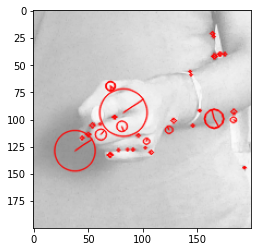

In [7]:
from scipy import ndimage
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt

def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    flag=1
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)
            
            if flag==1 and key =="You":
                im_with_keypoints = cv2.drawKeypoints(img, kp, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                plt.imshow(im_with_keypoints)
                flag=0
                
            if des is not None:
                descriptor_list.extend(des)
                features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_features(train) 
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_features(test)[1] 

In [8]:
from sklearn.cluster import KMeans

def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
# Takes the central points which is visual words    
visual_words = kmeans(150, descriptor_list) 

In [9]:
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

In [10]:
import numpy as np
 
def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words) 

In [11]:
type(bovw_train)

dict

In [12]:
print(len(bovw_train))

50


In [13]:
print(np.shape(bovw_train['One']))

(70, 150)


In [14]:
print(bovw_train['One'])  #dict of labels vs array of floats

[array([0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 2.,
       2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.,

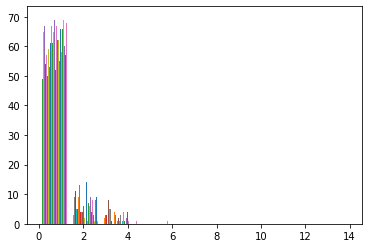

In [15]:
import matplotlib.pyplot as plt
from numpy import array

data = list(bovw_train['House'])
a = np.array(data)
plt.hist(a,bins=None)
plt.show()

In [34]:
X_train=[]

for k,v in bovw_train.items():
    temp=[]
    for i in range (0,len(v)):
        for j in range (0,len(v[i])):
            temp[i].append(v[i][j])
    X_train.append(temp)

IndexError: list index out of range

In [31]:
np.shape(X_train)

(50, 1)

In [24]:
y_train=[]

for k,v in bovw_train.items():
    Y_train.append(k)

In [25]:
X_test=[]

for k,v in bovw_test.items():
    X_test.append(v)


In [26]:
np.shape(X_test)

(50,)

In [27]:
y_test=[]

for k,v in bovw_test.items():
    y_test.append(k)

In [28]:
np.shape(y_test)

(50,)

In [29]:
from sklearn.neighbors import KNeighborsClassifier


error1= []
error2= []
for k in range(1,15):
    knn= KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred1= knn.predict(X_train)
    error1.append(np.mean(y_train!= y_pred1))
    y_pred2= knn.predict(X_test)
    error2.append(np.mean(y_test!= y_pred2))
# plt.figure(figsize(10,5))
plt.plot(range(1,15),error1,label="train")
plt.plot(range(1,15),error2,label="test")
plt.xlabel('k Value')
plt.ylabel('Error')
plt.legend()

ValueError: Expected 2D array, got 1D array instead:
array=[list([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 7., 0., 0., 0., 0., 1., 0., 2., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 1., 2., 0., 2., 0.,
       1., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 2., 3., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 0., 2., 0., 1., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 1., 1., 3., 1., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 0., 1., 2.,
       0., 0., 1., 0., 1., 0., 0., 2., 2., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 2., 0., 0.,
       0., 1., 0., 0., 2., 2., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 2., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 3., 1., 1., 0., 0., 3., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 1., 1., 3., 0., 2., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 0., 1., 0., 1., 2., 0., 0., 1., 1., 2., 1., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 1., 1., 1., 2., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 2., 2., 1., 0., 1., 0., 1., 0., 0., 2., 1., 2., 2., 0., 2.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 7., 0., 0., 1., 0., 0., 0., 1., 1.]), array([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1., 3., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 2., 1., 0., 3., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 2.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 4., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 1.]), array([0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.]), array([0., 0., 3., 0., 0., 0., 0., 1., 2., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 2., 0., 1., 0., 2., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 3., 1., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 4., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 1., 0., 0.,
       1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0.,
       0., 2., 0., 1., 1., 0., 4., 1., 0., 2., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1.,
       0., 0., 3., 0., 0., 1., 1., 2., 1., 0., 1., 0., 2., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0.,
       0., 0., 1., 0., 0., 0., 3., 0., 0., 2., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 3., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 3., 0.]), array([2., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 2.,
       0., 0., 3., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 2., 0., 0., 0.,
       1., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 1., 1., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 3., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 3., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0.,
       0., 1., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([2., 3., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0.,
       0., 4., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 6., 0., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 1., 2., 1., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 4., 0., 0., 0., 0., 0., 0., 1., 1., 0., 5., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([1., 2., 2., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 3., 0., 1., 1., 1., 0., 1.,
       0., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 2., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.]), array([2., 1., 4., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 4., 0., 2., 0., 1., 0., 1.,
       0., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 3., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       2., 6., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 2., 0., 0., 0., 1., 2., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 3., 1., 0., 1., 0., 0., 0., 1., 2., 0., 2., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 1., 2., 0., 2., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 4., 0., 1., 0., 3., 2., 0., 0.,
       0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 4., 1., 0., 0., 0., 0., 0., 2., 2., 0., 2., 0., 0., 1., 0.,
       1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 4., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.]), array([0., 2., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 4., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 3., 0., 1.,
       2., 2., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 3., 0., 3., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 1., 3., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3.]), array([0., 3., 1., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 3.,
       0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 2.,
       1., 4., 3., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 3., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 4., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 2., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 2., 2.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 1., 0., 0., 1., 2.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 1., 1., 0., 5., 0., 0.,
       0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 2., 0., 3., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 1., 0., 0., 4., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 2., 2., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 4.]), array([2., 1., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 2., 1., 0., 1., 0., 0., 0., 0., 4., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 2., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 2., 1., 0.,
       0., 0., 2., 2., 0., 0., 0., 1., 0., 2., 0., 0., 2., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 3., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.]), array([1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0.]), array([1., 1., 0., 0., 0., 0., 0., 3., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]), array([2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 2., 0., 2., 0., 0., 0., 1., 2., 1., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 1.,
       0., 0., 1., 2., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 1., 1., 0., 1., 0., 0., 0., 4., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 2., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 3., 1., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 3., 2., 1.]), array([1., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 2., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 2., 2., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 2., 1.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 3., 1., 2., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 3., 1.]), array([1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 3., 2., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 3., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 3., 2., 1., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 4., 1.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 2., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2.,
       0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 1., 2., 0., 0.,
       0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 8., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]), array([0., 0., 1., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 2., 0., 2., 0., 1., 0., 0., 0., 0., 3., 0., 1., 1., 2.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 3., 0., 2., 2., 3.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 1., 3., 0., 0., 1., 2., 1., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 2.,
       2., 0., 2., 0., 0., 0., 0., 2., 0., 1., 0., 2., 1., 0.]), array([0., 0., 1., 0., 1., 0., 1., 0., 2., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 5., 1., 0., 0., 0., 0., 3.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 3., 1., 1., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 3., 0., 0., 1., 0., 0., 0., 1., 4., 2., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 2.,
       0., 2., 0., 1., 0., 0., 3., 0., 0., 1., 0., 0., 4., 0.]), array([0., 1., 3., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 2., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       2., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 1., 2., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 3., 2., 1., 0., 0., 1., 0., 1., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1.,
       2., 0., 0., 5., 0., 0., 1., 2., 0., 2., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 1., 3., 0., 1.,
       0., 0., 2., 2., 1., 2., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1.,
       2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       3., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       1., 0., 3., 0., 0., 2., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 3., 0., 3., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 3., 0., 2., 1., 0., 1., 0., 0., 0., 1., 1., 4., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 2., 1., 0., 0., 1., 0., 2., 3., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 1., 2., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 3., 0., 0., 0., 1., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 2., 1., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1.]), array([0., 1., 2., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1.,
       0., 1., 1., 2., 0., 2., 0., 1., 2., 0., 1., 0., 1., 1., 3., 1., 2.,
       0., 0., 0., 1., 1., 1., 0., 1., 2., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 2., 0., 0., 0.,
       3., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 2., 0., 0., 1., 0., 2., 0., 2., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 3., 0.]), array([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 6., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 1., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 1., 0., 1., 0., 2., 1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 4., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 4., 0., 1., 1., 0., 0., 0.]), array([0., 0., 4., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 2., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 4., 2., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 1., 0., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 2.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 4., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 4., 2.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 3., 0., 2., 0., 1., 1., 0., 1., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 2., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 0.]), array([0., 0., 2., 2., 2., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 3., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 4., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 1., 0., 0.,
       0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 2., 3., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 2., 0., 0., 0., 0., 2., 0., 0.]), array([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0.,
       0., 3., 1., 2., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 1., 1.,
       0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 3., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 2., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 2., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 3., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 4., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 4., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 2., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0.,
       0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 3., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 3., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 4., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 2., 0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 5., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 6., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 4., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 4., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 4., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 5., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 5., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 4., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0.,
       1., 0., 0., 1., 0., 0., 2., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 1., 1., 0., 1.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 1., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 2., 2., 2., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 1., 0., 0., 0.,
       2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 5., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.])])
 list([array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 6., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 3., 0., 2., 0.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 2., 1., 1., 2.,
       2., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 2., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 3., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 1., 3., 1., 1.]), array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 2.,
       0., 1., 0., 1., 1., 0., 3., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 3., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 3., 2., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 2., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 2., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 2., 1., 0., 0.,
       1., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 1., 0., 1., 0., 2.,
       1., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 2., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 1., 0., 0., 2., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 1., 1., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 2., 1., 1., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 3., 0., 1., 2., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0.,
       0., 1., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 3., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0., 0., 3., 0.,
       0., 0., 1., 0., 0., 1., 1., 3., 1., 0., 3., 1., 0., 0., 0., 1., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 1., 0., 0., 1.,
       0., 1., 0., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 5., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 5., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3., 1.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 4., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 1., 0.,
       0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.]), array([0., 2., 1., 1., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 1., 1., 1., 0., 1., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 2., 2.,
       2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2.]), array([0., 0., 4., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 3., 0., 6., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 2., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 2., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 4., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2.,
       0., 0., 2., 1., 0., 0., 0., 1., 3., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 4., 0., 0.,
       1., 2., 0., 2., 0., 0., 1., 2., 1., 2., 0., 1., 1., 1.]), array([1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0.,
       2., 0., 0., 1., 0., 1., 2., 2., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 3., 3., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 3., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([2., 1., 2., 0., 0., 0., 0., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 3., 1., 0., 2., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 3., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 2., 3., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 3., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 3., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.]), array([0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 1., 4.,
       0., 0., 0., 0., 2., 1., 0., 0., 2., 2., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 4.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 2., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       4., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 3.]), array([0., 0., 0., 2., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 2., 0., 1.,
       1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       2., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 2., 0., 2., 1., 0., 0., 2., 2., 1., 0., 1., 0., 2., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 2., 1., 2., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 4., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 3., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 1., 2.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 4., 0., 1., 0., 0., 0., 2.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       5., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 3., 1., 0., 0., 0.,
       1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 3., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 2., 2.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 1., 2., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 4., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 4., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       1., 1., 0., 0., 0., 0., 0., 3., 3., 1., 0., 0., 1., 0., 1., 1., 3.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 2., 1., 2.]), array([0., 2., 4., 0., 0., 1., 0., 0., 2., 0., 4., 0., 0., 1., 0., 1., 3.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 3., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 3., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.]), array([1., 0., 3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 3., 0., 1., 0., 1., 0., 1., 2., 0., 1., 1., 0., 1., 0.,
       1., 1., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 2., 2.,
       1., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 2., 0., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 2., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), array([0., 1., 3., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 1.,
       1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 2., 1., 2., 0., 0., 0., 0., 3., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3., 3., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 2., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 1., 5., 0., 0., 0., 3., 2., 0., 0.,
       2., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 2., 1., 0.]), array([1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 5., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 2., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3., 1., 2., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 3., 2., 0., 1., 0., 1., 2., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 3., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 2., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 5., 0.]), array([0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       1., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 2., 2., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 3., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 3., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2.]), array([0., 0., 1., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 2., 4., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 2., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 2., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 4., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 2., 0., 0.,
       1., 2., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 2., 0., 0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 2., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 4., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 3., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       2., 3., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 2., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 6., 1.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 7., 0., 3., 0., 1., 0., 0., 0., 2.,
       1., 1., 0., 0., 0., 1., 0., 1., 2., 1., 0., 0., 2., 0., 1., 0., 1.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 2., 2., 0., 0., 0., 0., 0.,
       0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 5., 1., 2., 0., 0., 0., 1., 0., 1., 5., 0.]), array([0., 0., 2., 1., 2., 1., 0., 2., 1., 0., 0., 0., 0., 1., 1., 3., 4.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 4., 2., 0.,
       0., 0., 0., 1., 3., 1., 1., 1., 2., 1., 1., 1., 0., 0., 2., 0., 2.,
       4., 1., 0., 0., 0., 0., 0., 0., 5., 0., 1., 1., 0., 0., 0., 1., 2.,
       1., 1., 2., 0., 1., 0., 0., 4., 6., 1., 0., 2., 1., 2., 1., 2., 0.,
       3., 1., 0., 3., 1., 0., 0., 1., 1., 1., 3., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 2., 0., 2., 1., 1.,
       1., 1., 0., 3., 2., 0., 1., 0., 0., 1., 0., 0., 2., 0.]), array([0., 0., 4., 1., 3., 0., 0., 3., 1., 0., 0., 0., 0., 1., 2., 4., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 4., 0.,
       0., 0., 0., 1., 2., 1., 0., 1., 3., 2., 0., 1., 1., 1., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 2., 0., 0., 1., 0., 3., 4., 3., 0., 0., 2., 7., 0., 2., 0.,
       1., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 3., 0., 0., 1., 3.,
       1., 1., 0., 0., 2., 4., 0., 1., 1., 1., 0., 0., 2., 0.]), array([1., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 5., 0.,
       0., 0., 0., 1., 1., 2., 2., 1., 0., 0., 0., 1., 1., 0., 1., 4., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 4., 0., 3., 1., 0., 1., 0., 1., 2.,
       1., 0., 0., 1., 2., 0., 1., 1., 3., 0., 2., 1., 1., 1., 0., 0., 2.,
       2., 1., 1., 1., 1., 0., 0., 4., 1., 2., 1., 0., 1., 0., 2., 0., 0.,
       1., 1., 2., 2., 3., 0., 2., 1., 1., 0., 1., 2., 0., 0., 3., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 3., 0., 1., 1., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 2., 0., 0., 1., 0., 3., 0., 2., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 2., 5., 1.]), array([0., 1., 3., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 2., 1., 2., 0., 0., 0., 0., 0., 1., 2., 4., 0.,
       0., 1., 0., 2., 1., 1., 0., 1., 1., 0., 0., 1., 2., 0., 0., 1., 1.,
       3., 1., 0., 0., 1., 1., 0., 0., 3., 0., 2., 0., 0., 0., 0., 1., 1.,
       2., 0., 1., 0., 1., 0., 1., 2., 2., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 2., 1., 2., 0., 0., 2., 0., 0., 3., 2., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 3., 0., 1., 0., 1., 0., 0., 3., 0., 0., 0., 0.,
       0., 3., 0., 1., 1., 1., 1., 1., 0., 1., 0., 2., 2., 2.]), array([0., 0., 4., 0., 3., 1., 1., 0., 1., 1., 0., 1., 0., 2., 2., 7., 1.,
       0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 2., 8., 0.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 3., 0., 0., 1., 1., 1.,
       3., 0., 0., 2., 0., 0., 0., 0., 5., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 2., 0., 5., 3., 2., 0., 0., 0., 2., 0., 0., 0.,
       4., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       2., 1., 3., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 2., 1., 2., 2., 1.,
       0., 1., 0., 2., 2., 1., 0., 0., 0., 2., 0., 2., 4., 0.]), array([1., 1., 6., 1., 5., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 3., 0.,
       0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3., 0., 1., 3., 0.,
       1., 1., 1., 1., 2., 1., 2., 0., 2., 2., 0., 2., 0., 0., 0., 1., 1.,
       1., 2., 0., 0., 0., 0., 1., 0., 5., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 0., 3., 3., 0., 0., 0., 3., 2., 2., 0., 2., 2., 1., 0., 0., 1.,
       0., 2., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 2., 0.,
       0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1.,
       2., 2., 0., 0., 2., 1., 1., 1., 2., 1., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 1., 2., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3.,
       1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 2., 0.]), array([0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 5., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 2., 0., 1., 2., 0., 0., 1., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 1., 0., 1., 0.,
       1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1., 1., 1.]), array([0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       4., 0., 0., 1., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0., 3., 1., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       3., 1., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 1., 1., 1., 1.,
       0., 1., 2., 1., 0., 1., 0., 1., 1., 1., 3., 0., 1., 4., 0., 1., 0.,
       0., 0., 2., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0.]), array([0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 1., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 2.,
       2., 0., 1., 0., 1., 0., 0., 0., 4., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 1., 3., 1., 0., 1., 0., 1., 0., 0.,
       2., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 2., 0., 2., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       3., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 2., 1., 0., 0.,
       2., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 3., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 1., 3., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.]), array([0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.]), array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 3., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 9., 0., 0., 0., 0., 1., 1., 2., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 0., 1., 0., 2.,
       0., 2., 0., 0., 1., 0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 3., 3., 1.]), array([0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 1., 0., 2., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 3., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 1.])])
 list([array([1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 2., 3.,
       0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 6., 0., 2., 0., 1., 0., 0.,
       0., 1., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 2., 0., 6., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 4., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 5., 0., 0., 1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 3., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 4., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 3., 3., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 2., 1., 1., 2., 0., 7., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 4., 0., 1., 0., 2., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 2., 0., 2., 1., 1., 7., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 1., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1.]), array([0., 0., 6., 0., 0., 0., 0., 0., 2., 2., 2., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 5., 0., 1., 0., 1., 1., 0.,
       0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 5.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 2., 0., 3., 2., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 4., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 4., 0., 0., 0., 1., 1., 1.,
       0., 1., 3., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 9.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 4., 0., 0., 1., 0., 0., 0., 2.,
       2., 0., 1., 0., 0., 0., 2., 0., 3., 1., 2., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.]), array([0., 3., 6., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 7., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 4., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 2.,
       1., 0., 1., 0., 0., 0., 3., 0., 4., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 1.,
       0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 8.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       3., 0., 1., 0., 0., 0., 2., 0., 3., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 3., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 7., 0., 1., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       2., 0., 0., 0., 0., 1., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 2., 0., 4., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 3., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 3., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 3., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 1., 2., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 8., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 5.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 3., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 2., 0., 3., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 4., 0., 1., 0., 0., 1., 1.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 1., 2., 2., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 2., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 5., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 2., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1., 0.,
       0., 0., 0., 3., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 3., 0., 2., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0.,
       0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
       4., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 2., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 2., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 2., 0., 3., 4., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 2., 0., 4., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 3., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 4., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 4., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 3., 0., 1., 2., 0., 2., 0., 2., 0., 0., 1., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 3., 3., 2., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       3., 0., 1., 1., 0., 0., 1., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 5., 2., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 3., 0., 3., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.]), array([1., 0., 3., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 6., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 3., 2., 0., 6., 0., 1., 0., 1., 0., 0.,
       0., 0., 3., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 3., 1., 0., 6., 0., 1., 0., 1., 1., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 2., 0., 2., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 4.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 1., 0., 0., 0., 2., 0., 3., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 3., 2., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 9., 0., 0., 0., 0., 1., 0.,
       0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 1.,
       2., 0., 1., 0., 0., 0., 2., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 3., 1., 0., 0., 0., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 6., 0., 0., 0., 2., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 5.,
       3., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 2., 0., 2., 2., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 4., 0.]), array([1., 2., 4., 0., 0., 0., 0., 0., 1., 0., 4., 1., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 7., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 8.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 2., 0., 5., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 2.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 1., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]), array([2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 6.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.]), array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       4., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 1., 3., 1., 0., 0., 0., 0., 1., 0., 2., 2., 0., 1., 0., 1., 2.,
       0., 0., 1., 0., 0., 3., 0., 2., 1., 0., 4., 0., 2., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 4., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 3., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 1., 2., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 1., 0., 3., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 3., 0., 0., 0.,
       1., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 2., 0., 0., 0., 0., 0., 1., 1., 4., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 6., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 5.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 1., 1., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 4., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 4., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([1., 0., 0., 0., 3., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 3., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([1., 0., 1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
        0., 11.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,
        0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  0.,  0.,
        0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  4.,  1.,  3.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  2.]), array([0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 3., 1., 0., 0., 0., 0., 2., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 2., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 2., 0.]), array([0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 1.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  1.,
        0., 10.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  4.,  1.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  2.,
        0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([0., 0., 0., 1., 3., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 2., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 4., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.])])
 list([array([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 3., 0., 3., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 4.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.]), array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0.]), array([0., 0., 2., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 3., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 6., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 1., 1., 1., 3., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 3., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 3., 0.,
       0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 2., 5., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       2., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 2., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.]), array([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 2., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 3., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 3., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 4., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 2., 0., 0., 3., 3., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 4., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 4., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 1., 0., 2., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 2., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 2., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), array([2., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 1., 0.]), array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 2., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 3., 0., 2., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 4., 3., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 3., 0., 1., 1., 1., 1., 4., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 4., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 2., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 2., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 2., 2., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 4., 0., 0., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 1., 2., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 4., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 3., 0., 1., 1., 1., 0.,
       2., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.]), array([0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 2., 1., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 3., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 2., 0., 1., 1., 0., 0., 2., 1., 0., 0., 1., 0., 1., 2., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 3., 0., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 3., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 4., 3., 0., 2., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 2.,
       0., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 2., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 3., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 3., 1., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 3., 1., 1., 0., 0., 1., 0.]), array([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 3., 0., 2., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 4., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.]), array([0., 1., 1., 0., 3., 0., 0., 1., 2., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 2., 1., 3., 0., 3., 0., 1., 0., 2.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 2., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 4., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 1., 4., 1., 1., 1., 1., 0., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 2., 0., 0., 1., 0., 0., 2., 1.]), array([1., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 6., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1.,
       3., 0., 1., 0., 0., 1., 0., 1., 3., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 3., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 2., 1., 2., 0., 1., 0., 5., 0., 0., 0., 0., 2., 1.,
       1., 2., 2., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 3., 3., 3., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 2., 2., 2., 0., 2., 0., 0., 1., 1., 6.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 1., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 1., 0., 1., 0., 1., 3., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 3., 1., 1., 0., 0., 1., 2.,
       0., 2., 0., 0., 1., 1., 0., 1., 2., 0., 0., 1., 0., 0., 2., 0., 1.,
       0., 1., 0., 0., 2., 0., 1., 2., 4., 3., 1., 1., 0., 1., 2., 0., 1.,
       0., 0., 0., 0., 0., 1., 2., 1., 3., 1., 0., 1., 0., 0., 0., 1., 5.,
       0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       1., 1., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 6., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 2., 2., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 2., 1., 3., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 2., 2., 0., 2., 0., 1., 3., 0., 1., 0., 0., 0., 2., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 2., 0., 3., 0., 0., 0., 3., 0., 0., 0., 0., 1., 1.]), array([2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 2., 0., 1., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 6., 0., 0.,
       0., 2., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 1., 0., 2., 0., 3.,
       0., 0., 1., 0., 0., 2., 0., 3., 2., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 2., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 1., 1., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 4., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 2., 0., 4., 4., 0., 0., 0., 2., 0., 1., 0., 3.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 3., 1., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([1., 2., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 1., 1., 1., 2.,
       0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 2., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 4., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 3., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 2., 2., 0., 0., 2., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 0., 3., 0., 0., 1., 0., 2., 1., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0.,
       0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 2., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 4., 3., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 3., 1., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.]), array([1., 3., 2., 0., 0., 0., 0., 0., 4., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 2., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       3., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 3., 2., 2., 2., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 3., 0., 0., 0., 0., 0., 2., 1., 1., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 2., 0., 1., 0., 3., 0., 2.,
       0., 1., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 2., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 2., 2., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 3., 0., 1., 0., 0., 0., 0., 3., 0., 1., 1., 0., 1., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 4., 1., 0., 1., 1., 0., 2.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 3., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 2., 3., 0., 0., 0., 0., 1., 0., 2., 2., 0., 1., 0., 0., 2., 2.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 5., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 3., 0., 4., 2., 3., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 1., 1., 3., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 2., 2., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       2., 1., 0., 0., 1., 0., 0., 3., 2., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 3., 0., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 4., 2., 0., 1., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 6., 0., 2., 0., 1., 0., 2.,
       1., 1., 1., 1., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 2., 0., 0.,
       2., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 2.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 2.,
       1., 0., 3., 0., 0., 3., 0., 0., 2., 2., 0., 0., 3., 1., 1., 0., 1.,
       0., 2., 0., 2., 0., 0., 0., 1., 0., 0., 1., 3., 1., 1., 3., 0., 0.,
       0., 1., 0., 2., 0., 0., 2., 0., 1., 1., 2., 0., 0., 1., 0., 2., 1.,
       0., 2., 4., 1., 2., 1., 3., 0., 1., 1., 0., 2., 3., 0., 2., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 4., 0., 3., 2., 3., 1., 0.,
       3., 0., 1., 4., 0., 1., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 3.,
       0., 0., 1., 0., 1., 0., 0., 1., 2., 2., 0., 1., 0., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 1., 0., 3., 0., 1., 1., 0.]), array([1., 2., 1., 0., 0., 0., 0., 2., 0., 2., 1., 1., 0., 2., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 2., 0., 1., 1., 1., 0., 0.,
       0., 1., 3., 2., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 1., 4., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 2., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 2., 0., 0., 1., 0., 0., 2.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 2.,
       0., 0., 2., 2., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 1., 0., 3., 1., 4., 3., 1., 1., 1., 2., 0., 0.,
       0., 0., 1., 3., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 1., 0., 0.,
       0., 2., 2., 1., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 2., 2., 0., 3., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 2., 1.,
       0., 0., 0., 2., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0.]), array([0., 2., 1., 0., 0., 0., 0., 0., 2., 1., 0., 2., 1., 0., 1., 0., 1.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 2., 1., 1., 2., 1., 0., 1., 0., 0., 2., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 3., 2., 1., 0., 3., 0., 0., 3., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 3., 0., 1., 0., 2., 1., 1., 0.,
       0., 0., 1., 2., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1.]), array([1., 1., 1., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1., 1., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0., 2.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0.,
       2., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3., 1., 0., 1.,
       0., 0., 0., 0., 0., 5., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 4.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 3., 1., 0., 2., 0., 0., 0., 2.]), array([0., 2., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 3., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 1., 2., 1., 1., 0., 0., 1., 2., 0., 0.,
       1., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 2., 0.,
       0., 5., 0., 0., 0., 0., 0., 2., 1., 1., 1., 2., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 2., 1., 0.,
       2., 1., 0., 0., 0., 6., 1., 4., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 3., 0., 2., 1., 1., 0., 0., 0., 1., 2., 0., 4.,
       0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 0., 0., 1., 1.]), array([1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 2., 1., 2.,
       0., 0., 1., 1., 0., 0., 0., 3., 1., 1., 0., 0., 0., 1., 3., 0., 2.,
       1., 2., 1., 2., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 4., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 2., 1., 2.,
       1., 0., 0., 0., 0., 5., 1., 3., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 3., 0., 1., 1., 3., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 1., 0., 0., 2., 2., 0., 0., 0., 0., 1., 4.]), array([2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 5., 0., 0., 1.,
       0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1.]), array([0., 4., 1., 2., 0., 1., 1., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 2., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 2., 2., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 2.,
       0., 0., 1., 0., 0., 3., 0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 2.,
       0., 2., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 1., 0., 2., 0., 2., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 2., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 4., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 5., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 2., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 3., 0., 2., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 2., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 2., 1., 0., 1., 0., 2., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 3., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 2.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 3., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 2.,
       1., 1., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 1., 2., 0., 1., 0., 2., 0.,
       2., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 2., 3., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]), array([1., 3., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 2., 0., 4., 1., 0., 1., 0., 2., 0., 1.,
       0., 1., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 4., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 1., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 3., 0., 3., 3., 1., 1., 1., 1., 0., 3., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 1., 0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 3.]), array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 2., 0., 1., 0., 0., 0., 2.,
       0., 1., 2., 3., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 4., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 2., 2., 0., 2.,
       0., 0., 0., 0., 0., 3., 1., 2., 2., 1., 1., 1., 0., 0., 3., 0., 0.,
       0., 0., 1., 0., 0., 3., 2., 0., 0., 1., 0., 0., 0., 2., 2., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 2., 2., 0., 2.,
       0., 4., 1., 3., 1., 2., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2.,
       1., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 2., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 2., 3., 1., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.]), array([0., 2., 1., 1., 0., 1., 0., 0., 1., 1., 0., 3., 0., 2., 1., 3., 0.,
       0., 0., 2., 1., 0., 1., 0., 2., 1., 0., 2., 0., 1., 0., 1., 0., 0.,
       1., 2., 1., 3., 0., 3., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 1., 0., 0., 1., 4., 2., 0., 1., 1., 0., 2., 0., 0.,
       0., 2., 0., 0., 0., 0., 2., 2., 0., 2., 0., 1., 1., 1., 2., 0., 0.,
       1., 0., 1., 1., 0., 3., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 4., 0., 0., 2., 1., 0., 1., 0., 0., 0., 3.]), array([1., 3., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 3., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 2., 1., 2., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 1., 0., 0., 4., 2., 1., 0., 0., 0., 0., 2., 0., 0.,
       1., 2., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 0., 0., 4., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2.]), array([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2., 1., 2., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 2., 4., 1., 0., 0., 2., 1., 0., 0.,
       0., 2., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 1., 0., 1., 2., 3., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 4., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 3., 0., 0., 1., 0., 0., 1., 1., 3., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1.]), array([0., 2., 3., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 1., 1., 0., 1., 0., 3., 2., 0., 3., 0., 0., 0., 2., 0., 0.,
       0., 1., 1., 0., 0., 6., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0., 0.,
       0., 6., 1., 0., 1., 1., 0., 2., 2., 1., 1., 0., 1., 0., 1., 0., 0.,
       3., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 2., 1., 0., 2., 1., 0., 2., 0., 1., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 3., 0., 0., 0., 2., 1., 0., 1.,
       1., 1., 0., 2., 0., 0., 3., 0., 2., 2., 0., 0., 0., 1.]), array([1., 1., 3., 0., 1., 1., 1., 0., 0., 2., 0., 1., 1., 1., 0., 2., 0.,
       0., 1., 0., 2., 0., 2., 0., 0., 1., 0., 1., 0., 2., 1., 2., 1., 2.,
       0., 1., 2., 1., 0., 1., 0., 1., 0., 3., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 1., 5., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 2., 2., 1., 0., 2., 3., 1., 1., 0., 0.,
       0., 3., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 2., 0., 1., 3., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 7., 0., 0., 3., 1., 1., 0., 0., 0., 1., 1.]), array([0., 0., 1., 0., 1., 0., 1., 0., 1., 2., 0., 3., 0., 0., 0., 4., 0.,
       0., 1., 1., 3., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 4.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 4., 1., 2., 0., 0., 1., 0., 1., 1.,
       1., 2., 1., 0., 1., 0., 1., 2., 1., 2., 0., 2., 2., 0., 0., 0., 1.,
       1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 4., 0., 0.,
       0., 0., 1., 1., 0., 4., 1., 1., 0., 0., 3., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 1., 1.,
       0., 1., 1., 4., 1., 0., 4., 1., 2., 0., 0., 0., 2., 1.]), array([0., 2., 0., 0., 0., 0., 0., 1., 4., 1., 0., 1., 0., 1., 0., 4., 0.,
       0., 1., 1., 0., 0., 2., 0., 0., 2., 0., 0., 0., 5., 0., 3., 0., 0.,
       0., 1., 1., 0., 0., 3., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 2., 0., 0., 1., 0., 2., 1., 4., 0., 0., 0., 0., 1., 0.,
       3., 2., 0., 0., 1., 1., 0., 3., 1., 2., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 2., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 2., 1., 0., 0., 1., 1., 0., 0., 5., 2., 1., 0., 4., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 2., 1., 1., 1.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 3., 0., 1., 4., 0.]), array([1., 0., 2., 2., 1., 1., 0., 1., 0., 2., 4., 1., 0., 0., 0., 5., 0.,
       0., 1., 1., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 2., 1., 3., 1., 0., 3., 0., 0., 0., 0., 1.,
       2., 2., 0., 0., 3., 0., 0., 1., 3., 1., 0., 1., 1., 2., 0., 0., 0.,
       2., 2., 1., 2., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 2., 1., 0., 0., 4., 0., 0.,
       0., 0., 3., 0., 1., 1., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 3., 0., 3., 1., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       2., 0., 0., 1., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 3., 1., 2., 0., 1., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 3., 1., 1., 2., 0., 0., 1., 0.,
       0., 2., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 0.,
       3., 0., 0., 1., 1., 2., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 3., 1., 1., 0., 2., 0., 1., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 2., 1., 0.,
       0., 0., 0., 0., 2., 0., 2., 3., 0., 2., 1., 0., 1., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0.]), array([0., 0., 2., 1., 3., 1., 2., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0., 1., 0., 2., 1., 0.,
       0., 0., 0., 1., 1., 4., 0., 1., 1., 2., 4., 0., 0., 1., 0., 0., 2.,
       1., 3., 0., 1., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 2., 0., 0., 3., 0., 1., 0., 1., 2., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 2.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 2., 1., 1.,
       0., 0., 1., 0., 1., 2., 1., 2., 1., 1., 0., 3., 2., 0.]), array([1., 0., 0., 0., 1., 3., 2., 3., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 2., 2., 3., 0., 0., 2., 0., 2., 1., 0.,
       0., 2., 0., 0., 2., 0., 0., 1., 1., 2., 1., 1., 0., 0., 2., 2., 1.,
       1., 0., 1., 0., 1., 0., 1., 0., 2., 0., 3., 0., 0., 2., 0., 2., 0.,
       1., 0., 2., 1., 3., 0., 0., 2., 0., 1., 1., 2., 0., 1., 0., 0., 1.,
       0., 1., 0., 2., 0., 2., 0., 2., 0., 1., 0., 2., 1., 1., 2., 0., 4.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 2., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([1., 0., 2., 3., 2., 2., 1., 1., 0., 1., 0., 2., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 3., 1., 2., 0., 1., 3., 1., 2., 0., 0., 1., 0.,
       0., 1., 0., 3., 2., 0., 0., 1., 1., 1., 0., 1., 1., 0., 3., 2., 1.,
       1., 0., 1., 1., 2., 0., 2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 2.,
       0., 2., 0., 1., 2., 1., 1., 0., 2., 0., 0., 0., 3., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 3.,
       0., 1., 3., 2., 1., 3., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0.]), array([0., 0., 0., 1., 1., 1., 2., 0., 2., 4., 0., 1., 1., 3., 0., 0., 2.,
       0., 2., 0., 0., 0., 2., 0., 0., 3., 2., 0., 0., 1., 2., 0., 1., 1.,
       0., 1., 0., 0., 0., 4., 0., 2., 0., 4., 1., 2., 0., 0., 0., 2., 0.,
       1., 3., 1., 1., 1., 0., 2., 0., 0., 2., 3., 1., 1., 0., 0., 0., 0.,
       1., 1., 3., 0., 5., 1., 0., 2., 3., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 3., 2., 1., 0., 0., 2., 2., 2., 0., 1., 0., 0., 2., 0.,
       3., 2., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 6., 2., 1.,
       1., 1., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 2., 3., 0., 1., 2., 0., 2., 1., 0.]), array([0., 2., 2., 1., 2., 1., 2., 2., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 3., 0., 1., 2., 2., 2., 1., 2., 0., 0., 2., 1.,
       0., 2., 1., 0., 1., 1., 0., 1., 4., 1., 1., 0., 2., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 5., 0., 0., 0.,
       1., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 2., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 3., 1., 0., 2., 0., 1., 2., 0., 1., 1., 0., 1., 1., 2., 0., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 2., 2., 0.]), array([0., 1., 1., 0., 0., 1., 1., 3., 0., 1., 0., 0., 0., 2., 0., 1., 1.,
       6., 0., 0., 1., 0., 3., 0., 0., 1., 0., 1., 0., 2., 1., 0., 0., 1.,
       0., 1., 0., 5., 1., 2., 0., 2., 1., 3., 0., 0., 1., 1., 0., 3., 0.,
       1., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 2., 0., 0., 2., 0.,
       0., 1., 2., 0., 2., 1., 0., 4., 2., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 3., 0., 1., 0., 1., 1., 2., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 2., 0., 0., 3., 0., 1., 1., 1.]), array([0., 1., 4., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 2., 0., 1., 2., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 5., 0., 2., 0., 4., 1., 0., 2., 0., 1.,
       1., 0., 1., 0., 2., 0., 1., 0., 1., 2., 3., 0., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 2., 1., 1., 0., 2., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 1.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 5., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 3., 3., 1., 1., 1., 0., 1., 1., 0., 1., 0., 2., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 4., 0., 1., 0., 2., 0., 0., 1., 1., 1.,
       1., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 2., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 2., 3., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 3., 2., 1.,
       0., 0., 2., 1., 2., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([1., 2., 3., 0., 0., 1., 1., 0., 4., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 2., 2., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 3., 0., 0., 1., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 1., 0., 3., 0., 1., 1., 3.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 2., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 2., 0., 0., 1., 0., 0., 3., 0., 0., 2., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 2., 0., 1., 3., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 5., 0., 1., 0., 1., 0., 3., 1., 2., 1., 2.]), array([0., 1., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 2., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 2., 0., 0., 1., 0., 3., 2., 0., 0., 0.,
       0., 2., 0., 1., 1., 0., 2., 0., 1., 0., 3., 1., 1., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 2., 2., 2., 1., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 1., 0., 0., 2., 5., 1., 0., 2., 0., 2., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 2., 0., 0., 3., 0., 0., 2., 0., 1.]), array([0., 0., 1., 1., 0., 2., 2., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 1., 0., 0., 0., 2., 1., 1., 0., 4., 1., 1., 2.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 2., 6., 1., 0., 0., 0., 3., 1., 0., 0., 3.,
       0., 1., 0., 0., 0., 1., 3., 1., 0., 0., 0., 1., 2., 0., 2., 0., 0.,
       0., 1., 0., 3., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0., 0., 0., 1., 0., 3.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 3., 0., 1., 1., 2., 0., 1., 0., 1., 0.,
       0., 0., 1., 2., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 2., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 2., 0., 3., 1., 4., 0., 1., 1., 1., 0., 1., 0., 0., 2., 0.,
       0., 1., 1., 1., 2., 3., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
       0., 1., 4., 0., 1., 0., 2., 0., 1., 2., 1., 3., 0., 1., 0., 0., 0.,
       1., 1., 1., 2., 2., 1., 1., 1., 0., 1., 1., 1., 1., 2.]), array([0., 2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 1., 1.,
       2., 1., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0., 4.,
       0., 0., 0., 2., 0., 3., 0., 1., 0., 0., 0., 0., 1., 2.]), array([0., 1., 3., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 2., 1., 0., 1., 1., 2., 0., 0., 2.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 2., 1., 1., 3., 2., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 0., 1., 2., 1., 2., 0., 0., 1., 3., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 3., 4., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 2., 0., 3., 0., 0., 1., 1., 0., 0., 2., 2.])])
 list([array([0., 0., 6., 0., 0., 1., 1., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 3., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 2., 0., 0.,
       3., 0., 1., 0., 0., 0., 1., 1., 3., 0., 1., 0., 2., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 1., 0., 2., 0., 0., 4.,
       1., 0., 0., 4., 0., 0., 0., 0., 1., 3., 0., 0., 0., 2.]), array([0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 2.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 2., 0., 4., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 1., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 3., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 3., 1., 1., 5., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 3., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 0., 6., 1., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0., 1., 3.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 3., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 2.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       2., 2., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 3., 3., 0., 0.,
       2., 0., 0., 0., 0., 1., 1., 2., 2., 0., 1., 0., 3., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 2., 1., 0., 0., 0., 2., 1., 3., 0., 0., 0., 2.]), array([1., 0., 7., 1., 0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 3.,
       0., 3., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 3., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       3., 4., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 3., 2., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 2., 1.,
       0., 0., 1., 2., 1., 0., 2., 2., 0., 3., 0., 0., 0., 2.]), array([0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 2., 0., 1.,
       0., 3., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 0., 2.,
       0., 1., 1., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0., 1.,
       0., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       3., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0.,
       0., 0., 0., 1., 0., 5., 0., 3., 0., 0., 2., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), array([1., 1., 4., 1., 0., 1., 0., 2., 0., 0., 2., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 1., 1., 0., 2.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 0.,
       0., 3., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       3., 4., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 3., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 5., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 3., 0., 0., 0., 1., 0., 1., 0., 1., 0., 3.]), array([1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 2., 0., 0., 0., 1.]), array([1., 1., 3., 0., 0., 2., 0., 0., 0., 0., 3., 1., 0., 0., 1., 0., 3.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 6.,
       0., 0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 2., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 2., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 2., 0., 0., 1., 1., 0., 0., 3.]), array([4., 0., 3., 0., 0., 0., 1., 3., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 1., 0., 1.,
       2., 2., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 3., 0., 0., 0., 0., 2., 0., 0., 0., 0., 4., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 1., 3., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 3., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 3., 3., 1., 0., 1., 1., 0., 2.,
       0., 0., 1., 0., 0., 3., 0., 0., 3., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 3.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 3., 2., 0., 0., 2., 1., 0., 2.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 2., 0., 0., 1., 2., 0., 1., 1., 1., 1., 0., 1., 5., 0., 0.,
       3., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 3., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 2., 0., 2., 0., 0.]), array([1., 0., 2., 0., 1., 0., 1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 4., 4., 0., 1., 1., 1., 0., 3.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 2., 0., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 1., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 4., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 2.,
       2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 1., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0.]), array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 1., 0., 2.,
       2., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 3., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 2., 0., 4., 0., 0., 0., 0., 1., 2., 0., 2., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 3., 2., 0., 0., 0., 0., 0., 2., 3., 0., 0., 1., 0., 0., 2.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 2., 0., 1., 1., 1., 0., 0., 1., 0., 1., 2., 0., 3., 0., 1.,
       1., 0., 0., 0., 0., 3., 0., 1., 1., 0., 2., 0., 1., 3., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 3., 0., 2., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 3., 2., 0., 1., 0., 0., 0., 2., 5., 0., 0., 0., 1., 0., 2.,
       1., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 1., 1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 2., 0., 1., 3., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 2., 2.,
       0., 0., 0., 3., 0., 0., 0., 0., 1., 3., 0., 2., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 3., 0., 2.,
       2., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 4., 0., 2., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 2., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 3., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 4.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.]), array([0., 1., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 3., 0., 3.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 2., 3., 0., 3., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 2., 0., 4., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 2., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 3., 2., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 3., 2., 0., 1., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 3., 3., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 5., 0., 1., 1., 2., 0., 3.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 3., 3., 0., 3., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 4., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 2., 0., 1., 2., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 4., 0., 7., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2.,
       2., 0., 0., 1., 0., 0., 1., 2., 1., 1., 2., 0., 1., 3., 0., 4., 0.,
       0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 1., 2., 0., 3., 0., 1.,
       0., 0., 0., 1., 0., 2., 0., 3., 1., 0., 0., 0., 0., 2., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 4., 1., 0., 1.,
       2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 3., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 2., 0., 2., 2., 0., 6., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 1., 0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 2., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 2., 1., 0., 5.,
       2., 0., 1., 1., 0., 0., 2., 0., 1., 1., 2., 1., 0., 3., 0., 2., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 4., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 1., 3., 0., 0.,
       3., 0., 0., 1., 0., 2., 0., 3., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 2., 0., 1., 2., 0., 0., 3., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 4., 0., 3., 2., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 2., 0., 0., 2., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 4., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 3., 0., 0., 1., 0., 2., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 5., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 2.,
       2., 0., 3., 0., 0., 2., 1., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 2., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 4., 1., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 3., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0.,
       0., 3., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 1., 0., 3., 0., 2., 0., 0., 2., 0.]), array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 4., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 2.,
       2., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 2.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 1., 3., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 2., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2.,
       2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       2., 0., 2., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 1.,
       0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 4., 0., 0., 1., 4., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 2., 1.,
       0., 1., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 3., 0.]), array([1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 2., 1., 0., 0., 1., 1., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       2., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 2., 3., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 4.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1.]), array([1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0., 1., 0., 3., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 1., 3., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1.,
       0., 3., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 2., 2.]), array([1., 0., 3., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 4., 2., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 1., 3., 1., 0., 1., 0., 2., 0.,
       0., 2., 0., 0., 0., 0., 1., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 3., 0., 2., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 4., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 4., 0., 0.,
       0., 1., 0., 3., 1., 4., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 3., 0., 0., 3., 2., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 3., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 3., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 1., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 4., 1., 1., 3., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 4., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 1., 0., 1.,
       0., 1., 0., 1., 0., 3., 0., 2., 2., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 2., 0., 0., 0., 0., 3., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 3., 0., 1., 1., 0., 0., 0., 0., 0., 1., 4., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 4., 1., 0., 2.,
       2., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 3., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 2.,
       2., 0., 2., 0., 0., 1., 0., 0., 2., 2., 1., 0., 0., 0., 1., 1., 2.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 2., 2., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 3., 0., 0., 2., 0., 0., 2., 1., 0., 0., 0., 0., 1., 1., 2.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.]), array([1., 1., 3., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 2., 2., 0., 2., 1., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 3., 3., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 2., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 4.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1.]), array([0., 2., 4., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 2.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]), array([1., 3., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 2., 0., 1., 1., 1., 0., 0., 0., 5., 0., 1., 1., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 4., 2., 1., 2.,
       0., 0., 1., 1., 0., 6., 0., 0., 1., 1., 0., 2., 0., 2.]), array([0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 1., 0., 2.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 6., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 2., 1., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 3., 0.,
       0., 0., 0., 1., 0., 7., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 0., 3., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 0., 1.,
       1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 3., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 5., 0., 0., 1., 0., 0., 3., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 2.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 2.,
       1., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 3., 1., 3., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 3., 2.,
       0., 0., 0., 4., 0., 4., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 2., 2., 0., 0., 1., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 2., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 3., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 2., 2., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 5., 0., 6., 0., 0., 0., 0., 0., 1., 0., 2.]), array([0., 0., 7., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 2.,
       0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 3., 2., 1., 1., 0., 0., 0., 0., 1., 0., 1., 2., 2., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 3., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 5.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.]), array([0., 1., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 3., 0., 1., 0., 1., 2., 3.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 3., 1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 3., 1.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4.]), array([1., 1., 6., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 3., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 3., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 2., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 2., 0., 3.]), array([0., 0., 4., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 3., 1., 0., 0., 0., 1., 0., 0., 5., 0., 0., 0., 1., 1., 2.,
       1., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 6., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 3., 0., 1., 0.,
       0., 0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]), array([0., 1., 6., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 3.,
       0., 0., 2., 1., 2., 0., 0., 1., 0., 0., 3., 0., 2., 0., 3., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 8., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 2., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 2., 1.,
       0., 0., 0., 3., 0., 2., 0., 1., 0., 1., 0., 1., 0., 3.]), array([0., 2., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 4.,
       1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2., 0., 2.,
       1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0.,
       3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3.]), array([0., 1., 6., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 2.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 1., 0., 2.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 7., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1., 2., 0., 3.]), array([0., 0., 5., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 4.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 1., 3., 2., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 4., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 0., 1., 0., 3., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 0., 2., 1.,
       0., 0., 0., 3., 0., 5., 0., 0., 0., 0., 0., 1., 0., 3.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 2., 0., 0.,
       2., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 2., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 3., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 3., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1.,
       1., 0., 0., 1., 0., 3., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 2.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 3., 1., 3., 3., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 3., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 1.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 3., 2., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 3., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 3., 0.,
       2., 0., 1., 1., 1., 1., 0., 0., 1., 0., 3., 0., 0., 0., 2., 0., 2.,
       0., 2., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 2., 2., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 1., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 1., 1., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 4., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 2., 0., 1.,
       0., 2., 0., 0., 1., 0., 1., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 3., 1., 2., 0., 2., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 2., 4., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.]), array([0., 1., 2., 2., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0., 1., 1., 1., 0., 0.,
       0., 2., 1., 1., 0., 0., 1., 0., 2., 2., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 3., 3., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1., 0., 1., 2., 0., 2., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 2.,
       0., 1., 0., 1., 1., 0., 0., 2., 1., 3., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 3., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 2., 1., 2., 0., 0., 0., 3., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 1., 2., 1., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 1., 2.]), array([0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 1., 1., 0., 0.,
       0., 0., 2., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 3., 1., 4., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 3.]), array([0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 2., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 2., 1., 2., 6., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 2., 0., 0., 0., 1., 1., 0., 2.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 1.,
       1., 2., 1., 1., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 3.,
       0., 0., 3., 0., 0., 0., 1., 1., 3., 0., 5., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 3.,
       0., 2., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.]), array([0., 1., 2., 0., 0., 0., 0., 1., 1., 1., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 3., 0., 1., 0., 1., 0., 2.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 3., 1., 4., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 1., 1., 1., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 0., 2., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       4., 1., 0., 1., 1., 0., 0., 0., 1., 3., 1., 0., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 1., 2., 0., 4., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])])
 list([array([1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 2., 2., 0.,
       2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 2., 1., 0., 0., 2., 0., 1., 1., 2., 0., 1., 0., 0.]), array([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 2., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 3., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0.,
       2., 0., 1., 1., 0., 2., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0., 0., 2., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 2., 1., 1., 1., 1., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       2., 0., 1., 1., 1., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.]), array([2., 1., 3., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]), array([2., 1., 1., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0., 1., 3.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1., 1., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 2., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 2., 0., 1., 2., 2., 0., 1., 0., 0.]), array([2., 0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 2., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 2., 0., 1., 1.,
       0., 0., 0., 1., 0., 2., 0., 1., 0., 3., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 4., 0., 0., 1., 1., 2., 1., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 1., 1., 1., 0., 2., 0., 1.]), array([1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 2., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 1.,
       0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 4., 0., 1., 1., 0., 2., 1., 0., 0., 0., 1.]), array([0., 2., 4., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 0., 0.,
       3., 1., 1., 1., 0., 0., 0., 1., 3., 1., 1., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0.,
       3., 3., 0., 1., 0., 2., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 2., 1., 0., 2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 0., 1., 2., 0., 1., 0., 1., 3., 0., 0., 1.,
       0., 1., 3., 2., 0., 1., 1., 0., 2., 1., 1., 2., 0., 3.]), array([0., 2., 6., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 2.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 2., 5., 0., 0., 0., 1., 1., 1.,
       2., 2., 1., 1., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 3., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 2., 1., 0., 1., 0., 0., 1., 2., 0., 0., 2., 1., 2., 0., 0.,
       0., 1., 4., 1., 0., 1., 1., 0., 3., 1., 1., 0., 0., 6.]), array([0., 2., 8., 0., 0., 2., 0., 1., 1., 1., 0., 0., 1., 2., 0., 0., 3.,
       0., 0., 2., 0., 0., 0., 0., 0., 2., 1., 4., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 2., 0., 0., 0., 2., 3., 0., 0., 1.,
       0., 3., 1., 1., 0., 0., 1., 0., 2., 1., 1., 1., 0., 3.]), array([0., 2., 5., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 6., 0., 0., 1., 1., 0., 0.,
       2., 2., 0., 1., 0., 1., 0., 0., 2., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 1., 1., 0., 0.,
       1., 2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 0., 1., 1., 2., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 2., 0., 2., 0., 1., 0., 0., 3.]), array([0., 3., 7., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 3.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 4., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 2., 1., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 0., 1., 0., 3., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 4.]), array([1., 0., 2., 0., 0., 2., 0., 1., 2., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 3., 0., 1., 1., 2., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 3., 1., 0., 0., 1., 0.,
       2., 0., 1., 1., 2., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 2., 0., 4., 0., 1., 0., 1.]), array([0., 4., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 4., 0., 1., 0., 2., 0., 0.,
       2., 1., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 1., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
       1., 5., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       2., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 2., 0., 0., 1., 1., 3., 0., 2.]), array([0., 1., 7., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 2., 0., 1., 3.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 2., 3., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 3., 1., 2., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 2., 1., 0.,
       1., 5., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2., 1.,
       1., 0., 2., 1., 0., 1., 0., 2., 1., 0., 0., 0., 1., 2., 0., 0., 1.,
       0., 2., 1., 0., 0., 2., 1., 0., 1., 1., 1., 1., 0., 3.]), array([0., 3., 5., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 3., 1., 8., 0., 1., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 3., 1., 2., 0., 1., 3., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 1., 2.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 2., 0., 1., 0., 0., 2., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 2., 0., 2., 0., 0., 1., 0., 1., 0., 1., 0., 0., 3.]), array([0., 2., 2., 0., 1., 1., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 3.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 4., 0., 1., 0., 1., 0., 0.,
       3., 0., 0., 3., 0., 0., 0., 0., 3., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 4., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       2., 0., 2., 0., 2., 0., 0., 0., 1., 0., 0., 0., 3., 2., 0., 3., 1.,
       0., 1., 2., 1., 0., 2., 1., 0., 1., 2., 1., 2., 0., 2.]), array([0., 2., 2., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 5., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 3., 0., 0., 0., 0., 2., 1., 1., 0., 0., 2., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 2., 1., 0., 1., 1., 2., 0., 0., 1., 2., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 1., 1., 0., 2., 1., 1., 0., 6.]), array([0., 2., 5., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 5., 0., 2., 0., 1., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
       2., 3., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 2., 2., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 2., 0., 1., 2., 0., 0., 2., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 2., 0., 2., 0., 0., 1., 0., 1., 1., 1., 0., 0., 4.]), array([0., 2., 4., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 4.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 4., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 3., 1., 0., 1., 0., 2., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 2., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 2., 1., 0., 1.,
       0., 0., 1., 2., 0., 2., 1., 1., 0., 1., 1., 0., 0., 4.]), array([0., 3., 2., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 4.,
       0., 0., 2., 0., 0., 1., 0., 0., 1., 2., 3., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 2., 1., 1., 0., 1., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 0., 1., 0., 0.,
       1., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 2., 1., 1., 2., 1., 0., 0., 3., 0., 3., 0., 4.]), array([1., 0., 2., 1., 0., 0., 1., 2., 0., 1., 1., 2., 0., 1., 1., 2., 2.,
       0., 0., 0., 1., 0., 1., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0., 2., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 3., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 2., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 1., 1., 1., 1., 0., 2., 0., 1., 0., 3., 2.,
       0., 1., 0., 2., 0., 1., 0., 4., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 1., 1., 4., 0., 1., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.,
       0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 1., 2., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 3., 2., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0.,
       1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 2., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 2., 0., 2., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 2., 2., 0., 2., 0., 1., 0., 1., 0., 2., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 2., 0., 0., 0., 1., 2., 2., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 1., 1., 1., 1., 0., 0., 0., 3., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 6., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 2., 2., 0., 1., 0., 1., 0., 1., 0., 3., 0.,
       0., 1., 0., 1., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 3., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       2., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 1., 2., 1.,
       0., 1., 0., 0., 0., 1., 1., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 2., 0.,
       0., 3., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 0., 1., 2., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 2., 2., 1.,
       0., 0., 0., 0., 0., 2., 2., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 3., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 1., 0., 2., 0., 0., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 1., 2., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 2.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 2., 0., 0., 0., 3., 0., 0., 1.,
       0., 2., 0., 2., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.]), array([0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 4., 0.,
       0., 0., 0., 0., 0., 2., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 4., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 5., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 3.,
       0., 0., 1., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 4., 0., 0., 1., 0., 1., 2., 0., 2., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 2., 2., 0.,
       0., 2., 0., 0., 0., 3., 1., 2., 4., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 2., 0., 0., 3., 0., 0., 0., 0., 2., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 2., 0., 0., 0., 3., 0.,
       0., 0., 0., 1., 0., 2., 2., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 1., 0., 6., 0., 0., 2., 2., 0., 0., 0., 3., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 1., 3., 0.,
       0., 0., 0., 2., 0., 2., 2., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 5., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 1., 0., 0., 2., 2., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 4., 0.,
       0., 1., 0., 2., 0., 2., 0., 3., 2., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 3., 2., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 3., 0.,
       0., 1., 0., 0., 4., 0., 0., 2., 2., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 0., 0., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 2., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 1., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 2., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 2., 0., 0., 3.,
       0., 0., 1., 1., 1., 2., 1., 1., 1., 1., 0., 1., 0., 1.]), array([1., 0., 0., 1., 0., 1., 3., 1., 0., 2., 1., 2., 0., 2., 1., 4., 1.,
       0., 1., 0., 1., 0., 2., 0., 4., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 6., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 5., 0., 0., 0., 2., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 3., 2., 0., 2., 0., 0., 0., 0.]), array([0., 1., 3., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 2., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 6., 5., 0., 0., 0., 1., 1., 2.,
       1., 1., 1., 3., 2., 1., 0., 0., 1., 2., 3., 0., 0., 1., 1., 1., 0.,
       3., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 3., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 1., 0., 0.,
       1., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1.]), array([0., 0., 5., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 4., 3., 0., 0., 0., 2., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 2., 1., 1., 2., 1., 1., 0.,
       4., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 2., 0., 1., 0.,
       3., 0., 1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 2., 0., 1.]), array([0., 0., 7., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 8., 3., 0., 0., 0., 2., 4., 1.,
       0., 1., 1., 2., 1., 1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 1.,
       2., 1., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 3., 1., 2., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 3., 0., 0., 0., 2., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 5., 0., 0., 0., 1., 1., 0., 0., 1.]), array([0., 1., 4., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 4.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 2., 0., 0., 0., 2., 2., 2.,
       1., 1., 1., 2., 0., 0., 0., 1., 0., 1., 2., 0., 0., 2., 0., 1., 2.,
       3., 1., 0., 2., 0., 0., 3., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 1., 2., 1., 0.,
       1., 0., 1., 0., 0., 2., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1.]), array([2., 1., 5., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 2., 0., 2.,
       1., 1., 1., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       2., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 3., 4., 0., 0.,
       1., 0., 2., 0., 0., 2., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 2., 1.,
       1., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1.]), array([0., 2., 6., 0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 2., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 2., 0., 1., 0., 2., 1., 3.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 1., 1.,
       3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       2., 0., 1., 0., 0., 0., 1., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 4., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 9., 2., 0., 0., 0., 2., 1., 2.,
       1., 0., 0., 2., 0., 1., 0., 0., 1., 2., 3., 2., 1., 1., 0., 0., 1.,
       3., 2., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 2., 3.,
       0., 3., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 2., 2., 1., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2.]), array([0., 2., 7., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 2.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 4., 2., 0., 0., 0., 2., 1., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0.,
       3., 1., 0., 1., 1., 0., 3., 2., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 2., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 2., 0., 0., 4., 1., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 2., 2., 0., 0.,
       1., 0., 0., 0., 0., 4., 0., 0., 2., 2., 0., 3., 0., 1.]), array([0., 2., 8., 0., 1., 0., 1., 0., 0., 0., 1., 2., 2., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 3., 0., 1., 0., 1., 1., 3.,
       1., 0., 2., 0., 1., 0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1.,
       5., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 2., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 3., 0., 0., 0., 3., 3., 1., 1.,
       1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.]), array([0., 1., 3., 0., 1., 1., 1., 0., 0., 0., 0., 2., 2., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 7., 3., 0., 1., 0., 2., 1., 3.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       4., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       2., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 2., 3., 1., 0.,
       1., 0., 0., 0., 0., 4., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 2.,
       1., 1., 0., 0., 0., 1., 0., 2., 1., 5., 3., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 2., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 3., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 4., 0., 0., 0., 0., 1., 2., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 1., 0., 0., 4.,
       1., 1., 0., 0., 0., 0., 2., 1., 1., 5., 4., 0., 1., 0., 2., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 3., 0., 0., 1., 0., 1., 1.,
       2., 1., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 3., 0., 0.,
       4., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 5., 0., 0., 0., 2., 0., 3., 0., 1.]), array([0., 5., 4., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 2., 2., 0., 6., 3., 0., 1., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 3., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       2., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 1., 1., 0., 2.]), array([1., 0., 2., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0.,
       2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 2., 0., 0., 1.,
       0., 0., 0., 1., 1., 2., 1., 1., 1., 1., 0., 1., 0., 1.]), array([0., 1., 7., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 1., 0., 1., 4.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 7., 3., 0., 0., 0., 2., 1., 3.,
       1., 0., 2., 0., 1., 1., 0., 0., 0., 1., 3., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 1., 0.,
       3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 3., 0., 0., 0., 1., 1., 1., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 2., 0., 0., 2., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 2., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.]), array([0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 2., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 0., 1., 1., 0., 0., 3.,
       1., 0., 1., 0., 0., 1., 2., 0., 2., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 2., 1., 0., 1., 0., 2., 1., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 1., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]), array([1., 0., 3., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 3., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 2., 0.,
       1., 0., 1., 2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 1., 1., 1., 0., 1., 2., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 1., 0., 2., 1., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]), array([1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 3., 0., 0.,
       0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 0., 2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.]), array([1., 1., 0., 2., 0., 0., 0., 1., 0., 2., 1., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 2., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 3.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.]), array([1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0.]), array([1., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.]), array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 2.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.]), array([1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0.])])
 list([array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 2., 0., 1.,
       1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 3., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 2., 1., 0., 0., 1., 0., 1., 2., 2., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 4., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
       1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.]), array([0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 2., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 3., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.]), array([0., 3., 4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 7., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0.]), array([0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 8., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 4., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 8., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 1., 2., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 4., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 1., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 5., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0.]), array([0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 6., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 7., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 1., 2., 0., 0., 0., 0., 0., 1., 3., 0.]), array([0., 2., 6., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 6., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 6., 0., 0., 2., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 9., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 3., 0., 0., 2., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 1., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 3., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 2., 2., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 4., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 2., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 5., 0., 1.]), array([0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 5.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1.]), array([0., 2., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 3., 0., 1.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 7.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 6., 0., 0., 0., 0., 0., 2., 0., 1.]), array([0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 5.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 3., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 2., 0., 3., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 1., 7., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 4.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 4., 0., 0., 0., 0., 0., 3., 0., 2.]), array([0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 7.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 6., 0., 0., 0., 0., 0., 4., 0., 1.]), array([0., 3., 6., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 2., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 7., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 9.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 3., 0., 0., 0., 0., 0., 2., 0., 3.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 2., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 2., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 2., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 3., 0., 0., 2., 0., 2., 0., 2., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 3., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 2., 0., 0., 2., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 1., 0.,
       0., 4., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
       0., 3., 0., 2., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 4., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 1., 0., 3., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0.,
       0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 1., 0., 0., 1., 0., 3., 1., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 4., 0., 4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 2., 0., 0., 2., 0., 2., 1., 2., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 4., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.])])
 list([array([1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0.,
       1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1., 2., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 2., 1., 0., 1., 1., 0., 4., 2.,
       2., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 3., 3., 0., 0., 2., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 1., 0., 1., 0., 0., 2., 2., 1., 1., 0., 1., 1.,
       0., 1., 1., 2., 0., 1., 0., 0., 0., 2., 0., 3., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 2., 1., 1., 1., 1., 0., 0., 0., 0.,
       3., 4., 2., 0., 3., 1., 1., 3., 0., 1., 1., 4., 0., 0.]), array([0., 0., 4., 1., 0., 0., 0., 1., 3., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 5., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 3., 2., 1., 0., 0., 1., 2., 0., 0., 2., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 1., 4., 0., 1., 0., 1., 1., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1., 1.]), array([1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 2., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       2., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 2., 2.,
       2., 1., 0., 1., 2., 0., 0., 1., 1., 1., 1., 0., 1., 2., 1., 1., 0.,
       1., 0., 0., 3., 2., 0., 1., 1., 2., 1., 3., 1., 1., 0., 0., 3., 2.,
       0., 0., 0., 0., 4., 0., 1., 0., 0., 1., 3., 0., 1., 1., 0., 2., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 2., 0., 0., 4., 0., 0., 1., 2., 0.,
       0., 0., 0., 1., 2., 1., 0., 0., 2., 0., 1., 0., 0., 2., 2., 0., 1.,
       2., 1., 2., 0., 1., 1., 1., 2., 0., 0., 2., 2., 0., 2.]), array([1., 0., 0., 2., 2., 1., 1., 0., 2., 1., 0., 1., 0., 2., 1., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 2., 0., 1., 1.,
       2., 0., 0., 1., 0., 1., 0., 0., 2., 2., 0., 2., 3., 0., 0., 3., 0.,
       2., 1., 1., 1., 1., 0., 0., 3., 1., 3., 1., 0., 1., 0., 2., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 2., 3., 1., 1., 0., 0., 1., 2.,
       1., 0., 1., 0., 3., 0., 1., 0., 0., 0., 2., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 2., 0., 0., 2., 0., 0., 0., 1., 4., 0., 3., 1., 2., 0.,
       0., 1., 0., 2., 2., 0., 0., 2., 1., 1., 0., 0., 2., 3., 0., 0., 0.,
       2., 2., 3., 0., 1., 1., 1., 2., 0., 2., 1., 3., 0., 1.]), array([1., 1., 0., 2., 0., 1., 1., 0., 1., 2., 1., 0., 0., 0., 3., 1., 2.,
       2., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 2., 1., 0., 1., 3.,
       2., 0., 0., 1., 1., 2., 1., 0., 1., 1., 0., 0., 4., 0., 0., 2., 2.,
       3., 1., 0., 1., 1., 0., 1., 3., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 2., 0., 1., 3., 0., 0., 1., 1., 2., 0.,
       2., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 3., 0., 1., 1., 2., 0., 0., 1., 4., 0., 0., 1., 1., 1.,
       0., 0., 0., 3., 0., 0., 2., 1., 4., 0., 0., 0., 0., 0., 1., 1., 1.,
       2., 3., 4., 0., 2., 2., 0., 2., 0., 1., 3., 2., 0., 0.]), array([1., 1., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 3.,
       1., 1., 1., 0., 2., 1., 0., 1., 0., 0., 2., 1., 3., 1., 1., 0., 1.,
       1., 0., 3., 2., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 2., 3., 0.,
       0., 2., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 2., 1., 2., 0.,
       2., 0., 0., 1., 1., 2., 0., 1., 0., 2., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       2., 3., 1., 0., 1., 0., 1., 0., 0., 1., 2., 3., 0., 0., 0., 3., 0.,
       1., 0., 1., 0., 3., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 3.,
       2., 1., 0., 1., 2., 2., 2., 1., 3., 0., 2., 0., 0., 1.]), array([1., 0., 2., 0., 0., 1., 0., 2., 1., 0., 1., 0., 0., 0., 2., 1., 3.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0.,
       0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       3., 1., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 5., 2., 3., 0.,
       1., 0., 0., 0., 0., 1., 3., 1., 3., 0., 2., 0., 0., 2., 0., 1., 0.,
       1., 0., 0., 0., 3., 0., 1., 0., 0., 0., 2., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 2., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 3., 0., 0., 2., 2., 0., 0., 2., 1., 2., 0., 0., 0.,
       0., 3., 0., 1., 1., 3., 2., 1., 1., 0., 1., 2., 1., 1.]), array([1., 2., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       3., 0., 0., 1., 1., 1., 0., 0., 0., 1., 6., 0., 0., 1., 1., 3., 0.,
       2., 1., 0., 2., 2., 1., 1., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0.,
       2., 0., 0., 2., 0., 1., 2., 1., 2., 0., 0., 1., 1., 0., 3., 0., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 1., 2., 1.,
       2., 0., 0., 3., 2., 2., 0., 0., 0., 3., 1., 0., 1., 0., 1., 0., 0.,
       1., 4., 1., 2., 0., 0., 2., 1., 1., 1., 0., 0., 4., 2., 3., 4., 1.,
       5., 1., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 0., 3., 2., 4., 0.,
       0., 0., 2., 4., 2., 1., 0., 0., 2., 1., 1., 6., 0., 1.]), array([1., 1., 5., 0., 1., 1., 0., 3., 0., 0., 1., 0., 1., 1., 0., 0., 4.,
       2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 3., 2., 1.,
       1., 0., 0., 0., 2., 1., 0., 0., 1., 1., 1., 1., 0., 2., 1., 2., 1.,
       2., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 2., 2., 0.,
       2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 3., 1.,
       1., 1., 0., 1., 1., 3., 0., 0., 1., 2., 0., 0., 1., 1., 2., 0., 0.,
       2., 1., 0., 1., 0., 1., 2., 1., 1., 1., 1., 0., 7., 1., 3., 0., 1.,
       2., 0., 0., 0., 1., 0., 0., 0., 4., 1., 1., 0., 1., 3., 1., 1., 0.,
       0., 3., 1., 2., 2., 1., 1., 0., 2., 0., 1., 3., 0., 6.]), array([1., 4., 0., 0., 1., 2., 0., 3., 2., 0., 1., 0., 0., 0., 0., 0., 3.,
       2., 1., 0., 0., 0., 1., 0., 0., 0., 3., 3., 0., 0., 1., 2., 1., 0.,
       1., 2., 1., 0., 1., 1., 1., 0., 1., 1., 3., 1., 0., 2., 0., 1., 6.,
       0., 1., 0., 1., 0., 1., 3., 0., 0., 0., 0., 1., 2., 0., 3., 0., 0.,
       3., 2., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2., 2., 0., 0., 3., 1.,
       0., 1., 0., 2., 1., 2., 0., 0., 2., 3., 0., 0., 0., 1., 2., 0., 0.,
       2., 1., 1., 0., 0., 0., 1., 1., 0., 2., 1., 0., 5., 2., 2., 1., 1.,
       4., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 2., 0., 1., 4., 0.,
       0., 0., 1., 3., 2., 1., 0., 0., 2., 0., 0., 2., 0., 3.]), array([0., 4., 9., 0., 0., 2., 2., 2., 2., 0., 1., 1., 2., 0., 1., 2., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 4., 0., 1., 0., 1., 1., 1.,
       3., 0., 0., 0., 4., 1., 0., 0., 0., 0., 3., 1., 1., 2., 0., 1., 2.,
       1., 1., 0., 3., 1., 0., 0., 1., 1., 2., 0., 0., 1., 0., 3., 0., 0.,
       0., 2., 0., 0., 1., 2., 3., 1., 2., 1., 0., 0., 0., 0., 0., 0., 2.,
       3., 1., 0., 1., 1., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 2., 1., 0., 1.,
       0., 1., 2., 1., 2., 0., 0., 0., 1., 0., 0., 2., 0., 2.]), array([0., 1., 6., 0., 1., 2., 4., 1., 1., 0., 1., 0., 2., 2., 1., 1., 3.,
       1., 0., 2., 0., 0., 1., 1., 0., 1., 5., 2., 0., 1., 0., 3., 1., 2.,
       4., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 2., 1., 2., 1., 2., 3.,
       0., 0., 0., 3., 0., 1., 0., 0., 1., 2., 0., 0., 2., 0., 4., 1., 0.,
       1., 2., 0., 0., 0., 1., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 2.,
       2., 1., 0., 0., 3., 1., 0., 0., 1., 2., 2., 0., 0., 0., 2., 0., 0.,
       2., 0., 1., 0., 0., 2., 3., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       4., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0.,
       0., 1., 0., 2., 1., 0., 0., 0., 1., 1., 1., 2., 0., 4.]), array([1., 3., 5., 0., 1., 1., 5., 2., 1., 0., 1., 0., 1., 2., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 2., 0., 0., 3., 7., 0., 0., 0., 4., 1., 0.,
       3., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 2., 2., 3., 1., 2., 3.,
       1., 0., 0., 2., 0., 0., 0., 1., 2., 2., 1., 0., 3., 0., 4., 1., 0.,
       1., 4., 0., 0., 0., 1., 3., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 2., 0., 3., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 3., 1., 1., 2., 1., 0., 3., 2., 1., 0., 1.,
       3., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 2., 1., 1., 0., 0., 0., 1., 0., 1., 2., 0., 2.]), array([0., 1., 5., 0., 0., 2., 1., 2., 1., 0., 1., 1., 0., 0., 0., 0., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 4., 1., 1., 1., 2., 1., 1.,
       2., 1., 1., 1., 2., 1., 0., 1., 0., 0., 2., 2., 0., 2., 0., 1., 0.,
       1., 1., 0., 3., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0., 2., 1., 1.,
       1., 1., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 2., 0., 0., 0., 3., 1., 0., 2., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 1., 6., 1., 0., 0.,
       5., 2., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 5., 0., 2., 1.,
       0., 2., 1., 2., 2., 3., 0., 0., 0., 0., 2., 1., 0., 3.]), array([1., 0., 1., 1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 4., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 2., 2., 0., 1., 1., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 4., 0.,
       2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 2., 2., 1., 1., 1., 1., 2., 0., 1., 2., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 3., 2., 0., 1., 2., 0.,
       0., 0., 1., 2., 1., 0., 0., 1., 1., 0., 1., 1., 2., 0., 0., 1., 0.,
       1., 6., 2., 1., 3., 1., 1., 2., 0., 0., 2., 0., 1., 1.]), array([1., 2., 3., 0., 0., 1., 3., 1., 0., 0., 1., 0., 0., 0., 0., 2., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 3., 3., 1., 0., 1., 2., 0., 1.,
       4., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 2., 3., 4., 1., 2., 2.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 2., 0.,
       3., 2., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 4., 1., 1., 0.,
       3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 4., 0., 2., 2.,
       0., 4., 0., 4., 2., 3., 1., 2., 1., 0., 1., 2., 0., 1.]), array([0., 3., 4., 0., 0., 1., 2., 0., 4., 0., 1., 1., 0., 0., 1., 1., 3.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 1., 0., 1., 3., 1., 0.,
       3., 2., 1., 1., 2., 0., 0., 0., 0., 0., 0., 1., 2., 5., 1., 2., 3.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 2., 1.,
       0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 3., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 2., 2., 0., 0., 0., 0., 1., 4., 1., 1., 0.,
       1., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 5., 0., 1., 2.,
       1., 6., 0., 2., 2., 2., 0., 2., 1., 1., 1., 1., 0., 2.]), array([0., 3., 4., 0., 0., 2., 3., 2., 0., 0., 0., 1., 0., 0., 1., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 4., 1., 0., 0., 3., 1., 0.,
       1., 1., 0., 1., 2., 0., 0., 0., 0., 1., 1., 1., 0., 4., 1., 1., 1.,
       0., 0., 0., 3., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 2., 1., 1.,
       1., 0., 0., 1., 0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 2., 4., 2., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1., 1.,
       0., 1., 1., 0., 2., 1., 1., 1., 2., 0., 1., 3., 0., 2.]), array([1., 2., 3., 0., 1., 2., 3., 1., 1., 0., 1., 2., 0., 2., 2., 1., 5.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 1., 1., 1., 1.,
       4., 3., 2., 1., 2., 0., 1., 1., 1., 1., 1., 2., 1., 3., 1., 1., 3.,
       1., 0., 1., 4., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 2., 2., 1.,
       1., 2., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 2., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 2., 1., 0., 1., 2., 1., 0., 0., 0., 0., 4., 2., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2.,
       0., 3., 1., 3., 1., 3., 0., 0., 1., 1., 1., 4., 0., 6.]), array([1., 2., 2., 0., 0., 1., 3., 1., 0., 0., 0., 2., 2., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 1., 1., 0., 2., 1., 0.,
       4., 1., 0., 1., 2., 0., 1., 0., 1., 1., 2., 1., 2., 2., 1., 1., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 2., 2., 0., 0., 1., 0., 3., 3., 0.,
       0., 2., 0., 0., 0., 0., 1., 2., 1., 2., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 2., 1., 0., 1., 0., 2., 1., 1., 0., 1., 0., 2., 0., 0.,
       1., 0., 1., 1., 0., 2., 2., 1., 1., 0., 1., 0., 4., 2., 2., 0., 0.,
       2., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 1.,
       0., 1., 1., 1., 2., 2., 0., 1., 0., 1., 0., 4., 0., 2.]), array([0., 4., 4., 1., 1., 1., 1., 2., 5., 0., 1., 0., 0., 2., 0., 1., 5.,
       0., 0., 2., 0., 1., 0., 0., 0., 1., 7., 2., 0., 0., 2., 3., 2., 1.,
       2., 1., 0., 1., 2., 0., 0., 1., 1., 0., 0., 1., 1., 3., 1., 0., 4.,
       0., 1., 1., 2., 0., 2., 1., 0., 1., 1., 0., 0., 1., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 1., 2., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 2., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 3., 2., 0., 1., 1., 0., 1., 4., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 5., 0., 2., 2.,
       0., 2., 0., 4., 2., 3., 0., 1., 1., 0., 0., 2., 0., 2.]), array([1., 5., 4., 0., 0., 0., 2., 2., 1., 0., 1., 2., 0., 3., 1., 0., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 7., 0., 1., 3., 1., 1., 0.,
       2., 2., 0., 1., 0., 0., 0., 0., 1., 0., 2., 1., 0., 1., 1., 1., 3.,
       0., 0., 1., 3., 0., 1., 1., 0., 0., 2., 0., 0., 1., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 2., 2., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 3., 1., 0., 2., 0.,
       1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 1.,
       1., 1., 0., 3., 2., 3., 0., 1., 1., 0., 0., 2., 0., 2.]), array([1., 1., 2., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 3., 4.,
       1., 1., 2., 0., 0., 4., 0., 0., 0., 0., 0., 1., 1., 2., 1., 1., 2.,
       2., 0., 0., 2., 3., 0., 0., 2., 1., 1., 0., 0., 3., 1., 0., 3., 0.,
       2., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 1., 0., 1., 1., 1., 2., 0.,
       0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 1.,
       0., 3., 0., 5., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 3., 0.,
       0., 0., 0., 1., 2., 0., 1., 1., 2., 0., 2., 0., 0., 0., 0., 2., 0.,
       1., 5., 2., 0., 2., 2., 1., 1., 1., 1., 2., 2., 0., 1.]), array([0., 1., 4., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 1., 3., 1., 0., 3., 0., 0., 1., 2., 1., 1., 2., 0., 5.,
       0., 4., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       2., 0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 2., 1., 0.,
       0., 1., 3., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       2., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 3., 1., 2.,
       0., 1., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0.,
       2., 2., 3., 1., 0., 0., 4., 0., 0., 0., 0., 2., 1., 0.]), array([0., 0., 8., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 2., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 5.,
       0., 2., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 1.,
       1., 0., 3., 0., 0., 2., 2., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 2., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 2., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 4., 1., 2.,
       1., 3., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0.,
       2., 3., 2., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.]), array([1., 1., 2., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 2., 2., 5., 1., 0., 0., 1., 0., 0.,
       0., 0., 3., 0., 2., 3., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 2.,
       1., 2., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       2., 0., 2., 0., 0., 1., 1., 0., 2., 0., 0., 3., 3., 0., 0., 1., 0.,
       1., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 1., 0., 0., 2., 0., 2., 1., 1., 0., 1., 2., 4., 3., 2.,
       0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 5., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 2., 1., 1.]), array([2., 1., 2., 0., 1., 0., 0., 0., 1., 1., 2., 1., 1., 1., 0., 4., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 4., 0., 1., 1., 0., 1., 0.,
       0., 2., 2., 0., 0., 4., 1., 1., 0., 0., 0., 0., 1., 1., 2., 0., 4.,
       0., 3., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 3., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 1., 2., 1., 1.,
       2., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 5., 0., 1., 1.,
       1., 3., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), array([2., 0., 2., 0., 1., 1., 0., 1., 1., 2., 0., 1., 1., 0., 0., 6., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 2., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0., 1., 2., 2., 1., 5.,
       0., 2., 0., 4., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 2., 2., 0., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0.,
       0., 1., 2., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 4., 0., 0., 0., 3., 0., 1., 1., 1., 0., 0., 1., 3., 2., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 1.,
       1., 0., 0., 2., 0., 0., 2., 2., 0., 0., 0., 2., 0., 0.]), array([2., 0., 8., 0., 1., 1., 0., 0., 1., 2., 1., 1., 1., 0., 1., 4., 4.,
       0., 0., 0., 1., 0., 0., 0., 0., 3., 1., 3., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 3.,
       0., 2., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 3., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 1., 2., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 6., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 2., 2., 2., 3.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 2., 1., 0., 0., 1., 2., 1., 0., 0., 0., 3., 1., 2.]), array([1., 1., 6., 0., 1., 0., 1., 0., 0., 2., 2., 1., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 2., 1., 0., 3., 0., 2.,
       2., 0., 0., 2., 2., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
       2., 1., 5., 1., 0., 3., 1., 1., 0., 0., 0., 3., 1., 0., 1., 1., 0.,
       0., 1., 2., 0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 3., 0., 2.,
       0., 5., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 1., 2., 1., 0., 0., 2., 0., 1., 1., 0., 0., 1., 2.]), array([0., 0., 5., 1., 1., 0., 1., 0., 3., 1., 0., 0., 0., 2., 0., 5., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 2., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 2., 0., 0., 1., 0., 2., 1., 0., 0., 0., 2., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 2., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 2., 2., 1.,
       1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 3., 2., 1., 0.,
       1., 0., 0., 3., 0., 0., 2., 0., 0., 1., 0., 1., 0., 2.]), array([0., 0., 6., 1., 1., 0., 1., 0., 0., 1., 2., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 5., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 1., 1., 0., 0., 1., 0., 1., 0., 3., 1., 3., 0., 6.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       2., 0., 2., 1., 0., 1., 1., 0., 2., 0., 1., 3., 1., 0., 2., 0., 0.,
       0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 2., 0., 0., 1., 2., 0., 0., 1., 4., 0., 0.,
       0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 5., 1., 1., 0.,
       1., 2., 2., 2., 1., 0., 1., 0., 0., 1., 0., 3., 0., 0.]), array([0., 1., 5., 0., 1., 2., 0., 0., 2., 1., 0., 0., 0., 1., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 3., 0., 2., 1., 0., 2., 1., 0., 0., 0., 0., 0., 3., 0., 5.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 2., 0.,
       3., 0., 3., 2., 1., 1., 2., 2., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 5., 2., 0., 0., 2., 0., 1., 1., 0., 0., 0., 2., 2., 2., 3.,
       0., 3., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 5., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 3., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 4., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 2., 0., 0., 1., 0.,
       0., 0., 1., 0., 5., 3., 0., 0., 0., 0., 0., 0., 1., 0., 5., 1., 5.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 0., 1., 2., 1., 1., 1., 1., 1., 0., 0., 1., 2., 2., 1., 0., 0.,
       1., 0., 2., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 2., 0., 5., 2., 1., 0.,
       1., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 1., 0.,
       3., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1.]), array([1., 0., 1., 1., 2., 1., 0., 2., 1., 1., 0., 0., 0., 1., 1., 2., 1.,
       3., 1., 2., 1., 0., 4., 0., 1., 0., 0., 0., 1., 1., 1., 3., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 2., 0., 1., 0., 1., 0., 3., 1.,
       2., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       2., 0., 0., 1., 0., 0., 2., 2., 2., 0., 1., 0., 1., 1., 2., 0., 0.,
       1., 0., 0., 0., 4., 2., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 1., 0., 0., 2., 0.,
       0., 0., 1., 2., 4., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 2., 0.,
       1., 6., 1., 0., 1., 3., 1., 2., 0., 1., 1., 1., 0., 0.]), array([0., 0., 5., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 5., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 3., 2., 0., 1., 0., 0., 0., 2., 1., 5., 0., 2.,
       1., 1., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 2., 1., 1., 1., 0.,
       1., 1., 3., 2., 1., 1., 1., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0.,
       0., 2., 2., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 4., 1., 1., 2.,
       0., 4., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0.,
       1., 1., 1., 1., 0., 0., 2., 0., 2., 1., 0., 4., 0., 0.]), array([1., 0., 2., 0., 1., 0., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0.,
       5., 1., 3., 0., 1., 1., 2., 0., 0., 2., 5., 0., 2., 0., 2., 0., 0.,
       1., 0., 2., 0., 3., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 2., 0.,
       2., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 1.,
       0., 2., 0., 2., 0., 2., 0., 0., 0., 2., 0., 2., 2., 0., 0., 2., 1.,
       0., 0., 0., 2., 1., 2., 2., 0., 0., 2., 1., 0., 1., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 2., 2., 1., 2., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 4., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 3., 0., 0., 4., 1., 0., 2., 0., 1., 1., 0., 2.]), array([2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       5., 1., 1., 0., 2., 0., 1., 0., 0., 5., 5., 0., 2., 1., 1., 0., 0.,
       1., 0., 0., 0., 3., 0., 0., 0., 2., 1., 2., 1., 1., 3., 1., 1., 2.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       4., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 3., 0.,
       1., 0., 0., 3., 3., 2., 2., 0., 0., 2., 0., 0., 2., 0., 0., 2., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 3., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 5., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 5., 0., 0., 1., 0., 0., 2., 1., 1.]), array([0., 1., 1., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       4., 0., 2., 0., 5., 1., 1., 0., 1., 4., 1., 1., 1., 2., 1., 0., 1.,
       3., 0., 1., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 3., 0.,
       2., 0., 3., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 7., 1., 0., 0., 2., 1., 1., 0., 2., 0., 2., 1., 0., 0., 1., 0.,
       1., 0., 0., 2., 1., 5., 0., 0., 0., 2., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 1., 0., 3., 0., 0., 6., 1.,
       0., 2., 1., 0., 0., 0., 2., 0., 4., 0., 0., 1., 0., 0., 0., 2., 1.,
       1., 0., 2., 1., 0., 6., 0., 0., 1., 0., 0., 2., 0., 1.]), array([1., 2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       3., 1., 0., 0., 3., 0., 2., 0., 1., 7., 2., 0., 1., 3., 2., 0., 1.,
       2., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 2., 1., 3., 0.,
       1., 1., 6., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 2., 1., 0., 0., 2., 2., 0., 0., 3., 0., 1., 1., 0., 0., 1., 0.,
       2., 0., 1., 2., 3., 3., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 6., 2.,
       1., 0., 1., 1., 0., 1., 0., 1., 2., 0., 0., 1., 0., 2., 2., 0., 0.,
       0., 1., 1., 1., 0., 3., 0., 1., 1., 1., 1., 5., 1., 0.]), array([1., 1., 1., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 3.,
       3., 1., 2., 0., 5., 0., 2., 1., 0., 6., 1., 1., 2., 0., 2., 0., 0.,
       0., 0., 0., 3., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0.,
       2., 0., 3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2., 2., 0., 0., 2., 0.,
       2., 0., 1., 1., 1., 3., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 2., 0., 3., 6., 4.,
       0., 1., 1., 0., 0., 2., 1., 0., 7., 0., 0., 1., 0., 1., 1., 1., 0.,
       1., 2., 2., 1., 0., 7., 0., 1., 0., 1., 0., 3., 1., 0.]), array([ 1.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  2.,  3.,  1.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,
        3.,  0.,  1.,  0.,  3.,  0.,  1.,  2.,  0.,  1.,  2.,  1.,  2.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  3.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,
        2.,  1.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,
        0.,  0.,  1.,  0.,  2.,  1.,  1.,  0.,  1.,  0.,  2.,  1.,  2.,
        0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  2.,  2.,  1.,  0.,
        1.,  0.,  0.,  0.,  1.,  1.,  4.,  0.,  3.,  0.,  1.,  1.,  3.,
        1.,  0.,  2.,  0.,  0.,  2.,  2., 11.,  0.,  1.,  2.,  2.,  1.,
        2.,  0.,  2.,  0.,  1.,  0.,  0.]), array([0., 1., 1., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       4., 1., 2., 0., 3., 0., 2., 0., 1., 7., 3., 0., 3., 1., 1., 2., 0.,
       1., 1., 0., 1., 3., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 3., 0.,
       2., 1., 5., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 2., 2., 3., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 3., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 3., 2.,
       1., 1., 0., 0., 0., 1., 1., 0., 5., 1., 0., 3., 2., 2., 1., 1., 0.,
       1., 1., 1., 0., 0., 8., 0., 0., 0., 0., 1., 3., 0., 1.]), array([0., 0., 2., 1., 1., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 3.,
       4., 2., 1., 0., 5., 0., 2., 1., 1., 7., 1., 1., 2., 1., 1., 0., 1.,
       2., 0., 1., 0., 2., 0., 1., 1., 0., 1., 0., 2., 0., 1., 0., 1., 1.,
       1., 0., 5., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.,
       0., 3., 0., 1., 0., 1., 0., 0., 0., 2., 2., 3., 2., 0., 1., 2., 0.,
       1., 0., 0., 2., 2., 4., 0., 0., 0., 4., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 4., 0., 0., 3., 2.,
       0., 0., 0., 2., 0., 1., 1., 1., 3., 2., 0., 2., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 3., 0., 0., 1., 0., 2., 5., 1., 1.]), array([1., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       7., 1., 0., 0., 4., 0., 3., 0., 0., 6., 2., 1., 1., 0., 2., 0., 1.,
       1., 0., 1., 0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 2., 0.,
       2., 0., 3., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 2., 0., 0., 2., 0., 0., 1., 0., 0., 3., 0.,
       1., 1., 1., 1., 2., 2., 0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 6., 1.,
       2., 1., 0., 2., 0., 1., 1., 0., 4., 0., 0., 2., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 2., 0., 0., 1., 0., 2., 2., 1., 0.]), array([1., 1., 1., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2.,
       4., 1., 1., 0., 3., 0., 1., 0., 1., 7., 4., 0., 0., 2., 1., 0., 1.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0.,
       2., 0., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 4., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 2., 2., 2., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 4., 2.,
       2., 1., 0., 1., 0., 0., 1., 0., 4., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 3., 0., 0., 4., 1., 0., 1., 0., 1., 1., 0., 0.]), array([0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       5., 2., 1., 0., 4., 0., 2., 0., 2., 8., 4., 0., 0., 2., 0., 1., 0.,
       2., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 3., 0.,
       1., 1., 4., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 1., 2., 0., 0., 3., 0., 2., 1., 0., 1., 3., 0.,
       1., 0., 0., 2., 1., 2., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 7., 1.,
       1., 1., 0., 0., 0., 1., 1., 2., 2., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 2., 0., 0., 2., 0., 1., 1., 0., 2., 3., 1., 0.]), array([0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       8., 1., 3., 0., 4., 1., 1., 0., 0., 9., 4., 0., 2., 2., 0., 0., 1.,
       0., 0., 1., 0., 3., 0., 0., 0., 0., 2., 0., 0., 2., 3., 0., 2., 0.,
       1., 0., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 4., 0., 3., 2., 0., 0., 1., 0.,
       0., 1., 0., 2., 3., 3., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 4., 3.,
       1., 0., 0., 2., 0., 0., 1., 1., 7., 0., 1., 2., 0., 0., 1., 0., 1.,
       1., 1., 3., 1., 0., 4., 0., 0., 1., 0., 2., 1., 0., 0.]), array([0., 1., 3., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       4., 2., 1., 0., 4., 0., 3., 0., 1., 3., 2., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 4., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       2., 0., 7., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 4., 1., 0., 0., 2., 3., 0., 0., 4., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 2., 3., 2., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1., 3., 2.,
       1., 0., 0., 1., 0., 0., 1., 0., 6., 0., 0., 5., 0., 0., 0., 0., 1.,
       0., 2., 1., 0., 0., 5., 0., 0., 1., 0., 1., 1., 0., 1.]), array([0., 1., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       5., 1., 4., 0., 3., 0., 1., 0., 0., 6., 1., 1., 1., 2., 1., 0., 0.,
       2., 0., 1., 1., 3., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 3., 0.,
       1., 0., 5., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 3., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 2., 0., 0., 1., 0.,
       1., 1., 0., 2., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 1., 2.,
       1., 1., 0., 1., 0., 1., 1., 0., 9., 0., 0., 2., 0., 0., 1., 0., 0.,
       1., 1., 4., 2., 0., 2., 0., 0., 0., 0., 2., 3., 1., 1.]), array([0., 0., 0., 0., 2., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       5., 1., 2., 0., 2., 0., 2., 0., 2., 5., 3., 0., 1., 1., 1., 0., 0.,
       3., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 4., 0., 0., 1., 2., 1., 1., 0., 1., 0., 1., 1., 1., 0., 2.,
       0., 3., 1., 1., 0., 1., 2., 0., 0., 1., 0., 1., 2., 0., 2., 2., 0.,
       0., 1., 0., 2., 0., 2., 1., 0., 0., 3., 0., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 1., 2., 5., 4.,
       1., 0., 0., 0., 0., 0., 0., 0., 8., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 4., 1., 1., 1., 0., 0., 0., 0., 1., 3., 1., 0.]), array([1., 2., 1., 1., 0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 2., 0., 0.,
       2., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 3., 2., 1., 1.,
       2., 0., 2., 1., 1., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 3., 1.,
       2., 0., 2., 3., 1., 1., 1., 0., 0., 7., 0., 1., 0., 1., 2., 2., 1.,
       1., 0., 1., 4., 1., 0., 1., 3., 2., 0., 1., 1., 1., 1., 1., 2., 2.,
       0., 1., 2., 1., 3., 0., 2., 1., 1., 0., 1., 0., 0., 0., 2., 0., 0.,
       3., 1., 1., 3., 0., 0., 1., 1., 1., 1., 1., 2., 0., 2., 2., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 2., 2., 0., 3., 1., 1., 0., 0., 2.,
       0., 2., 0., 0., 1., 2., 1., 1., 0., 2., 1., 1., 0., 1.]), array([2., 1., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       6., 1., 3., 0., 2., 0., 3., 0., 0., 4., 2., 0., 2., 1., 2., 0., 1.,
       1., 0., 2., 2., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3., 1.,
       1., 0., 5., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1.,
       0., 2., 1., 0., 1., 1., 1., 0., 0., 1., 1., 2., 1., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 2., 2., 2., 3.,
       1., 0., 0., 2., 0., 0., 0., 2., 8., 0., 0., 6., 0., 0., 0., 0., 0.,
       1., 0., 2., 1., 0., 6., 1., 0., 0., 0., 2., 1., 0., 0.]), array([ 0.,  1., 11.,  3.,  0.,  0.,  1.,  2.,  2.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
        0.,  3.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  2.,  1.,  0.,  0.,
        1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  3.,  2.,
        0.,  0.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  3.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
        2.,  1.,  0.,  0.,  1.,  1.,  0.,  2.,  5.,  1.,  2.,  0.,  1.,
        1.,  2.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  4.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        2.,  2.,  0.,  0.,  1.,  3.,  2.]), array([ 0.,  1., 11.,  2.,  0.,  1.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
        1.,  5.,  0.,  1.,  1.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  0.,
        1.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  5.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  3.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        1.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  4.,  0.,  2.,  0.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  3.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  3.,  0.,  0.,  0.,  4.,  0.]), array([0., 2., 5., 1., 0., 0., 0., 2., 5., 1., 0., 1., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 0., 3., 1., 2., 0., 1., 4., 0., 2., 0., 1., 1., 2.,
       0., 0., 1., 0., 0., 2., 2., 2., 0., 0., 0., 1., 0., 0., 2., 0., 2.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       2., 1., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 3., 0., 0., 0.,
       0., 2., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 5., 0., 2., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 1., 3., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 2., 0.]), array([0., 1., 7., 3., 0., 0., 0., 1., 3., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 3., 1., 2., 1., 1., 3., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 2., 2., 1., 2., 0., 0., 1., 0., 0., 2., 0., 2.,
       0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0.,
       6., 0., 2., 0., 0., 0., 0., 2., 2., 0., 1., 0., 2., 1., 0., 0., 0.,
       0., 1., 2., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 5., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1., 0., 2., 0.]), array([0., 2., 8., 2., 0., 1., 0., 2., 4., 1., 0., 0., 0., 0., 1., 1., 2.,
       1., 0., 0., 0., 0., 2., 1., 1., 1., 0., 1., 0., 1., 0., 2., 1., 2.,
       1., 1., 2., 3., 0., 1., 2., 2., 0., 0., 0., 2., 0., 0., 2., 1., 2.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       3., 0., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 3., 1., 3., 0., 1., 1., 2.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 7., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 3., 1.]), array([0., 1., 8., 4., 0., 0., 0., 2., 2., 2., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 2., 1., 1., 0., 0., 4., 0., 1., 0., 1., 1., 2.,
       0., 0., 0., 0., 0., 3., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 2., 0., 2., 0., 0., 0., 0., 1.,
       5., 2., 2., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 4., 0., 3., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 7., 1., 1., 1.,
       1., 0., 0., 2., 0., 0., 0., 1., 3., 0., 0., 1., 2., 1.]), array([0., 0., 5., 2., 0., 1., 0., 1., 5., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 2., 1., 1., 0., 0., 3., 0., 2., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 3., 1., 2., 2., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 5., 0., 3., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 4., 1., 4., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 3., 1., 0., 1., 2., 1.]), array([0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 2., 1., 2.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 1.,
       1., 0., 0., 0., 4., 1., 0., 1., 1., 0., 0., 1., 3., 0., 3., 3., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 1., 3., 0.,
       1., 0., 0., 2., 0., 1., 2., 3., 2., 0., 2., 0., 1., 0., 0., 2., 2.,
       0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 1., 2., 0., 2., 2., 1., 4., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 3., 1., 1., 0., 2., 0., 2., 1., 1., 1., 1., 0., 2.,
       1., 2., 2., 0., 1., 3., 1., 0., 0., 3., 0., 1., 0., 0.]), array([0., 0., 3., 2., 0., 0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 3., 1., 0., 2., 0., 4., 0., 1., 0., 0., 1., 2.,
       0., 0., 1., 3., 0., 2., 4., 2., 1., 0., 0., 2., 0., 0., 2., 0., 4.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0.,
       2., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 4., 0., 2., 0., 1., 1., 2.,
       1., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 5., 1., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 3., 1.]), array([0., 0., 5., 3., 0., 0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 2., 1.,
       1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 5., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 2., 3., 0., 1., 0., 0., 1., 0., 1., 2., 0., 4.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 4., 0., 2., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 2., 3., 0., 0., 0., 2., 0.]), array([0., 1., 4., 2., 0., 1., 0., 2., 3., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 3., 1., 1., 0., 0., 2., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 2., 2., 1., 1., 0., 0., 2., 1., 0., 1., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       4., 1., 2., 0., 0., 0., 0., 2., 1., 1., 1., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 2., 0., 2., 0., 1., 1., 2.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 1., 0.]), array([ 0.,  1.,  6.,  3.,  0.,  0.,  0.,  3.,  3.,  2.,  0.,  0.,  0.,
        1.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,  1.,  3.,  1.,  0.,  0.,
        1.,  1.,  0.,  2.,  0.,  1.,  1.,  2.,  0.,  0.,  3.,  2.,  2.,
        1.,  3.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  3.,  1.,
        0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,
        0.,  0.,  2.,  6.,  0.,  4.,  0.,  0.,  0.,  0.,  2.,  4.,  0.,
        2.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        2.,  2.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,
        1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  3.,  0.,  2.,  0.,  1.,
        1.,  2.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,
        0.,  0., 10.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  1.,  1.,  0.,  1.,  2.,  0.]), array([0., 0., 5., 3., 0., 1., 0., 3., 3., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 3., 1., 0., 0., 0., 9., 0., 0., 0., 1., 1., 1.,
       0., 0., 2., 3., 0., 3., 3., 0., 0., 0., 1., 1., 1., 2., 2., 0., 7.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       5., 0., 3., 0., 0., 0., 0., 1., 0., 0., 2., 2., 1., 3., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 3., 2., 3., 0., 1.,
       2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 5., 0., 3., 0., 1., 1., 2.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 4., 0., 0., 0., 3., 1.]), array([0., 1., 6., 2., 0., 0., 0., 3., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 2., 1., 0., 1., 0., 3., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 2., 2., 0., 1., 0., 0., 1., 1., 1., 2., 0., 3.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       4., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 3.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 4., 0., 2., 0., 1., 1., 3.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 3., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 2., 0.]), array([0., 0., 7., 2., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 4., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 3., 1., 1., 0., 0., 2., 1., 0., 2., 0., 3.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 4., 0., 2., 0., 1., 1., 2.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.]), array([0., 0., 8., 1., 0., 0., 0., 2., 3., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 3., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 3., 3., 1., 1., 0., 0., 2., 0., 0., 1., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       4., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 2., 0., 0., 1., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 0., 0.]), array([0., 0., 9., 3., 0., 0., 0., 2., 3., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 1., 1., 0., 0., 0., 1., 3., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 3., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 2.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 2., 0., 1., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2.,
       2., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 0., 3., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 5., 0., 3., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0.])])
 list([array([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 2., 0., 2.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 3., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0.,
       1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 3., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 3., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.]), array([0., 2., 5., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 2., 0., 1., 0., 1., 0.,
       3., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 1., 4., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.]), array([1., 2., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       2., 1., 0., 0., 0., 1., 1., 0., 0., 7., 4., 1., 0., 1., 0., 2., 1.,
       2., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 1.,
       0., 2., 0., 0., 0., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       2., 0., 1., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.]), array([0., 0., 5., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 2., 5., 0., 0., 1., 0., 1., 0.,
       3., 4., 0., 2., 0., 0., 2., 0., 0., 0., 2., 1., 0., 2., 0., 0., 2.,
       0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 3., 0., 0.,
       0., 4., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 4., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       2., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 1., 0., 3.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 4.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       3., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 5., 0., 0., 2.,
       0., 0., 1., 2., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.]), array([0., 1., 6., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 1., 1., 1., 6.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 4., 0., 0., 0., 0., 0., 0.,
       4., 3., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 1., 0., 1.,
       0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 3., 2., 1.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 3.]), array([0., 2., 3., 0., 1., 1., 0., 1., 0., 0., 1., 0., 2., 0., 1., 0., 4.,
       3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       4., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 3., 1., 0., 0.,
       0., 0., 1., 2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       3., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 2., 0., 0., 0., 1., 0., 0., 1., 0., 2., 4., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 3.]), array([0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 3., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 5., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.]), array([1., 2., 0., 0., 1., 1., 1., 1., 1., 0., 2., 0., 3., 0., 2., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 4., 0., 1., 0., 0., 1., 0.,
       4., 1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 1., 0., 1., 1., 0., 2.,
       0., 0., 1., 1., 0., 0., 2., 2., 0., 0., 0., 0., 1., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 1., 0., 0.,
       2., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 3., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 2., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 2., 0., 1.,
       0., 0., 3., 0., 0., 0., 1., 1., 1., 1., 3., 0., 0., 0., 0., 1., 0.,
       4., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 2.,
       0., 0., 1., 2., 0., 0., 1., 2., 0., 1., 0., 0., 1., 1., 3., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 1., 1., 0., 1., 2., 0., 4., 0., 1., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 4., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 1.]), array([1., 2., 2., 0., 0., 1., 1., 1., 0., 0., 2., 0., 1., 1., 2., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 5., 0., 1., 0., 0., 1., 0.,
       4., 3., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 4.,
       0., 0., 1., 2., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 3., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 3., 0., 2., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 1., 2., 0., 2.]), array([1., 1., 3., 0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 5.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 5., 1., 0., 1., 0., 1., 0.,
       3., 3., 0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 0., 3., 0., 0., 3.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       2., 2., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 3., 0., 1., 0.,
       0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 3., 3., 0., 2., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       4., 3., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 1., 3., 2., 1., 0., 0.,
       3., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 2., 0., 1., 1., 1., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 5., 0., 0., 1., 0., 1., 0.,
       3., 1., 0., 0., 1., 0., 0., 0., 0., 0., 3., 2., 0., 2., 0., 0., 1.,
       0., 0., 1., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2.]), array([0., 1., 5., 0., 1., 1., 1., 0., 0., 0., 1., 0., 2., 0., 1., 0., 3.,
       0., 0., 0., 1., 2., 0., 1., 1., 0., 2., 2., 0., 0., 1., 0., 1., 0.,
       3., 3., 0., 0., 1., 0., 1., 0., 1., 0., 2., 0., 0., 4., 1., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 1., 1., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 3.]), array([0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 5.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 2., 5., 0., 0., 0., 0., 1., 0.,
       3., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 1., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 2., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.]), array([0., 1., 7., 0., 1., 1., 1., 1., 2., 0., 0., 0., 2., 1., 1., 0., 5.,
       0., 0., 0., 1., 2., 0., 1., 0., 0., 5., 2., 0., 0., 0., 0., 1., 1.,
       2., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3.,
       0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 1., 0.,
       2., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]), array([0., 2., 5., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 4.,
       1., 0., 1., 2., 1., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       3., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 3., 0., 0., 3.,
       1., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 3., 0., 2., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.]), array([0., 1., 4., 0., 0., 1., 1., 0., 2., 0., 1., 0., 1., 1., 1., 0., 5.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 5., 7., 0., 0., 0., 0., 1., 0.,
       1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 5., 0., 0., 2.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 2., 0.,
       3., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 2.]), array([1., 0., 4., 1., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       3., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 4., 0., 1., 0.,
       1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 2., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 5., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       2., 1., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 2., 1., 0., 3., 0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 6., 0., 1., 0., 0., 3., 1., 0., 1., 0., 1., 2., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 3., 0., 2., 1., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1., 0., 2., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 3., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0.]), array([1., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 6., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 1., 0., 0., 2., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 3., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 2., 0., 3., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0.]), array([1., 0., 9., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 4., 1., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 2., 0., 2.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 2., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 4., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 5., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 6., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 4., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 1., 2., 1., 0.,
       2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 6., 0., 1., 0., 0., 2., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 6., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 4., 0., 0., 1., 0., 1., 5., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 2., 1., 0., 1., 2., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0.,
       1., 0., 3., 0., 0., 1., 2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 1., 0., 2., 0., 0., 0., 0., 0., 1., 3., 1., 0.,
       1., 2., 2., 2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.]), array([1., 0., 4., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 4., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.]), array([1., 1., 3., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 3., 0., 2., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 5.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 2., 2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.]), array([1., 0., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 3., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 2., 1., 0., 0., 0., 0., 0., 1., 2., 3., 0., 1., 0.,
       0., 0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.]), array([2., 0., 2., 0., 0., 0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 4., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 1., 1., 0., 1., 0., 2., 0., 0., 2., 2., 0., 1., 1.,
       0., 0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]), array([1., 0., 4., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 4.,
       0., 0., 0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 2., 0., 2., 0., 2.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.]), array([2., 1., 3., 2., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 2., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 4., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 2., 1., 0., 0., 2., 0., 2., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       4., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 2., 0., 0., 0., 0., 2., 0., 2., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 1., 2., 1., 0., 0., 1.,
       1., 2., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 1., 1., 0., 0., 0., 2., 1., 1., 3., 1., 0., 2., 0., 2., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 3., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 3., 1., 0., 0., 0., 2., 0., 1., 2., 1., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 2., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 2., 0., 0., 0., 2., 0., 1., 2., 1., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 2., 1., 2., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 3., 1., 0., 1., 0., 1., 0., 0., 0., 0., 3.]), array([0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 1., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 1., 0., 3., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 1., 1., 2., 0., 2., 0., 0., 0., 0., 2.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 2., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2.,
       1., 0., 4., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 2., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2.,
       0., 3., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 4., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 3., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 2., 0., 0., 0., 1.,
       0., 2., 1., 0., 2., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 1., 3., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 1., 3., 0., 2., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 3., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 2.,
       0., 3., 1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.]), array([0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 1., 2., 0., 1., 0., 0., 3., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 2., 1., 1., 0., 0., 0., 4., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 0., 4., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 2., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.]), array([1., 0., 4., 3., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 3., 1., 3., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 0., 2., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 1., 3., 1., 0., 0., 0., 0., 0., 4., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 3., 1., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 2., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1., 0.,
       3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 5., 1., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1.,
       0., 2., 1., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 1., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 4., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 1., 1., 0., 2.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 5., 2., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 4., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 4., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 4., 0., 2., 0., 1., 0., 2., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 5., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 2., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1.,
       0., 0., 2., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 4., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 2., 2., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 3., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 2., 2., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 4., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 2., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2., 0., 0.,
       0., 1., 3., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 5., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 5., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 5., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 1., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 1., 1., 2., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 2., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 3., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 3., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2.]), array([0., 0., 4., 0., 2., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 2., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 3.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 4., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 2., 0., 0., 1., 2., 0., 0., 1., 3., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 3., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([1., 0., 2., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 2., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 1., 1., 2., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.]), array([1., 2., 3., 0., 0., 2., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 2.,
       0., 0., 0., 1., 0., 2., 3., 0., 0., 0., 1., 1., 1., 0., 0., 2., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 2.]), array([0., 1., 4., 0., 0., 2., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 2., 1., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 0., 3., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 2.]), array([1., 1., 4., 1., 0., 2., 1., 0., 0., 1., 2., 1., 0., 2., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 1., 1., 0., 2.,
       0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1., 2., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0.,
       1., 0., 0., 0., 3., 1., 2., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 1., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.]), array([1., 1., 5., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1.,
       1., 1., 0., 3., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 3., 1., 2., 2., 1., 0., 0., 0., 2., 0., 0., 0., 0.]), array([2., 0., 3., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 4.,
       2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
       0., 1., 0., 2., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 2., 0., 3., 0., 2., 0., 1., 0., 0., 0., 1., 0.,
       2., 0., 1., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 3., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.]), array([1., 1., 3., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 3., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.]), array([2., 0., 6., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 4., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 2., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       2., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 2.]), array([2., 3., 4., 1., 0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 4., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2., 1., 0., 0., 1., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.]), array([2., 2., 5., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 2.]), array([1., 1., 4., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 3., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 0., 0., 0., 3., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 2.,
       1., 0., 0., 0., 1., 0., 2., 3., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 2., 1., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       2., 0., 0., 0., 1., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.]), array([3., 0., 5., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 3., 2., 0., 0., 1., 1., 2.,
       0., 0., 0., 0., 0., 1., 3., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 3., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0., 0., 4., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2.]), array([3., 0., 9., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 5., 1., 2., 1., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3.]), array([3., 0., 4., 0., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 6., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 2., 1., 0., 0., 2., 2., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 3., 1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 3., 1., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.]), array([1., 2., 7., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 5., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 2., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([ 1.,  3., 13.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,
        0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  8.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,
        0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  4.,  1.,  2.,  1.,  2.,  0.,  1.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,
        0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  3.]), array([1., 4., 9., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 5., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 3., 4., 0., 0., 0., 1., 0., 1., 0., 3., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 8., 0., 0., 0., 1., 0., 0.,
       1., 2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 3., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 4., 0., 0., 1., 0., 1., 0.,
       2., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3.]), array([1., 2., 5., 0., 0., 0., 1., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 1., 0., 2.,
       1., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 6., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 2., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 2., 0., 1., 2., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 2., 0., 1., 1., 1., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 2., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.]), array([ 0.,  3., 11.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  5.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  1.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  3.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,
        0.,  0.,  0.,  4.,  0.,  2.,  1.,  2.,  0.,  0.,  2.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  2.,  0.,  2.,  0.,  0.,
        0.,  0.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  2.]), array([0., 1., 8., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 6., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 2., 1., 0., 0., 0., 3., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 2., 0., 2., 1., 1., 0., 0., 1., 0., 0., 2., 0.,
       0., 0., 1., 0., 1., 2., 2., 0., 1., 1., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 3., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 4., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 3., 1., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3.]), array([2., 3., 9., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 7., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 4., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 2., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 2., 1., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([2., 4., 7., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 7., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 0., 1., 1., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 4.]), array([1., 2., 7., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 3., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 3., 1., 2., 0., 2., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 5., 6., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 9., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 4., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 3., 2., 2., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 1., 2., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 2., 8., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 8., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 5., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 4., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 2., 1., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 3., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 3., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       1., 1., 2., 2., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0.]), array([0., 1., 2., 2., 2., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 1., 0., 0., 1., 0.,
       0., 1., 2., 0., 1., 0., 0., 2., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 3., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 3., 2., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 3., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0.]), array([0., 0., 3., 0., 1., 0., 1., 0., 0., 1., 1., 2., 0., 2., 1., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 3., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 3., 0., 3.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 5., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 1., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 1., 0., 0., 2., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 2., 0.]), array([0., 1., 2., 1., 3., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 2., 2.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 3., 0., 1., 1., 0., 3., 2., 0., 2., 1., 0., 0., 2., 0., 0.,
       2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 4., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 2., 0.]), array([0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 1., 2.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 4.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       2., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0., 3., 1., 0.]), array([1., 1., 3., 0., 0., 3., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 2., 2., 0., 1., 1.,
       0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 2., 2., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 3., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 6., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0., 1., 0.,
       2., 4., 0., 0., 0., 0., 0., 1., 2., 2., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 3., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 1., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 2., 0., 0., 0., 2., 2., 1., 0., 1., 0., 3., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 4., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 4., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 3., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 1., 0., 2., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 1., 1., 2., 0., 2., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 3., 1., 0., 0.,
       0., 4., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.]), array([0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 3.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.]), array([1., 3., 5., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 4., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 5., 0., 2.,
       0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 2., 0., 0., 1., 0., 0., 2.,
       2., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0.,
       0., 6., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1.]), array([2., 1., 2., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 3.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 3., 1., 2., 2., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
       1., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 1., 0., 2., 0., 0., 0.,
       1., 1., 0., 2., 0., 1., 0., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 3., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 1.]), array([0., 1., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 3., 0., 0., 4., 1., 1., 0., 1., 0., 1., 2., 0., 0.,
       2., 1., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 2., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       1., 0., 0., 3., 3., 0., 0., 4., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       2., 0., 0., 2., 1., 0., 0., 4., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 2., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0.]), array([0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       2., 0., 0., 2., 1., 0., 0., 4., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0.]), array([0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 2., 2., 0., 0., 4., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 3., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 4., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 1., 1., 0., 0., 3., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 2., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 3., 0., 0., 3., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
       1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 1., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.]), array([0., 1., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 2., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 3., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       1., 0., 0., 1., 2., 1., 0., 3., 1., 0., 0., 1., 0., 3., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 1., 0., 0., 3., 0., 1., 1., 1.]), array([0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 2., 1., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 1., 0.]), array([1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1., 1.,
       0., 2., 0., 0., 1., 1., 0., 4., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.]), array([0., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 2., 1., 0., 0., 2., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 2., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0.]), array([0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 3., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 0.]), array([0., 2., 1., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 1., 0., 4.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 3., 1., 0., 0., 1., 3., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]), array([1., 3., 4., 0., 0., 2., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       3., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 1., 1., 2., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 3., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 5.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 3., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 3.,
       0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 1., 0., 2., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 3., 3., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 3.,
       0., 1., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])])
 list([array([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 1., 4., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0., 0., 0., 2.,
       0., 1., 2., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 6.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 1., 3., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 3., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 2., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 0., 2., 0., 1., 2., 1., 1., 0., 0., 1., 2., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1.,
       1., 0., 0., 0., 5., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 2., 1., 0., 1., 1., 0., 1., 0., 0., 0., 5., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 6., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 2.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 2., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 1., 0., 0., 3., 3., 0., 0., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 2., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 2., 0.]), array([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 6., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 2., 0., 2., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 2., 0.,
       0., 0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 5., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 5., 0.]), array([1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 1., 1., 2.,
       2., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 2., 0., 0., 0., 1., 1., 2., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 5., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 3., 0.]), array([1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 1., 0.,
       0., 0., 2., 0., 3., 0., 2., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 2., 0., 2., 0.,
       1., 0., 1., 1., 0., 1., 1., 2., 3., 0., 0., 0., 0., 3., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 2., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       2., 0., 0., 0., 5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 2., 0.]), array([1., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 2.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 6., 0., 1., 1., 0., 2., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0.,
       0., 3., 1., 2., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 3., 2., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 3., 0., 0., 1., 0.,
       3., 0., 0., 0., 0., 2., 1., 1., 2., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 2., 2., 1., 1.]), array([0., 0., 2., 0., 1., 1., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 2., 0., 0., 4., 7., 0., 0., 2., 0., 2., 0.,
       3., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 1., 2., 0.,
       2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0.]), array([0., 2., 3., 0., 0., 0., 1., 0., 1., 0., 2., 1., 2., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 6., 0., 0., 0., 1., 1., 0.,
       3., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 2., 0., 0., 2., 0., 0., 1., 0., 1., 0., 2., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 3., 5., 0., 0., 0., 1., 1., 0.,
       3., 2., 0., 0., 0., 1., 1., 0., 0., 0., 4., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 2., 2., 2.,
       0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 1., 0., 2., 0.,
       3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 3.]), array([0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 5.,
       3., 0., 0., 0., 0., 0., 1., 0., 0., 6., 3., 0., 0., 2., 0., 0., 0.,
       2., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 1., 0., 2.,
       0., 0., 0., 2., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       3., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0.]), array([1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 2., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 6., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 2., 0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 1., 2., 3., 2., 0., 0., 0., 0., 4., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 4., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0.]), array([0., 4., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 4.,
       0., 0., 0., 0., 2., 0., 2., 0., 1., 3., 5., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 3., 1., 0., 1., 2., 1., 0.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 2., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1., 0., 1.]), array([0., 2., 1., 0., 0., 1., 0., 2., 1., 0., 2., 0., 1., 0., 0., 0., 3.,
       1., 0., 1., 0., 1., 0., 2., 0., 0., 2., 3., 1., 0., 1., 0., 1., 0.,
       3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 2., 0., 3., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0., 0.,
       0., 0., 2., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 3., 4., 0., 1.]), array([0., 2., 2., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 1., 2., 0., 2., 0., 0., 5., 3., 0., 0., 1., 0., 0., 0.,
       3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 1., 0., 2., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1., 0.,
       1., 1., 2., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 1., 2., 0., 0., 0., 0., 2., 1., 0., 1.]), array([0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 3.,
       1., 0., 0., 0., 2., 1., 1., 1., 0., 5., 3., 0., 0., 1., 0., 1., 0.,
       4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1., 0., 2.,
       0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 3., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3.,
       3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.]), array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 2., 0., 2., 1., 0., 3., 4., 1., 0., 2., 0., 1., 1.,
       3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 2., 1., 0., 0., 2., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 2., 0., 1., 0., 0., 0., 1., 3., 1., 1., 2.,
       3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 3., 0., 0., 1., 1., 0., 2., 0., 0.]), array([1., 0., 4., 0., 1., 2., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 2.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 1., 0., 1., 1.,
       3., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 3., 1., 0., 4.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2.,
       0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 2., 1., 0., 0., 1., 0., 2., 3., 0., 1., 0.,
       1., 1., 1., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 5., 0., 1., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 2.]), array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 2.,
       1., 0., 0., 0., 3., 0., 1., 0., 0., 2., 1., 0., 0., 1., 2., 1., 1.,
       3., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 4., 1., 0., 1., 0.,
       1., 0., 3., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       3., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 4., 0., 2.]), array([0., 2., 3., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0.,
       2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 2., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2.,
       1., 0., 0., 0., 4., 1., 0., 0., 0., 0., 2., 1., 1., 2., 1., 1., 0.,
       0., 0., 0., 0., 2., 0., 1., 2., 1., 0., 0., 0., 2., 0., 1., 2., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 2., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 2., 2., 0., 2., 2., 0., 1., 0., 0., 2., 0., 4., 1., 2., 0.,
       0., 0., 0., 0., 1., 1., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 3., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.]), array([0., 1., 8., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 1., 3.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 3., 0., 1., 0.,
       1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]), array([0., 0., 7., 0., 0., 0., 0., 0., 2., 0., 3., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 4.,
       0., 0., 0., 2., 0., 0., 1., 0., 4., 0., 1., 0., 0., 0., 1., 1., 1.,
       2., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.,
       0., 0., 2., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 1., 4., 0., 1., 0.,
       1., 4., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.]), array([0., 0., 3., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 2.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 4., 0., 1., 0., 1., 1., 1.,
       1., 1., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 5.,
       2., 0., 0., 3., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 0., 2., 0., 0., 1., 1., 1., 0., 2., 2., 0., 0., 3., 0., 0., 0.,
       0., 2., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 2., 0., 1., 0.,
       0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0.]), array([1., 0., 7., 0., 0., 0., 1., 0., 0., 2., 2., 1., 1., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1., 0., 0., 0., 1.,
       2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 3., 0., 1., 2., 1., 0., 0., 3., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 2., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 3., 0.]), array([0., 0., 6., 0., 0., 0., 0., 0., 3., 1., 2., 0., 1., 1., 0., 0., 2.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 5., 0., 1., 0., 1., 2., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 3.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 2., 0., 1., 2., 1., 1., 0., 4., 0., 0., 0.,
       0., 1., 1., 0., 2., 1., 0., 3., 0., 0., 2., 0., 2., 2., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 2., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 5.,
       1., 0., 0., 1., 0., 0., 2., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 3., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 2., 0., 1., 1., 0., 2., 3., 0., 0., 0., 2., 3., 1., 2., 0.,
       0., 1., 0., 0., 0., 3., 0., 0., 1., 0., 0., 1., 1., 0.]), array([1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 2., 0.,
       2., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 2., 2., 1., 0., 1., 0., 0., 4., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 2., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.]), array([0., 1., 4., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       1., 0., 0., 2., 0., 0., 0., 1., 3., 0., 1., 0., 2., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 3., 2., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 2., 1., 0., 1., 2., 0., 0., 0., 0., 5., 0., 1., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.]), array([0., 1., 7., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 5., 0., 0., 0., 0., 2., 1.,
       1., 1., 3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 3.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       3., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 2., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 4., 2., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.]), array([0., 0., 5., 0., 0., 0., 0., 1., 0., 2., 3., 0., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 2., 0., 0., 0., 2., 4., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 3.,
       0., 1., 0., 0., 0., 0., 1., 0., 4., 0., 1., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 3., 1., 1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0.]), array([0., 1., 4., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 2.,
       0., 3., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 2., 0., 2.,
       0., 0., 0., 1., 0., 0., 1., 0., 2., 2., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 3., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 4., 1., 0., 0., 0., 0., 0., 0., 4., 2., 0., 2., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 5., 1., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 2., 0., 2., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 1., 1.,
       2., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 2., 0., 0.,
       0., 0., 1., 1., 1., 2., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 4., 0., 0., 4., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       1., 4., 0., 0., 0., 1., 1., 0., 0., 0., 0., 4., 4., 2.]), array([0., 0., 2., 1., 0., 0., 0., 1., 1., 1., 2., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 1., 0., 1., 2., 2.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 1., 1., 1., 1., 0., 2.,
       0., 0., 0., 2., 0., 0., 2., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 2., 0., 0., 2., 0., 1., 0., 0., 2., 1., 0.,
       1., 3., 2., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 7., 6., 0.]), array([1., 0., 1., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0.,
       1., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 5., 0., 4., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 3., 0., 2., 0., 0., 0., 0., 3., 1., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 3., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0.]), array([0., 0., 5., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0., 1., 0., 0.,
       0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 2., 2., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 1., 1., 1., 1., 0., 0., 0., 0., 2., 2., 0., 1.,
       0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 2., 1., 1.]), array([0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 2., 2., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 2., 0.,
       0., 0., 2., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0.]), array([0., 0., 2., 2., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 3., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 1., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 2., 0., 0.,
       0., 0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 2., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 5., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.]), array([1., 0., 1., 1., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 1., 0., 0., 4., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 2., 0., 2., 3., 1., 6., 0., 0., 0., 1., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 1., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0.]), array([0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 2., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 4., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 2., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       1., 0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 5., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 2., 1., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 1., 3., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 2., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 5., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 2., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 1.,
       2., 0., 0., 0., 5., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 5., 0.,
       0., 0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 3., 0., 2., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 2., 1., 2., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 1., 3., 3., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1.]), array([1., 1., 1., 1., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2.]), array([0., 0., 1., 0., 0., 0., 0., 2., 1., 2., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 2., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 2., 0., 1., 0., 2., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 0., 1., 1., 0., 0., 2., 1., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 3., 1., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 1., 1., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 2., 0., 0., 0., 1., 1., 1., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0.]), array([1., 2., 0., 1., 0., 0., 0., 2., 1., 1., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3.,
       0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0.,
       2., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 1., 3., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 5., 1., 0., 1.,
       0., 0., 2., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 3., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 3., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 1.,
       0., 1., 0., 0., 3., 1., 0., 0., 0., 2., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 3., 1., 2., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 3., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 2., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 3., 2., 0., 0., 0., 1., 1., 3., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]), array([1., 1., 3., 1., 0., 0., 0., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 2., 3., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 6., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.]), array([1., 1., 4., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 2.,
       0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4.,
       0., 1., 3., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 0., 0., 6., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]), array([1., 0., 3., 0., 0., 0., 0., 0., 3., 1., 1., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2.,
       0., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 4.,
       0., 1., 0., 0., 1., 0., 2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 3., 0., 1., 2., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 3., 0., 2., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 2.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0.]), array([1., 0., 2., 0., 0., 0., 0., 1., 2., 1., 2., 0., 1., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 7., 0., 1., 0., 0., 0., 3.,
       0., 2., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 5.,
       0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 2., 1., 1., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 4., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 1., 4., 0., 0., 0., 1., 1., 0., 1., 2., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 2., 0., 0., 1., 2.,
       0., 2., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 5.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       3., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 1., 2., 0., 1., 0., 2., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 5., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  0.,  1.,
        1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  3.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  2.,  1.,  2.,  0.,
        0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0., 10.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  2.,  0.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        2.,  2.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  0.,  1.,  0.,
        1.,  0.,  3.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.]), array([0., 1., 5., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 5., 0., 2., 0., 0., 0., 1.,
       0., 2., 2., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 5.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       2., 0., 2., 1., 1., 0., 0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 2., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1.]), array([1., 1., 4., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 5., 1., 2., 0., 0., 1., 2.,
       0., 2., 3., 2., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 0., 0., 3.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 3., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 2., 2., 2., 1., 0., 0., 4., 0., 2., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0.]), array([1., 0., 3., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 2., 2., 0., 0., 0., 0., 1., 0., 1., 1., 2., 0., 2., 0., 0.,
       0., 0., 0., 2., 1., 0., 2., 0., 0., 1., 3., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 3., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0.,
       1., 3., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0.,
       2., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 4., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 3., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 3., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 1., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 2., 2., 0., 1., 0., 0., 2., 0.]), array([1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1.,
       3., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 2., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 4., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 1., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 3., 0., 3., 2., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 1., 2., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 1., 2., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 3., 0., 0., 3., 0., 3., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 1., 0., 2.,
       1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 1., 1., 0., 0., 3., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 4., 0., 0., 3., 0., 0., 1., 0., 0., 2., 0.,
       1., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       3., 0., 1., 0., 0., 0., 1., 1., 0., 1., 3., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 1.]), array([0., 0., 2., 1., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 3., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 3., 0., 3., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 3., 1., 0., 0., 0., 2., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 3., 2., 1., 1., 0., 0., 2., 0., 3.,
       0., 0., 1., 1., 0., 0., 0., 1., 3., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 3., 0.,
       0., 0., 0., 0., 6., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([1., 1., 3., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 2., 0., 1., 0., 2., 0., 1.,
       0., 0., 1., 0., 1., 2., 1., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 3., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 1., 2., 0., 4., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0., 1., 0.,
       2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 5., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 3., 0., 0.]), array([0., 1., 7., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 1., 0., 2., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 3., 0., 0.,
       3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 0., 3., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 2., 3., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 3., 3.,
       0., 0., 1., 1., 0., 0., 0., 1., 2., 1., 2., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 2., 2., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 2., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 2., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 2., 3., 1., 1.,
       0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.]), array([0., 2., 2., 0., 1., 0., 0., 2., 1., 1., 1., 0., 0., 0., 2., 0., 6.,
       0., 0., 2., 0., 0., 2., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 2., 2., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 2., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 4.]), array([0., 1., 1., 0., 0., 0., 0., 3., 1., 1., 0., 0., 0., 0., 1., 1., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 1., 0., 3., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 3., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 1., 0., 0., 0., 0., 4., 2., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 5., 0., 2.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 2., 2., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 0.]), array([0., 3., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 2., 1.,
       0., 0., 4., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 2.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1.,
       2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([1., 0., 4., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 1., 1., 2.,
       1., 2., 1., 0., 1., 0., 4., 0., 0., 0., 1., 2., 3., 2., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 2.,
       1., 3., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 2., 0., 1., 1., 1., 0., 1.,
       2., 0., 0., 0., 0., 2., 1., 4., 0., 1., 0., 0., 3., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0.,
       0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 2., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       5., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), array([0., 3., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 3.]), array([1., 0., 0., 0., 0., 0., 0., 2., 3., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 3., 2., 0.,
       1., 0., 3., 1., 1., 0., 2., 0., 1., 0., 0., 1., 0., 2., 1., 0., 1.,
       1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 2., 1.,
       0., 0., 1., 1., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 2., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 2., 0., 1., 0., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 3., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 3., 0., 2., 0., 0., 3., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1.,
       0., 1., 3., 0., 0., 0., 4., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       4., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 4., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 2., 0., 2., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 3., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 2., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 3., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 2., 1., 0., 1., 0., 1., 0., 0., 1., 3., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 1.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0.,
       2., 2., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 3., 0., 0., 0., 2., 2., 2., 0.,
       0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3.]), array([0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 2., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 2., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 2., 1., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 2., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 2.,
       1., 0., 1., 0., 2., 2., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 3., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.]), array([0., 0., 2., 0., 2., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.]), array([0., 0., 2., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 2.,
       0., 0., 1., 0., 2., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 2., 1., 1., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 3.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0.,
       2., 1., 1., 2., 0., 1., 2., 0., 2., 3., 1., 3., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 2., 1., 0., 0., 2.,
       0., 0., 2., 2., 1., 0., 2., 1., 0., 0., 1., 3., 1., 3.]), array([0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 2., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 3., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 0., 2., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 2., 2., 0., 1., 1., 2., 0., 0.,
       1., 1., 0., 2., 0., 1., 0., 0., 0., 3., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0., 2., 2., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 2., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 2., 3., 2., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 1., 2.,
       1., 0., 2., 2., 1., 1., 2., 1., 0., 0., 1., 2., 0., 3.]), array([0., 1., 2., 0., 1., 0., 0., 0., 2., 0., 4., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 4., 2., 1.,
       1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 2.,
       5., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 2., 0., 0.,
       0., 1., 0., 0., 0., 1., 3., 2., 2., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 3., 0., 0., 1., 0., 2., 1., 1., 0., 2., 1., 4., 0.,
       0., 0., 1., 3., 0., 0., 1., 0., 0., 0., 1., 1., 2., 1.]), array([0., 2., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 3., 2., 1., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0.,
       0., 0., 3., 1., 1., 1., 2., 0., 0., 0., 4., 0., 0., 3., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 0., 1., 1., 0., 1., 0.,
       2., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 2., 0., 0., 0., 2., 0., 2., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0.,
       2., 0., 2., 3., 0., 0., 1., 1., 0., 0., 0., 3., 1., 3.]), array([0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 4., 1., 2., 0., 1., 0., 2., 0., 0., 1., 5., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 3., 0., 1., 1., 0., 1., 0.,
       2., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 2., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 2., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2.,
       2., 0., 0., 2., 0., 0., 1., 1., 0., 1., 0., 1., 2., 2.]), array([0., 1., 3., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 2., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 3., 1., 1., 0., 0., 0., 1., 0., 3., 1., 0.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 3., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 3., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 2., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 3., 1., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 2.,
       3., 2., 0., 1., 1., 0., 0., 0., 1., 1., 0., 3., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 3., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 0., 2., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 5., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 5., 1., 3., 0., 6., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 3., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 3., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 3., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 1., 3., 0., 0., 1., 0., 1., 0., 3., 0., 1., 1.,
       0., 3., 0., 4., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 3., 0., 2., 0., 0., 0., 1., 3., 0., 0., 0., 2., 0., 1., 1.,
       0., 0., 2., 0., 0., 0., 0., 1., 3., 0., 2., 0., 2., 1., 1., 4., 0.,
       0., 0., 2., 0., 0., 3., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 1., 2.,
       3., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 2., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 2., 1., 1., 0., 1., 1., 0., 1.,
       1., 5., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 2., 0., 1., 0.,
       1., 2., 0., 2., 0., 0., 3., 1., 0., 0., 1., 1., 5., 0.]), array([0., 0., 3., 3., 0., 0., 1., 0., 1., 0., 0., 1., 0., 3., 0., 1., 0.,
       0., 0., 3., 1., 0., 0., 0., 4., 2., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 1., 2., 0., 0., 1., 0., 2., 2., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1., 3.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 5., 1., 0., 1., 1., 2., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 2., 2., 0., 0., 0., 1., 3., 0.]), array([0., 0., 0., 2., 0., 0., 0., 1., 2., 2., 1., 0., 0., 2., 0., 2., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 6., 0., 3., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 4., 0., 0., 1., 0., 3., 2., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 2., 2., 0., 0., 1., 0., 0., 4.,
       3., 0., 1., 0., 1., 0., 0., 1., 2., 0., 0., 1., 0., 3., 1., 1., 0.,
       0., 0., 0., 3., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 4., 0., 0., 3., 2., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 2., 1., 0., 0., 0., 3., 0., 0., 0., 0., 2., 4., 0.]), array([0., 0., 2., 2., 0., 1., 2., 0., 1., 1., 0., 0., 0., 3., 0., 2., 0.,
       0., 0., 1., 1., 0., 2., 1., 2., 6., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 5., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2.,
       1., 0., 0., 1., 1., 0., 2., 0., 0., 2., 2., 0., 0., 1., 1., 0., 3.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 2., 0., 0., 0.,
       2., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 1., 0., 1., 3., 2., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 5., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 4., 0.]), array([0., 0., 0., 2., 0., 1., 0., 1., 1., 1., 0., 1., 0., 3., 1., 2., 0.,
       0., 0., 2., 1., 0., 1., 0., 2., 3., 1., 0., 0., 1., 0., 0., 2., 0.,
       0., 0., 2., 0., 0., 1., 1., 1., 1., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 2.,
       3., 0., 0., 0., 0., 1., 1., 4., 3., 0., 0., 0., 1., 1., 0., 0., 0.,
       4., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 3., 0., 0., 0., 0., 1., 1., 4., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 2., 2., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 1., 3., 0., 0., 0., 1., 5., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 2., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 4., 0.,
       0., 0., 2., 1., 0., 0., 0., 2., 3., 1., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 3., 0., 1., 1., 0., 3., 1., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 4., 3., 1., 0., 0., 0., 0., 1., 2.,
       3., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 2.,
       1., 0., 0., 3., 0., 0., 0., 0., 1., 1., 1., 2., 0., 1., 2., 0., 1.,
       0., 3., 1., 0., 1., 2., 2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 4., 0., 1., 0., 0., 2., 2., 1., 0., 0., 1., 6., 0.]), array([0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 2., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 3., 1., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 1., 1., 2., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 2., 0., 0., 5., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 5., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 1., 2., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 3., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       2., 1., 1., 0., 1., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 2.,
       1., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 2., 0., 1., 0., 0.,
       0., 1., 1., 1., 2., 2., 1., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 2., 1., 1., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 2., 0., 1., 0., 0., 0., 0.,
       1., 1., 2., 0., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0., 0., 3., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0.,
       0., 1., 1., 0., 1., 0., 1., 2., 0., 0., 3., 0., 0., 0., 1., 1., 5.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 3., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 2., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 2., 0., 2., 0., 0., 1., 1., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       1., 2., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 1., 1.]), array([0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 1., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.]), array([2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 1., 2., 1., 0., 1., 0., 0., 2., 1., 2., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 3., 1., 0., 1., 0., 1., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 4., 0., 1., 0., 2., 1., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 1., 0., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 1., 0.,
       1., 1., 0., 1., 0., 5., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 2., 1., 0., 2., 0., 0., 0., 4., 1., 2., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0.])])
 list([array([0., 1., 2., 1., 1., 0., 3., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 3., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 5., 1., 3., 0., 0., 1.,
       2., 0., 2., 0., 0., 1., 0., 0., 6., 1., 2., 1., 0., 2., 0., 0., 2.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0.,
       1., 0., 0., 3., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 3., 1., 1., 0.,
       0., 0., 3., 2., 0., 0., 1., 1., 0., 0., 0., 2., 3., 1.]), array([2., 1., 2., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       2., 1., 0., 1., 1., 0., 2., 1., 0., 1., 4., 0., 0., 0., 0., 7., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0., 1.,
       7., 0., 1., 1., 0., 1., 0., 0., 3., 1., 2., 0., 1., 2., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 3., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 2., 0., 1., 1., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 2., 1., 0.,
       2., 2., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 2., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 2., 0., 1.]), array([ 0.,  0., 13.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  4.,  4.,  0.,  3.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        2.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  2.,  0.,  0.,  0.,  6.,  1.,  1.,  0.,  0.,  0.,
        1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  2.,  0.,
        0.,  2.,  1.,  0.,  0.,  1.,  0.,  3.,  0.,  2.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  3.,  0.]), array([1., 1., 0., 1., 0., 0., 3., 0., 0., 1., 0., 0., 1., 1., 1., 2., 0.,
       0., 0., 0., 2., 1., 0., 1., 1., 1., 1., 2., 0., 0., 0., 1., 5., 0.,
       0., 0., 0., 2., 0., 1., 0., 2., 1., 0., 0., 3., 0., 0., 0., 0., 0.,
       4., 0., 1., 1., 0., 1., 0., 0., 5., 0., 2., 0., 1., 2., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 4., 0., 0., 0.,
       0., 0., 0., 2., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0.,
       0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 2., 2., 0., 3., 0., 1., 2., 0., 0., 1., 2., 0., 1., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 7., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 3., 0., 1., 0., 0., 0.,
       4., 0., 1., 0., 0., 0., 0., 0., 4., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 1., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 4., 1., 0.,
       2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 1., 1.]), array([1., 0., 2., 0., 1., 0., 3., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 3., 1., 0., 0., 0., 0., 7., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 4., 1., 1., 0., 0., 1.,
       5., 0., 0., 0., 0., 0., 0., 0., 8., 0., 1., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 2., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 1., 1., 1., 3., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 5., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 3., 0., 0.]), array([ 1.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  3.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        2.,  2.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  0.,  2.,  1.,  3.,  0.,  2.,  0.,  1.,  2.,  5.,
        0.,  1.,  0.,  0.,  1.,  0.,  0.,  9.,  1.,  1.,  1.,  0.,  2.,
        0.,  0.,  3.,  0.,  0.,  0.,  2.,  0.,  3.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  2.,  1.,  0.,  0.,
        2.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  4.,  2.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,  1.,  0.,  2.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.]), array([0., 0., 1., 0., 1., 0., 3., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 8., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 4., 2., 1., 0., 1., 1.,
       4., 0., 0., 0., 0., 1., 0., 0., 6., 1., 0., 1., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 1., 1., 0., 1., 0.,
       1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 5., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 2., 1., 0., 0., 0., 1., 3., 0.]), array([0., 0., 0., 0., 1., 0., 3., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 8., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 6., 1., 2., 0., 0., 1.,
       6., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 3., 0., 0., 2.,
       0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 1., 4., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 6., 1., 1., 0., 0.,
       0., 1., 2., 0., 1., 0., 1., 1., 1., 0., 0., 3., 1., 0.]), array([0., 0., 0., 1., 2., 0., 2., 0., 1., 2., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 0., 0., 2., 1., 1., 1., 0., 0., 9., 0.,
       2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 4., 0., 1., 1., 0., 0.,
       7., 0., 0., 0., 1., 1., 0., 0., 4., 0., 0., 1., 0., 3., 1., 0., 3.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0.,
       0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 8., 1., 0., 0., 0.,
       1., 0., 3., 0., 1., 0., 1., 1., 1., 0., 0., 3., 1., 0.]), array([0., 2., 2., 0., 0., 0., 2., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 1., 0., 0., 1., 0., 7., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 2., 2., 0., 2., 1., 0., 0.,
       5., 0., 1., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 2., 0., 0., 2.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0.,
       0., 0., 0., 2., 2., 0., 1., 0., 2., 0., 2., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 3., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 4., 2., 0., 0., 0.,
       0., 0., 3., 0., 1., 0., 0., 1., 0., 0., 0., 1., 2., 0.]), array([0., 2., 4., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 4., 0., 1., 0., 4., 0., 0., 0., 0., 8., 1.,
       0., 2., 1., 3., 1., 0., 0., 1., 1., 0., 2., 1., 0., 3., 1., 0., 2.,
       6., 0., 0., 0., 0., 1., 0., 1., 8., 0., 0., 0., 3., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 3., 0., 3., 0., 1., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 0., 1., 0., 3., 0., 1., 0., 1., 0., 1., 3., 0., 0., 1., 1.,
       0., 4., 0., 3., 3., 0., 0., 0., 0., 0., 0., 1., 3., 1.]), array([0., 1., 2., 0., 3., 1., 2., 0., 2., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 2., 0., 0., 5., 1., 1., 1., 5., 0., 0., 0., 0., 6., 3.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 3., 0., 2., 3., 2., 0., 1.,
       2., 0., 0., 0., 0., 1., 0., 1., 4., 0., 0., 1., 1., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 4., 0., 1., 1.,
       0., 2., 1., 2., 0., 3., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 2.,
       2., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 5., 1., 0., 1., 0.,
       1., 0., 0., 0., 3., 1., 0., 1., 0., 1., 0., 2., 0., 0.]), array([0., 2., 1., 0., 1., 1., 2., 0., 2., 1., 0., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 1., 0., 0., 0., 1., 8., 1.,
       0., 0., 1., 2., 2., 0., 1., 0., 0., 0., 6., 1., 1., 2., 2., 0., 1.,
       3., 0., 0., 1., 0., 1., 0., 1., 8., 0., 0., 2., 1., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 1., 1.,
       0., 1., 1., 2., 0., 2., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 2.,
       2., 1., 0., 1., 0., 1., 2., 0., 0., 2., 2., 1., 6., 0., 0., 1., 0.,
       0., 3., 0., 3., 2., 1., 0., 0., 0., 1., 0., 2., 1., 1.]), array([0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 5., 1., 1., 1., 8., 0., 0., 0., 1., 5., 1.,
       1., 1., 0., 3., 0., 0., 0., 0., 0., 0., 2., 0., 3., 1., 0., 0., 0.,
       4., 1., 0., 1., 0., 0., 0., 0., 5., 0., 0., 1., 2., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 2., 0., 2., 0., 1., 1.,
       0., 1., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 3., 1., 0., 1.,
       3., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 4., 1., 0., 2., 0.,
       0., 0., 0., 2., 4., 1., 0., 0., 0., 0., 0., 1., 2., 1.]), array([0., 0., 1., 0., 0., 0., 3., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 4., 0., 3., 1., 7., 0., 0., 0., 0., 6., 0.,
       1., 1., 1., 3., 0., 0., 0., 0., 0., 0., 6., 2., 1., 2., 1., 1., 0.,
       5., 0., 0., 0., 0., 0., 0., 2., 5., 0., 0., 1., 1., 2., 2., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 2., 1.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       2., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 5., 0., 0., 4., 0.,
       0., 3., 1., 1., 3., 0., 0., 0., 0., 1., 0., 3., 2., 1.]), array([2., 0., 2., 0., 3., 1., 3., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 3., 0., 1., 4., 3., 0., 0., 0., 1., 4., 0.,
       1., 0., 1., 3., 0., 0., 1., 0., 0., 1., 3., 2., 2., 1., 0., 1., 0.,
       7., 1., 0., 0., 0., 1., 0., 1., 8., 1., 0., 0., 1., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 2., 1.,
       0., 1., 1., 2., 0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 2., 1., 2., 0., 2.,
       2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 5., 1., 0., 3., 0.,
       0., 1., 0., 0., 3., 0., 0., 0., 0., 1., 0., 1., 2., 1.]), array([0., 1., 1., 0., 1., 0., 2., 0., 1., 0., 0., 3., 0., 0., 0., 2., 0.,
       0., 0., 0., 2., 0., 0., 4., 0., 1., 1., 5., 0., 0., 0., 2., 5., 1.,
       1., 2., 1., 4., 1., 0., 0., 1., 0., 0., 3., 1., 3., 3., 0., 1., 1.,
       3., 0., 0., 0., 0., 1., 0., 1., 7., 0., 0., 1., 1., 2., 2., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 2., 0., 1., 0., 1., 0.,
       0., 0., 0., 3., 1., 2., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 1., 1., 0., 2., 1., 4., 0., 0., 2., 0.,
       1., 2., 1., 0., 4., 1., 0., 0., 0., 0., 0., 2., 0., 2.]), array([1., 2., 3., 0., 1., 1., 3., 0., 3., 0., 0., 2., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 5., 1., 1., 2., 6., 0., 0., 1., 1., 4., 0.,
       1., 1., 4., 4., 0., 0., 0., 0., 0., 0., 0., 2., 1., 3., 0., 1., 2.,
       4., 0., 0., 0., 0., 1., 0., 2., 4., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0.,
       0., 1., 0., 2., 0., 2., 2., 0., 0., 1., 0., 0., 3., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       2., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 3., 1., 0., 2., 0.,
       1., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0., 4., 1., 0.]), array([1., 1., 1., 0., 1., 0., 2., 0., 3., 0., 0., 0., 0., 1., 0., 4., 1.,
       1., 1., 1., 1., 0., 0., 3., 1., 1., 2., 6., 0., 0., 0., 1., 3., 1.,
       0., 0., 2., 2., 1., 0., 1., 1., 0., 0., 4., 2., 0., 3., 1., 1., 1.,
       5., 0., 0., 0., 0., 0., 0., 1., 7., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0.,
       0., 1., 1., 3., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 2.,
       2., 1., 0., 1., 0., 1., 2., 0., 0., 1., 1., 1., 1., 0., 0., 2., 0.,
       0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 2., 1., 3.]), array([0., 1., 3., 0., 0., 1., 1., 0., 3., 0., 1., 2., 0., 0., 0., 3., 0.,
       1., 1., 1., 1., 0., 0., 4., 0., 0., 1., 4., 0., 0., 0., 1., 5., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 4., 1., 0., 3., 0., 1., 1.,
       4., 1., 0., 0., 0., 1., 0., 2., 9., 0., 1., 0., 1., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 4., 2., 0., 3., 0.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 2., 0.]), array([0., 2., 1., 0., 1., 0., 3., 0., 2., 0., 2., 1., 0., 0., 0., 4., 0.,
       1., 2., 1., 1., 2., 0., 4., 0., 0., 0., 3., 0., 0., 0., 1., 5., 0.,
       2., 0., 1., 3., 1., 0., 0., 0., 0., 0., 3., 0., 1., 4., 1., 0., 1.,
       5., 0., 0., 0., 0., 0., 0., 2., 6., 0., 0., 3., 2., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 2.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 3., 0., 0., 2., 0.,
       0., 1., 2., 0., 3., 1., 0., 0., 0., 1., 0., 2., 3., 1.]), array([0., 2., 1., 0., 0., 1., 4., 0., 2., 0., 1., 1., 0., 1., 0., 1., 0.,
       2., 0., 1., 1., 1., 0., 5., 0., 1., 0., 7., 0., 0., 0., 0., 5., 0.,
       0., 0., 1., 4., 0., 0., 0., 0., 0., 0., 4., 1., 1., 1., 0., 1., 1.,
       6., 0., 0., 0., 0., 0., 0., 3., 4., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       1., 2., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 2., 0., 0., 2., 0.,
       1., 1., 1., 0., 4., 0., 0., 0., 0., 0., 0., 2., 1., 0.]), array([0., 4., 2., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 3., 1.,
       0., 2., 0., 1., 2., 0., 4., 1., 1., 2., 5., 0., 1., 0., 0., 5., 0.,
       0., 0., 0., 4., 0., 0., 1., 0., 1., 0., 5., 1., 1., 3., 2., 1., 2.,
       5., 0., 0., 0., 0., 0., 0., 1., 8., 0., 0., 0., 0., 2., 1., 0., 1.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 3., 0., 2., 1., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 2.,
       1., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 4., 0., 0., 2., 0.,
       0., 2., 2., 1., 4., 0., 0., 0., 0., 1., 0., 4., 1., 1.]), array([0., 3., 3., 0., 1., 1., 4., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0.,
       2., 0., 0., 3., 2., 0., 4., 1., 0., 2., 7., 0., 0., 0., 0., 6., 0.,
       0., 0., 1., 3., 1., 0., 1., 1., 0., 0., 2., 1., 1., 2., 1., 0., 0.,
       3., 0., 0., 0., 0., 1., 0., 1., 9., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 2., 0., 2., 0.,
       0., 1., 0., 2., 0., 0., 2., 0., 0., 1., 0., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       3., 2., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 5., 0., 0., 4., 0.,
       1., 3., 1., 0., 3., 0., 0., 0., 0., 0., 1., 3., 0., 1.]), array([0., 2., 1., 0., 3., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 2.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 4., 0., 2., 0., 0., 0.,
       6., 0., 0., 1., 0., 1., 0., 0., 2., 1., 3., 1., 0., 2., 0., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 3., 0., 0., 0.,
       0., 0., 1., 1., 2., 0., 1., 0., 1., 2., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 2., 2., 1., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 3., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 3., 1., 1.]), array([0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 2., 0., 1., 0., 2., 2., 0., 3., 0., 0., 0., 1., 2., 0.,
       0., 1., 0., 3., 0., 1., 0., 0., 1., 0., 1., 1., 2., 1., 3., 0., 2.,
       2., 1., 0., 1., 3., 0., 0., 0., 3., 2., 1., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 2., 0., 1., 0.,
       1., 0., 0., 3., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 4., 0., 0., 1., 3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3., 3., 0., 0., 0., 0.,
       0., 6., 0., 0., 2., 0., 1., 0., 0., 2., 0., 1., 1., 2.]), array([0., 0., 2., 1., 1., 0., 0., 1., 1., 2., 1., 0., 0., 2., 0., 1., 1.,
       0., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 1., 1., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       4., 1., 0., 2., 1., 0., 0., 1., 8., 2., 0., 0., 2., 0., 0., 0., 2.,
       0., 1., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 4., 5., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 4., 0., 0., 1., 1.,
       1., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 3., 0.]), array([0., 0., 0., 2., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 4., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 1., 5., 0.,
       0., 0., 2., 1., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       2., 0., 0., 2., 1., 0., 0., 1., 2., 3., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 2., 1., 0., 0., 1., 0., 5., 0., 1., 0.,
       0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 3., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 4., 0., 0., 4., 0., 0., 0., 0., 1., 1., 0., 6., 0., 0., 0., 1.,
       2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 2., 0., 0., 0., 0., 1., 3., 1., 0., 0., 4., 1., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       3., 0., 0., 2., 0., 0., 0., 0., 7., 1., 1., 0., 1., 0., 0., 0., 3.,
       1., 1., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 4., 0., 1., 0.,
       0., 0., 2., 1., 1., 0., 1., 0., 2., 0., 0., 1., 2., 0., 2., 0., 1.,
       0., 0., 4., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 1., 1.]), array([0., 0., 2., 1., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0.,
       0., 1., 2., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 1., 3., 2., 0., 1., 0., 0., 0., 2.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 6., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 2., 1., 0., 1., 2., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.]), array([1., 0., 0., 1., 0., 0., 0., 1., 0., 3., 2., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 1., 0., 1., 1., 0., 0., 2., 1., 0., 1., 1., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 5., 4., 0., 0., 2., 0., 0., 1., 0.,
       1., 0., 1., 0., 2., 1., 0., 1., 0., 0., 0., 0., 2., 5., 0., 0., 0.,
       0., 0., 2., 3., 0., 0., 1., 0., 3., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 4., 1., 0., 1.,
       0., 3., 0., 0., 2., 0., 1., 0., 1., 1., 0., 0., 3., 0., 1., 0., 0.,
       0., 2., 1., 1., 1., 0., 1., 2., 0., 2., 0., 0., 2., 0.]), array([0., 0., 0., 1., 0., 0., 0., 2., 0., 5., 1., 0., 0., 1., 2., 3., 0.,
       1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 3., 1., 0., 1., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 2., 1., 3., 0., 0., 1., 2., 1., 0., 1., 1., 2., 1., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 3.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 5., 1., 1., 1., 1.,
       0., 3., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 1., 0., 0., 5., 2., 0., 0., 2., 3., 4., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 2., 3., 0., 0., 2., 1., 0., 1., 0.,
       1., 0., 1., 0., 2., 0., 1., 1., 0., 0., 0., 0., 4., 5., 0., 0., 0.,
       0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 1., 0., 4., 0., 1., 1., 0.,
       1., 1., 0., 2., 0., 0., 1., 1., 0., 2., 0., 0., 2., 1.]), array([0., 0., 0., 1., 0., 0., 1., 2., 0., 3., 1., 0., 0., 0., 1., 4., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 6., 2., 0., 0., 2., 0., 0., 0., 1.,
       1., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 3., 1., 0., 0.,
       2., 1., 1., 2., 0., 0., 0., 0., 2., 0., 1., 0., 3., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 2., 0., 0., 2.,
       0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 1., 0., 7., 1., 2., 0., 1.,
       0., 4., 0., 1., 0., 0., 0., 1., 1., 3., 0., 0., 2., 0.]), array([0., 0., 0., 3., 2., 0., 2., 1., 1., 3., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 6., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0.,
       2., 1., 0., 1., 1., 0., 1., 0., 5., 2., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 2., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 1., 5., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 8., 1., 1., 0., 1.,
       0., 3., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 6., 0.]), array([0., 0., 1., 2., 1., 0., 0., 3., 0., 5., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1.,
       2., 0., 0., 1., 0., 0., 0., 0., 6., 4., 0., 0., 2., 0., 0., 1., 3.,
       1., 0., 0., 1., 0., 0., 0., 2., 3., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 3., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 1., 2., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 7., 0., 0., 0., 1.,
       0., 1., 0., 2., 1., 0., 0., 1., 0., 2., 0., 0., 4., 0.]), array([0., 0., 2., 2., 0., 0., 0., 2., 0., 4., 1., 1., 0., 3., 0., 2., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 2., 3., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0.,
       3., 0., 0., 2., 1., 0., 0., 0., 1., 3., 0., 1., 2., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 2., 3., 3., 0., 0., 0.,
       1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       3., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 3., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 7., 0., 0., 0., 3.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 7., 0.]), array([1., 0., 0., 2., 1., 0., 2., 2., 0., 3., 1., 0., 0., 3., 0., 1., 0.,
       0., 1., 1., 2., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 3., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       5., 0., 0., 1., 1., 0., 0., 0., 5., 3., 1., 1., 1., 0., 0., 1., 3.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 4., 2., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 2., 1., 0., 0., 0.,
       1., 0., 2., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0., 4., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 2., 2.,
       0., 2., 0., 0., 2., 0., 1., 1., 0., 2., 0., 0., 5., 0.]), array([0., 0., 1., 3., 0., 0., 0., 1., 0., 5., 1., 0., 0., 4., 0., 3., 1.,
       0., 1., 1., 2., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 1., 2., 5., 0., 0., 2., 0., 0., 1., 3.,
       0., 0., 1., 0., 2., 1., 0., 1., 0., 1., 0., 2., 1., 2., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 2., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 0., 3., 0., 0., 0.,
       0., 4., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 2., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1., 0.]), array([0., 0., 0., 1., 1., 0., 2., 2., 0., 2., 0., 1., 0., 2., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 3., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 3., 3., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 2., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0.]), array([0., 0., 0., 2., 2., 0., 2., 2., 0., 2., 0., 1., 0., 2., 0., 4., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0.,
       1., 0., 1., 2., 0., 0., 0., 0., 0., 1., 2., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 2., 5., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 2., 2., 0., 2., 2., 0., 2., 1., 1., 0., 2., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 3., 2., 2., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 4., 0., 0., 0.,
       0., 0., 1., 3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 1., 0., 3., 0., 0., 3., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 2., 3., 0., 0., 0., 0., 0.,
       2., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0.]), array([0., 0., 0., 3., 1., 0., 1., 2., 0., 2., 0., 1., 0., 2., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 4., 0., 0., 0.,
       0., 0., 1., 4., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 1., 0., 2., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 2., 3., 2., 0., 0., 1., 0., 0.,
       1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0.,
       0., 0., 2., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0.]), array([1., 1., 1., 1., 0., 0., 4., 0., 1., 1., 0., 0., 1., 2., 1., 1., 1.,
       2., 0., 0., 2., 1., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0., 6., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2.,
       5., 0., 1., 0., 0., 1., 0., 0., 3., 0., 2., 1., 0., 2., 0., 0., 2.,
       1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 6., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 2., 0., 1., 1., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 2., 2., 0.,
       2., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 1., 1.]), array([ 1.,  0.,  0.,  1.,  2.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,
        2.,  1.,  4.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  5.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  2.,  2.,  3.,  0.,  0.,  1.,  0.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  1.,  0.,  0.,  2.,  0.,
        0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  0.,
        0.,  1.,  1., 10.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  0.,  0.,
        1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  1.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  3.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,  0.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  3.,  4.,  0.]), array([ 0.,  0.,  2.,  0.,  3.,  0.,  3.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  6.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  3.,
        0.,  1.,  0.,  0.,  0.,  0.,  3.,  1.,  1.,  3.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  1.,  2.,  3.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  3.,  0.,  0.,  0.,  0.,
        0.,  0.,  3.,  1.,  0.,  1.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,
        0.,  3.,  0., 12.,  1.,  1.,  0.,  1.,  0.,  1.,  3.,  0.,  0.,
        2.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  1.,  0.,  2.,  0.,  1.,  1.,  1.,  0.,  2.,  0.,  2.,  0.,
        0.,  2.,  0.,  0.,  1.,  0.,  1.,  3.,  1.,  0.,  1.,  0.,  1.,
        0.,  1.,  1.,  0.,  2.,  2.,  0.]), array([ 1.,  0.,  1.,  1.,  3.,  0.,  3.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  7.,  1.,  1.,  1.,  0.,  1.,  2.,
        0.,  2.,  1.,  0.,  2.,  3.,  2.,  0.,  1.,  1.,  1.,  0.,  4.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  6.,  2.,  0.,  0.,  2.,  0.,
        0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  0.,
        0.,  1.,  0., 10.,  1.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        2.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  3.,  1.,
        0.,  3.,  0.,  0.,  0.,  1.,  2.,  4.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  1.,  0.,  3.,  3.,  0.]), array([1., 0., 0., 0., 2., 0., 2., 0., 0., 2., 0., 0., 1., 2., 0., 5., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 3., 2.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 2., 0.,
       4., 2., 0., 0., 0., 0., 0., 0., 6., 2., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 4., 2., 0., 0., 3., 0., 8., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 2., 0., 1., 0.,
       0., 3., 0., 0., 1., 1., 0., 0., 0., 2., 2., 1., 2., 0., 0., 0., 1.,
       1., 5., 0., 0., 2., 1., 2., 1., 1., 1., 0., 2., 4., 0.]), array([0., 0., 3., 0., 2., 0., 3., 0., 0., 3., 1., 0., 0., 2., 0., 4., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 5., 1.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 2., 3., 0., 0., 0., 1., 0.,
       5., 1., 0., 0., 0., 1., 0., 0., 5., 2., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 4., 1., 0., 1., 1., 0., 7., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 4., 0., 0., 1., 1.,
       1., 4., 1., 0., 2., 1., 1., 2., 1., 1., 0., 0., 3., 0.]), array([1., 0., 2., 0., 1., 0., 3., 0., 0., 1., 3., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 4., 1.,
       1., 0., 0., 1., 3., 1., 0., 1., 0., 1., 2., 2., 0., 1., 0., 3., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 3., 0., 8., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 1., 0., 2., 1., 0., 6., 0., 0., 1., 0.,
       1., 5., 0., 0., 2., 0., 1., 1., 1., 0., 0., 1., 2., 0.]), array([0., 0., 2., 0., 1., 0., 3., 0., 0., 1., 0., 1., 0., 3., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 4., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 3., 1., 0., 0., 2., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 7., 2., 1., 0., 1., 0., 3., 0., 0.,
       1., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 2., 0., 6., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 5., 1., 0., 1., 0.,
       1., 4., 1., 0., 2., 0., 0., 1., 0., 0., 0., 2., 3., 0.]), array([0., 0., 0., 1., 2., 0., 4., 0., 0., 1., 1., 0., 0., 3., 0., 3., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 4., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 3., 3., 1., 0., 1., 1., 0.,
       3., 1., 0., 0., 1., 0., 0., 0., 8., 2., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 3., 1., 0., 0., 3., 1., 6., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       2., 1., 0., 0., 0., 1., 0., 1., 0., 2., 2., 0., 6., 0., 0., 0., 0.,
       1., 5., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 1., 0., 3., 0., 0., 1., 1., 0., 1., 2., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 2., 0., 2., 4., 2., 0., 0., 0., 0., 0.,
       4., 1., 0., 0., 0., 0., 0., 0., 7., 1., 0., 0., 2., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 3., 0., 7., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 3., 1., 0., 0., 0.,
       1., 5., 1., 0., 3., 1., 1., 0., 0., 0., 0., 1., 0., 0.]), array([ 0.,  0., 10.,  3.,  3.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,
        2.,  0.,  2.,  1.,  1.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0.,  1.,  2.,  0.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  1.,  3.,  0.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
        0.,  1.,  1.,  7.,  1.,  0.,  0.,  0.,  2.,  2.,  2.,  0.,  0.,
        0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.]), array([0., 0., 8., 2., 4., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 4.,
       1., 2., 0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 1., 0., 1., 0., 6., 1., 1., 0., 1., 0., 1., 1., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 4., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 3., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0.]), array([ 0.,  0., 14.,  1.,  3.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  2.,  0.,  3.,  0.,  2.,  0.,  0.,  0.,  1.,  1.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,
        2.,  1.,  1.,  1.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  2.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  4.,  1.,  1.,  0.,  0.,  1.,
        1.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  4.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,
        0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.]), array([0., 0., 8., 1., 3., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 1., 0., 0., 0., 2., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 5., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.]), array([ 0.,  0., 11.,  2.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  1.,  2.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  4.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  6.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        2.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,
        0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  2.]), array([0., 0., 9., 1., 2., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
       1., 3., 0., 2., 0., 1., 0., 2., 1., 0., 1., 0., 0., 0., 0., 2., 0.,
       1., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 4., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 4., 1., 0., 0., 0., 2., 0., 0., 4.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 9., 0., 4., 0., 2., 1., 0., 1., 0., 0., 0., 1., 1., 2., 2.,
       1., 2., 0., 2., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 3., 0.,
       0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 4.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 5., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 9., 2., 3., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 2., 5.,
       0., 2., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 4., 1., 1., 0., 0., 1., 0., 0., 4.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 8., 1., 3., 0., 1., 1., 0., 1., 0., 0., 0., 2., 0., 3., 0.,
       1., 2., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 3., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 4., 1., 0., 0., 1., 0., 1., 0., 3.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 6., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([ 0.,  0., 10.,  2.,  2.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  1.,  0.,  3.,  0.,  2.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  1.,
        1.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  6.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.]), array([ 0.,  0., 11.,  2.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  2.,  1.,  2.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        2.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  0.,  0.,  2.,  0.,
        1.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  3.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  2.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.]), array([0., 0., 9., 3., 3., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 2., 2.,
       1., 2., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 2., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 0., 1., 1., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 7., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 5., 0.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 2., 0., 0., 3.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 5., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 8., 1., 4., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1.,
       0., 0., 1., 1., 0., 1., 0., 2., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 3., 2., 1., 0., 0., 0., 1., 0., 3.,
       1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 1., 0., 5., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 3., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.])])
 list([array([1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 2., 0., 1., 0.,
       2., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 2., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 3., 0., 1.]), array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0., 1., 0., 1., 1.,
       0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 2., 0., 3., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 3., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1.]), array([1., 3., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 2., 1., 1., 0., 0., 0., 1., 3., 1., 2., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 4., 1., 1., 0., 0., 0., 0., 1., 1.,
       2., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 1., 2., 0.,
       0., 0., 2., 0., 0., 2., 0., 2., 2., 0., 1., 2., 0., 0.]), array([1., 2., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 2., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 2., 0., 1., 1., 2., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 2., 0., 0., 3., 0., 1., 0., 0., 1., 2., 0., 1.]), array([1., 0., 0., 0., 0., 1., 0., 2., 1., 0., 1., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 2., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1., 0., 1., 0.,
       1., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 2.,
       0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 2., 0., 2.]), array([1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0., 3.,
       1., 2., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2., 2., 0., 1., 1.,
       1., 1., 0., 0., 3., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 0., 2., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 2., 0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 2., 2., 0., 0., 0., 0., 2., 1., 3., 0.,
       0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 1., 3., 0., 1.]), array([1., 3., 2., 0., 1., 0., 0., 3., 2., 0., 1., 0., 1., 0., 0., 0., 0.,
       2., 2., 0., 1., 1., 2., 1., 0., 0., 1., 0., 1., 0., 4., 2., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 1., 2.,
       1., 2., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 2., 0., 0., 0., 0.,
       3., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 2., 1., 0., 1., 0., 2., 1., 0., 1., 4., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 0., 2., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 3., 1., 1., 0., 0., 2., 0., 0., 0.,
       2., 0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 1., 2., 0., 0.]), array([1., 1., 4., 0., 0., 0., 0., 0., 2., 0., 2., 0., 2., 0., 0., 0., 4.,
       0., 0., 1., 2., 1., 1., 0., 0., 1., 2., 2., 0., 1., 2., 0., 0., 1.,
       2., 2., 1., 0., 0., 0., 0., 0., 1., 1., 3., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       6., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 4., 1.,
       0., 1., 0., 3., 1., 3., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 2., 0., 4., 1., 0., 1., 0., 2., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 2., 0., 3., 0., 1., 0., 1., 0., 4., 2.,
       1., 0., 3., 3., 0., 0., 1., 1., 1., 1., 0., 0., 0., 2.]), array([1., 1., 2., 0., 0., 0., 0., 0., 2., 1., 3., 2., 3., 0., 0., 0., 1.,
       0., 0., 2., 2., 1., 0., 0., 0., 1., 1., 5., 0., 2., 2., 1., 0., 2.,
       2., 3., 1., 0., 0., 0., 0., 0., 1., 1., 3., 0., 2., 2., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       3., 3., 0., 1., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0., 0., 4., 1.,
       0., 1., 0., 3., 1., 1., 0., 0., 2., 5., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 2., 0., 0., 3., 0., 1., 1., 0., 0., 0.,
       2., 1., 1., 0., 0., 0., 1., 2., 2., 1., 0., 2., 0., 0., 0., 3., 3.,
       1., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2.]), array([1., 1., 5., 0., 0., 0., 0., 0., 4., 1., 2., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 2., 2., 6., 0., 1., 4., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 1., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       5., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 1.,
       0., 1., 0., 4., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 3., 1., 0., 1., 0., 3., 0., 0., 1., 0.,
       0., 1., 2., 0., 2., 1., 1., 2., 2., 2., 0., 2., 0., 3., 0., 1., 2.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 5.]), array([1., 1., 6., 0., 0., 0., 0., 1., 1., 0., 2., 2., 2., 0., 0., 0., 6.,
       0., 0., 1., 2., 1., 0., 0., 0., 1., 2., 4., 0., 0., 3., 0., 0., 1.,
       3., 2., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 2., 0., 0., 3.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       4., 3., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 4., 1.,
       0., 0., 0., 3., 1., 2., 0., 0., 2., 1., 0., 1., 2., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 3., 2., 0., 1., 0., 2., 1., 0., 0., 3.,
       1., 0., 1., 0., 0., 1., 1., 1., 2., 1., 1., 1., 0., 1., 0., 5., 0.,
       1., 0., 2., 5., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 4., 0., 2., 2., 1., 0., 0., 0., 5.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 3., 4., 0., 0., 3., 0., 0., 2.,
       1., 3., 1., 0., 0., 1., 0., 0., 1., 1., 4., 0., 1., 2., 0., 0., 3.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 1., 0., 0., 1.,
       3., 2., 0., 1., 0., 0., 0., 0., 0., 2., 3., 2., 0., 0., 0., 3., 2.,
       0., 0., 0., 4., 1., 3., 0., 0., 2., 2., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 2., 1., 0., 0., 1., 3., 0., 0., 1., 0., 2., 0., 2., 0., 1.,
       0., 0., 1., 0., 1., 1., 1., 2., 1., 1., 0., 2., 0., 0., 0., 1., 2.,
       0., 0., 2., 0., 0., 0., 1., 0., 3., 1., 1., 0., 0., 3.]), array([1., 1., 3., 0., 0., 0., 0., 0., 1., 0., 2., 1., 2., 0., 0., 0., 3.,
       0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 6., 0., 0., 1.,
       2., 4., 1., 0., 0., 2., 0., 0., 1., 1., 3., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       4., 3., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 3., 1.,
       0., 1., 0., 3., 1., 3., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 3., 3., 1., 0., 1., 0., 2., 0., 1., 0., 1.,
       2., 0., 2., 0., 1., 0., 1., 1., 1., 2., 3., 1., 0., 0., 0., 1., 2.,
       0., 0., 3., 1., 0., 0., 0., 1., 3., 1., 0., 0., 0., 5.]), array([2., 1., 1., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 2.,
       1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 2., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 2., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 1., 2., 0., 0.]), array([1., 2., 5., 0., 0., 2., 0., 1., 1., 0., 2., 1., 1., 0., 0., 0., 3.,
       0., 0., 2., 1., 1., 0., 0., 1., 0., 2., 5., 0., 0., 2., 2., 0., 2.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 4., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1.,
       4., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 4., 1.,
       0., 1., 0., 3., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 4., 0., 0., 2., 1., 1., 2., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 2., 2., 1., 2., 1., 0., 2., 0., 3., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 2.]), array([1., 1., 6., 0., 0., 1., 0., 0., 2., 0., 5., 1., 0., 0., 0., 0., 2.,
       0., 0., 1., 2., 1., 0., 0., 0., 0., 3., 1., 0., 0., 2., 1., 0., 2.,
       1., 3., 1., 0., 0., 1., 0., 0., 1., 1., 3., 0., 0., 2., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       5., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 2.,
       0., 1., 0., 3., 1., 2., 1., 0., 1., 3., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 4., 1., 3., 0., 2., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 2., 0., 3., 1., 2., 0., 4., 0., 2., 2.,
       0., 0., 3., 2., 0., 0., 1., 0., 1., 1., 1., 0., 0., 3.]), array([0., 2., 5., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 4.,
       0., 0., 1., 2., 1., 0., 0., 0., 1., 1., 2., 0., 0., 2., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 1., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       5., 3., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0., 0., 3., 1.,
       0., 1., 0., 3., 1., 2., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 3., 1., 0., 1., 0., 4., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 3., 3., 0., 2., 0., 3., 0., 4., 2.,
       0., 0., 3., 1., 0., 0., 0., 0., 1., 1., 1., 2., 0., 4.]), array([0., 0., 5., 0., 0., 1., 0., 0., 3., 0., 3., 1., 1., 0., 0., 0., 3.,
       0., 0., 1., 2., 1., 0., 0., 0., 1., 3., 4., 0., 0., 2., 3., 0., 1.,
       1., 3., 1., 0., 0., 1., 0., 0., 1., 1., 3., 0., 1., 3., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       3., 2., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       0., 2., 1., 2., 1., 1., 0., 0., 0., 5., 0., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 2., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 2., 0.,
       0., 0., 4., 2., 0., 0., 1., 1., 1., 3., 0., 0., 0., 1.]), array([1., 0., 6., 0., 0., 1., 0., 0., 3., 0., 4., 1., 2., 0., 0., 0., 3.,
       0., 0., 2., 2., 1., 0., 0., 0., 0., 2., 3., 0., 1., 2., 1., 0., 1.,
       2., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 2., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 2., 2., 0., 0., 1.,
       5., 3., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 4., 1.,
       0., 0., 1., 2., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 2., 1., 0., 1., 1., 2., 0., 0., 2., 0., 1., 0., 0., 2., 1.,
       0., 0., 0., 0., 2., 1., 1., 1., 2., 1., 0., 2., 0., 0., 1., 2., 2.,
       1., 0., 2., 2., 0., 0., 1., 0., 0., 2., 0., 1., 0., 3.]), array([1., 1., 5., 0., 0., 0., 0., 0., 3., 0., 2., 0., 2., 0., 0., 0., 3.,
       0., 0., 1., 2., 1., 1., 0., 0., 0., 2., 1., 0., 0., 3., 1., 0., 1.,
       2., 6., 0., 1., 0., 1., 0., 0., 1., 1., 3., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       2., 3., 1., 1., 0., 3., 1., 0., 0., 1., 2., 1., 0., 0., 0., 4., 1.,
       0., 0., 1., 2., 1., 2., 0., 1., 1., 2., 0., 1., 0., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 3., 0., 0., 0., 2., 0., 0., 2., 0.,
       0., 0., 1., 0., 3., 1., 0., 1., 2., 2., 0., 1., 0., 4., 0., 2., 2.,
       2., 0., 3., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 5.]), array([1., 1., 2., 0., 0., 1., 0., 0., 1., 0., 3., 1., 1., 0., 0., 0., 3.,
       0., 0., 3., 2., 1., 0., 0., 0., 1., 3., 2., 0., 3., 3., 1., 0., 2.,
       1., 2., 3., 0., 0., 1., 0., 0., 0., 1., 4., 0., 1., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       3., 3., 0., 1., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 3., 1.,
       0., 0., 0., 2., 1., 2., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1.,
       0., 1., 3., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 3., 1., 1., 0., 1., 1., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 3.]), array([1., 1., 7., 0., 0., 0., 0., 0., 1., 0., 2., 1., 2., 0., 0., 0., 5.,
       0., 0., 1., 2., 1., 1., 0., 1., 0., 3., 0., 0., 1., 2., 2., 0., 1.,
       1., 3., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 1., 1., 0., 1., 5.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1.,
       3., 3., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 0., 2., 1., 0., 0., 1., 0., 0., 3., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 2., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 3., 1., 1., 1., 3., 3., 0., 1., 0., 1., 0., 1., 4.,
       1., 0., 1., 3., 0., 0., 0., 0., 1., 3., 0., 0., 0., 1.]), array([1., 1., 6., 0., 0., 1., 0., 1., 3., 0., 2., 1., 2., 0., 0., 0., 2.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 2., 5., 0., 0., 1., 0., 0., 1.,
       2., 1., 1., 0., 0., 1., 0., 0., 1., 1., 2., 0., 2., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 3., 1.,
       0., 0., 1., 2., 1., 1., 0., 0., 1., 2., 0., 1., 3., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 1., 1., 3., 2., 0., 0., 1.,
       0., 0., 0., 0., 2., 1., 1., 1., 1., 3., 1., 0., 0., 1., 0., 1., 2.,
       0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 5.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 2., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 2., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 2., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 1., 1., 1., 3., 0., 0.]), array([1., 1., 4., 0., 0., 1., 0., 0., 3., 0., 2., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 0., 2.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 3., 1., 0., 0., 1.,
       3., 3., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 3., 1.,
       0., 1., 0., 3., 0., 1., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 2., 0., 0., 1., 1., 2., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 2., 1., 1., 2., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.]), array([1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 2., 0., 0., 1., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2., 1., 0., 2.,
       0., 0., 0., 3., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       3., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0.,
       0., 2., 3., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 3., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 1., 0., 0., 0., 3., 1., 1., 1., 0., 1., 0., 0.]), array([0., 0., 0., 1., 2., 0., 1., 1., 2., 2., 2., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 1.,
       0., 1., 0., 2., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 2., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 2., 0., 2., 2., 1., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 4., 1., 2., 0., 1., 3., 1., 0., 1., 0., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 2., 0., 0., 1., 1., 2., 1.,
       0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 1., 0., 2., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 4., 4., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 3., 1., 3., 2., 1., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 3., 1., 0., 1., 0., 0., 0., 0.]), array([1., 1., 1., 2., 1., 0., 1., 1., 0., 1., 2., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 2., 2., 1., 0., 1., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 2., 0., 1., 1., 0., 2., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 3., 1., 3., 1., 0., 1., 1., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1.]), array([1., 0., 2., 2., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 3., 1.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 1., 0., 1., 2., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 4., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 4., 1., 0., 1., 0., 0., 0., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 1., 2., 2., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 1., 0.,
       2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 3., 2., 2., 1., 0., 1., 0., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       1., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 2., 0., 0., 3., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 2., 0., 2., 0., 1.,
       0., 0., 0., 3., 0., 0., 2., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 1., 1., 1., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 2., 1., 0., 2., 0., 2., 0., 2.]), array([0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 2., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 1.,
       1., 1., 0., 3., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 2., 0., 0., 1., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 1., 0.,
       0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 2., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 2., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 0.,
       1., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 2.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 2., 0., 0., 1., 0., 2., 0., 2., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 2., 0., 1., 1.,
       2., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 3., 0., 1., 1., 1., 1., 0., 3., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 0.]), array([0., 0., 2., 0., 0., 1., 0., 1., 3., 2., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 3., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 2., 3., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 3., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 2., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 1., 2., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 4., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 3., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 2., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 2., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.]), array([2., 1., 1., 0., 0., 0., 0., 1., 2., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 2., 0., 0., 1., 0., 5., 1., 1., 2., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 3., 0., 1., 3., 0., 2., 1.,
       2., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 3., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 3., 0., 0., 0., 1., 3., 0., 3., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 2., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 3., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 4., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 2., 1., 2., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 2., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2.]), array([0., 2., 0., 1., 0., 0., 1., 0., 2., 2., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 3., 1., 2., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 2., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 1., 1.]), array([0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 3., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 1., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.]), array([1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 3., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.]), array([0., 3., 0., 1., 0., 0., 0., 0., 0., 1., 1., 3., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 5., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 3., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([2., 2., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 2., 0., 0., 2.,
       0., 1., 1., 0., 0., 0., 0., 1., 2., 0., 3., 0., 0., 2., 0., 1., 1.,
       2., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 1., 0., 2., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 2., 0., 0., 2., 1., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 2., 0., 3.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 3., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 2., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 1., 2., 0., 0., 2., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 1., 1., 0., 1., 5., 0., 0., 0., 0., 0., 0., 0.,
       1., 4., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 2., 0., 0., 2., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 2., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 1., 2., 0., 1., 2., 1., 2., 0., 0., 0., 1., 1.,
       1., 1., 0., 3., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 2., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 1., 3., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 4., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1.,
       2., 1., 1., 1., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 1., 0., 0.,
       0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 3., 0., 1., 1., 0., 1., 1., 3., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 2., 0., 0., 2., 1., 0., 0., 1., 5., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 2., 0., 2., 2., 0., 3., 0., 0., 1.,
       0., 1., 1., 1., 0., 2., 1., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 2., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 1., 1., 3., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 3., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       3., 2., 0., 1., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 1., 5., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 2., 0., 2., 2., 0., 3., 1., 0., 2.,
       0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 1., 1., 1., 0., 0., 5., 4., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 3., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 3., 0., 0., 1.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 2., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 2., 1., 3., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 2.,
       1., 3., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 2., 0., 1., 1., 1., 0., 3.,
       0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 2., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       3., 1., 1., 0., 0., 0., 2., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 3., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 1., 1., 0., 0., 2., 2., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 3., 0., 0., 0., 1.]), array([1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 2., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 1., 1., 0., 0., 2., 4., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1.]), array([1., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 1., 0., 0., 0., 2., 1., 3., 0., 0., 1., 3., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 2., 2., 0., 0., 0., 1., 1., 0., 0.,
       2., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 4., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 2., 0., 2.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 1., 0., 0., 0.,
       1., 2., 0., 1., 0., 0., 3., 0., 0., 2., 0., 1., 0., 0.]), array([1., 0., 3., 0., 0., 0., 0., 0., 1., 0., 3., 2., 0., 1., 0., 1., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       3., 1., 0., 0., 0., 0., 2., 0., 2., 1., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 2., 2., 1., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       2., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2.]), array([0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 2., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2.]), array([0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2.]), array([0., 2., 5., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 3., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 4.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 1., 0., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.]), array([0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 1., 1., 0., 1., 0., 0., 4., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 2.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 3., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 3.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0.,
       0., 0., 2., 3., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 1., 0.,
       0., 0., 0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2.]), array([0., 2., 4., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 4., 0., 3., 1., 1., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3.]), array([0., 5., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 0., 3.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3.,
       0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 4.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       0., 0., 0., 3., 0., 2., 0., 0., 0., 0., 2., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 2., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0.,
       1., 0., 0., 3., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 3., 0.,
       1., 1., 1., 2., 3., 0., 0., 0., 0., 2., 0., 2., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 2., 2., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 2., 1., 3., 2., 1., 2., 0., 0., 0., 1., 2., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 4., 1., 2., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 3., 1., 2., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 2., 0., 0., 2., 3., 2., 0., 0., 2., 0., 0., 0., 0.,
       1., 1., 1., 2., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 3., 3., 1., 1., 1., 0., 0., 1.]), array([0., 0., 0., 0., 4., 0., 0., 3., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 3., 3., 2., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 3., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 3., 1., 0., 4., 1., 1., 1., 1., 2., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0.]), array([0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 2., 0., 2., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 3., 3., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 2., 0., 0., 3., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 3., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 3., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 1., 0., 0., 2., 3., 0., 0., 0., 0., 0., 2., 0., 2.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 3., 0., 1., 2., 4., 0., 0., 0., 0., 3., 1.,
       0., 0., 0., 0., 1., 0., 1., 4., 1., 2., 1., 0., 3., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 2., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 4., 1., 3., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       1., 2., 1., 0., 0., 1., 2., 1., 1., 3., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 2., 0., 2., 0., 3., 0., 0., 4., 1., 0., 0., 3., 1., 0.,
       2., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 1., 0., 1., 3., 1., 0., 0., 0., 1., 5., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 1., 0., 0., 2., 0., 0., 1., 1., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 4., 1., 3., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       1., 0., 2., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 1., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 3., 0., 3., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1.]), array([0., 0., 0., 1., 4., 0., 1., 1., 0., 0., 1., 1., 0., 3., 0., 1., 0.,
       1., 0., 1., 1., 0., 6., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 3., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 3., 0., 0., 1., 3., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 1., 3., 0., 1., 0.,
       0., 1., 3., 0., 0., 0., 2., 1., 0., 0., 0., 4., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.]), array([0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 3., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 2., 1., 1., 0., 2., 2., 0., 0., 0., 0., 0., 1., 4., 2.,
       0., 0., 2., 2., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 3., 0., 0., 0.,
       0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 3., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 5., 0., 0., 0., 1.,
       1., 1., 1., 1., 2., 0., 3., 2., 1., 1., 0., 0., 1., 0.]), array([0., 0., 0., 0., 4., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 3., 2., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 5., 2., 1., 0., 0., 1., 3., 1., 0., 0.,
       2., 1., 0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       3., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 4., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1.,
       0., 1., 0., 1., 2., 1., 1., 0., 0., 0., 1., 1., 1., 0.]), array([0., 2., 9., 0., 0., 0., 1., 0., 0., 2., 0., 4., 0., 2., 0., 0., 1.,
       2., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 3., 0., 3., 0., 0.,
       0., 2., 0., 0., 1., 0., 1., 4., 1., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0.]), array([0., 0., 4., 0., 0., 0., 1., 0., 0., 1., 0., 3., 1., 2., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 3., 4., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 3., 1.]), array([2., 1., 3., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 0., 0., 0., 2., 3., 1., 1., 0., 1., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 3., 0., 1., 0., 3., 0., 0., 0., 1., 0., 2., 1., 1., 1., 4.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 1., 1.,
       0., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 2., 2., 0., 1., 2., 0., 0., 0., 1., 1., 0.]), array([1., 0., 4., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 5.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 3., 0., 0.,
       0., 2., 0., 0., 0., 1., 4., 0., 3., 1., 2., 3., 0., 1., 1., 2., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3.,
       2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.]), array([0., 0., 4., 1., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 1.,
       3., 0., 0., 1., 1., 1., 0., 0., 1., 1., 4., 0., 0., 0., 0., 0., 1.,
       0., 1., 2., 0., 0., 0., 4., 2., 2., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 3., 6., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 0., 2., 1.]), array([1., 1., 2., 0., 0., 0., 0., 0., 3., 1., 1., 0., 2., 0., 0., 1., 3.,
       2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 3., 1., 2., 2., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 1., 3., 0., 0., 1., 1., 1.,
       0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 2., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 2., 0., 0., 2., 0., 0., 1., 0.]), array([0., 0., 2., 0., 0., 0., 1., 0., 1., 3., 0., 0., 0., 0., 0., 0., 3.,
       1., 4., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1., 0., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 3., 0., 1., 0.,
       2., 0., 1., 0., 3., 0., 1., 1., 0., 1., 0., 0., 2., 0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., 14.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0., 1.,
       1., 0., 0., 2., 0., 0., 3., 0., 0., 0., 3., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 3., 1., 0., 0., 2.,
       1., 0., 0., 1., 0., 0., 0., 1., 2., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 1., 2., 0., 2., 0., 0., 3., 0., 0., 1., 1., 0., 0., 0., 4., 1.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 3., 0., 2., 0., 2., 0., 0.,
       0., 2., 1., 1., 2., 0., 0., 0., 0., 0., 2., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 4., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 1., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 3., 0., 2., 0.,
       0., 1., 1., 4., 0., 0., 0., 1., 0., 0., 0., 0., 3., 3.]), array([1., 1., 3., 1., 1., 0., 0., 2., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 4., 0., 3., 0., 0., 1., 0.,
       1., 0., 1., 4., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 1., 2., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 3.]), array([1., 1., 1., 1., 3., 0., 1., 5., 0., 0., 1., 1., 0., 0., 0., 5., 3.,
       0., 1., 2., 5., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 1., 2., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 2., 2., 0., 0., 1., 1., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 4., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2.]), array([0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 2., 0., 1., 0., 5., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0.,
       1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 3., 2., 0., 0., 1., 2., 1., 0., 1., 1.,
       1., 0., 2., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 2., 1., 0.,
       1., 0., 0., 1., 0., 0., 3., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 3., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 2.]), array([1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 4., 0., 3., 0., 0., 0., 2., 1., 2.,
       1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 2., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 2., 2., 2., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0.,
       0., 0., 0., 1., 0., 1., 2., 0., 0., 2., 0., 0., 0., 0.]), array([1., 1., 2., 1., 0., 0., 0., 2., 1., 0., 3., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 2., 0., 3., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 4., 2., 0., 1., 0., 1., 3., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0.,
       1., 1., 2., 0., 0., 2., 1., 1., 2., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 1., 0., 2., 0., 1., 0., 0., 2., 2., 0., 2., 0.,
       0., 3., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 8., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 3., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 2., 1., 1., 3., 2.,
       2., 0., 1., 2., 2., 1., 1., 0., 1., 0., 3., 1., 3., 0., 3., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 2., 0., 0., 0., 2., 1.,
       1., 2., 2., 0., 1., 0., 1., 3., 3., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 2., 0., 0.,
       3., 0., 1., 2., 0., 0., 3., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.]), array([2., 0., 1., 0., 2., 2., 1., 2., 0., 1., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 5., 0., 0., 0., 0., 1., 1., 2., 0., 1., 0., 1., 1., 2.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 2., 2., 1., 2.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0., 1., 1., 0., 0., 2.,
       0., 1., 1., 0., 1., 0., 0., 2., 2., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       2., 0., 3., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 2., 3., 0., 0., 0., 0., 0., 0., 2., 0., 2., 1.,
       1., 3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([3., 1., 2., 0., 1., 2., 1., 2., 0., 2., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 4., 0., 1., 0., 0., 1., 1., 2., 0., 1., 0., 0., 1., 2.,
       0., 1., 0., 3., 2., 0., 0., 0., 0., 0., 1., 0., 0., 4., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 1., 0., 1.,
       0., 3., 1., 1., 0., 0., 0., 3., 1., 0., 0., 1., 1., 2., 1., 2., 1.,
       1., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       2., 0., 2., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.]), array([2., 1., 2., 0., 3., 1., 1., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 5., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 2., 2.,
       1., 0., 0., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0., 2., 2., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 1., 0., 0., 2.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 3., 1., 2., 1.,
       3., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       2., 0., 3., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 1.,
       2., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2.]), array([0., 0., 1., 3., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 0.,
       1., 1., 0., 3., 0., 0., 3., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 4., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 3., 0., 0., 1., 2., 1., 0., 0., 0., 3., 0., 1., 0., 1.,
       0., 0., 3., 0., 0., 1., 1., 1., 0., 0., 1., 3., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 2., 1., 1., 2., 0., 1., 0., 1., 0., 0., 2., 0., 0.]), array([0., 1., 3., 0., 1., 1., 1., 2., 0., 0., 2., 0., 1., 1., 0., 2., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 2.,
       2., 0., 0., 2., 0., 0., 1., 2., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 3., 0.,
       3., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 2., 3., 0., 0., 1., 0., 0., 2., 0., 5., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 3., 1., 1., 3., 0.,
       0., 3., 2., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2.]), array([0., 3., 0., 2., 0., 1., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2., 0., 2., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 2.,
       4., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1., 0., 1., 0.,
       1., 0., 1., 2., 0., 1., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 1., 1., 2., 2., 0., 0., 1.,
       0., 1., 0., 1., 2., 1., 0., 0., 0., 1., 0., 1., 0., 3., 0., 2., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       1., 3., 0., 0., 3., 0., 0., 0., 1., 3., 0., 0., 2., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 2., 0., 0., 2., 0., 0., 1., 2., 3., 2., 1., 1., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0.,
       0., 2., 2., 1., 1., 1., 1., 0., 0., 0., 0., 4., 0., 4.]), array([2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 4., 0., 0., 2., 0., 0., 1., 0., 0.,
       5., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 2., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 2., 0., 0., 1., 1., 1., 0.,
       2., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 2., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 4., 2., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 2., 0., 0., 3., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 3., 1.,
       0., 1., 0., 0., 2., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 2., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0.]), array([0., 0., 0., 0., 1., 1., 5., 0., 0., 1., 0., 0., 0., 1., 0., 4., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 6., 2., 0., 0., 0., 3., 4., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 2., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 2., 4., 0., 6., 0., 0., 0., 0., 0., 0., 2., 0., 6., 0.,
       0., 1., 1., 1., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 2., 0., 0., 4., 0., 0., 0., 0., 0., 8., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1.,
       0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 1., 0.]), array([0., 0., 0., 2., 2., 0., 0., 0., 0., 2., 1., 1., 0., 2., 1., 2., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 2., 3., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 3., 0.]), array([0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 2., 0., 5., 3., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 1., 0., 0., 5., 1., 0., 0., 1., 2., 8., 0., 0., 0.,
       0., 0., 1., 4., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 0., 2., 0., 0., 1., 0.]), array([2., 0., 1., 0., 0., 0., 1., 5., 2., 1., 0., 1., 0., 2., 0., 0., 0.,
       2., 0., 0., 4., 0., 1., 1., 1., 0., 3., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 3., 0., 1., 0., 1., 2., 1., 1., 0., 1., 2., 0., 1.,
       2., 0., 0., 1., 0., 0., 1., 0., 1., 2., 0., 2., 1., 0., 0., 0., 1.,
       1., 3., 1., 0., 1., 0., 0., 0., 1., 3., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 1., 4., 1., 3., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 1.,
       1., 0., 4., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 2., 2., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 3., 2., 0., 2., 1.]), array([0., 1., 3., 0., 1., 3., 1., 1., 1., 2., 0., 1., 0., 0., 1., 2., 0.,
       5., 1., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0.,
       2., 0., 1., 2., 0., 3., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 1., 1., 1., 0., 0., 0., 2., 1., 0., 2., 2., 0., 0., 1., 1.,
       1., 4., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 1., 0.,
       3., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 5., 0., 1., 2., 0., 1.,
       0., 1., 3., 0., 0., 1., 1., 1., 2., 1., 0., 1., 0., 0., 0., 1., 0.,
       2., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.]), array([0., 2., 2., 1., 1., 2., 0., 0., 1., 2., 0., 1., 0., 1., 0., 1., 0.,
       3., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 4., 1., 0.,
       1., 1., 0., 1., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 1., 1.,
       0., 4., 1., 1., 0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 3., 0., 1., 0., 1., 0., 4., 0., 1., 1., 0., 0.,
       0., 1., 3., 0., 0., 1., 1., 1., 1., 1., 0., 2., 0., 1., 0., 1., 0.,
       2., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.]), array([0., 1., 1., 0., 0., 2., 2., 3., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       2., 0., 1., 2., 0., 1., 3., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0.,
       0., 2., 1., 1., 0., 0., 0., 1., 2., 0., 1., 0., 0., 2., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 2., 2.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 4., 1., 1., 2., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 3., 0., 0., 1., 1., 0.,
       0., 0., 3., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 1., 0., 0., 1., 1., 3., 0., 0., 1., 0.]), array([0., 2., 1., 0., 0., 0., 1., 0., 0., 2., 2., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 2., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 4., 1., 1., 0., 1., 1., 2., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 3., 2., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 4., 2., 1., 0., 0., 1., 0., 2., 1., 0., 0., 1., 2., 2., 1.,
       4., 0., 1., 0., 0., 1., 1., 4., 1., 2., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 2., 0., 1., 1., 0., 0., 3., 0., 0., 1., 0., 2., 0., 0., 0.,
       3., 0., 1., 1., 2., 0., 0., 2., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 1., 2., 0., 0.]), array([2., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 1., 1., 0., 2., 0., 1., 2., 0., 1., 2., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 2., 0.,
       2., 0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.]), array([1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       3., 1., 1., 2., 2., 1., 1., 3., 1., 3., 0., 0., 0., 1., 1., 2., 1.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 2.,
       1., 0., 3., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 2., 1., 1., 1., 0., 0., 1., 2., 5., 1., 0., 1.,
       0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 3., 0., 0.,
       2., 2., 1., 0., 2., 2., 0., 2., 0., 0., 0., 2., 0., 1., 1., 0., 0.,
       1., 2., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.]), array([0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 3., 1., 4., 2.,
       4., 0., 0., 1., 0., 1., 1., 4., 0., 3., 0., 0., 0., 0., 0., 1., 2.,
       0., 1., 1., 0., 0., 3., 1., 2., 1., 0., 3., 1., 0., 0., 2., 0., 0.,
       0., 1., 4., 1., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 3., 0., 0., 0., 1., 6., 1., 0., 0., 0., 2., 7., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 1., 1., 1.,
       1., 0., 2., 0., 0., 0., 1., 0., 1., 1., 0., 3., 0., 0., 3., 0., 2.,
       0., 1., 1., 0., 1., 3., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 2., 0., 4., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.]), array([0., 1., 1., 1., 0., 0., 3., 0., 0., 0., 1., 0., 0., 2., 1., 3., 0.,
       2., 0., 0., 1., 0., 1., 1., 2., 0., 3., 1., 0., 0., 0., 4., 3., 0.,
       0., 0., 1., 0., 1., 2., 2., 0., 0., 0., 1., 1., 0., 1., 3., 0., 0.,
       0., 1., 3., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 2., 1., 3., 4., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 1., 2.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 3., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1.]), array([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 2., 0., 4., 0., 1., 0.,
       2., 2., 0., 1., 0., 2., 0., 1., 1., 1., 1., 0., 2., 0., 1., 2., 0.,
       1., 0., 0., 2., 1., 1., 0., 3., 1., 0., 2., 3., 0., 0., 5., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 4., 2., 0., 0., 1., 1., 5., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 2., 1., 1., 0., 1., 1., 2.,
       1., 1., 1., 0., 0., 0., 3., 0., 3., 0., 0., 1., 0., 1., 1., 0., 1.,
       3., 2., 0., 2., 2., 0., 3., 0., 2., 0., 0., 1., 1., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 1., 0., 1., 2.,
       1., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 3., 0., 0., 4., 0., 1., 1., 0., 1., 1., 2., 0., 0.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 2.,
       1., 3., 1., 0., 0., 0., 0., 2., 2., 2., 0., 0., 0., 5., 1., 0., 0.,
       0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 2., 0., 1.,
       1., 0., 2., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0.,
       0., 0., 0., 0., 1., 3., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 3., 4., 0., 1., 0., 1., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 1., 2., 0., 3., 1.,
       1., 1., 2., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 2., 0., 1., 0., 1., 3., 1., 1., 1., 0., 2., 3., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 1., 1., 0., 1.,
       1., 0., 3., 0., 0., 1., 1., 0., 0., 0., 2., 1., 0., 0., 2., 2., 0.,
       2., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 3., 1., 0., 2., 1., 2., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 0., 2., 0., 0., 1., 0., 3., 4., 0., 0., 0., 0., 1., 2., 1.,
       1., 2., 1., 0., 0., 1., 0., 3., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 3., 0., 0., 1., 0., 0., 0., 1., 0., 0., 3.,
       0., 0., 2., 0., 1., 0., 1., 7., 2., 1., 0., 3., 0., 2., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 1., 0., 0.,
       1., 1., 3., 0., 0., 1., 1., 0., 0., 0., 2., 1., 1., 0., 1., 3., 0.,
       1., 0., 1., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 2., 3., 0., 1., 0., 0., 1., 0., 1., 1., 1.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       3., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 6., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 1., 3., 0., 1., 0., 2., 0.,
       7., 1., 2., 2., 0., 1., 0., 2., 0., 3., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 6., 1., 1., 0., 2., 1., 0.,
       0., 0., 4., 0., 1., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 1., 1., 3., 0., 0., 0., 1., 1., 2., 4., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 3., 0., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0.,
       2., 0., 0., 1., 2., 0., 4., 1., 0., 2., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 2., 0., 1., 2., 2., 1., 0., 0., 0., 2., 1., 0.,
       0., 0., 1., 0., 2., 1., 0., 1., 0., 1., 1., 1., 2., 1., 0., 2., 0.,
       0., 4., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 2., 0., 0., 0., 2., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 4., 1., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 4., 1., 1.,
       0., 1., 4., 1., 3., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 2., 1., 0., 1., 0., 1., 1., 0.]), array([1., 0., 0., 1., 1., 2., 0., 1., 1., 1., 1., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 1., 2., 1., 1., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 2., 0., 1., 0., 2., 2., 0., 0., 1., 1., 0., 2., 2.,
       3., 0., 0., 0., 1., 0., 1., 3., 0., 0., 1., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 4., 0., 2.,
       0., 1., 4., 2., 0., 0., 3., 0., 2., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 2., 0., 0., 4., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 2., 2., 0., 0., 0., 4., 0.,
       1., 0., 0., 0., 1., 2., 1., 0., 4., 0., 0., 0., 0., 1., 0., 2., 1.,
       1., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 2., 0., 2., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 3., 1., 3., 0., 1., 1., 0., 2., 1.,
       1., 0., 1., 0., 1., 0., 0., 2., 3., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0.,
       1., 2., 2., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 2., 0.]), array([0., 0., 4., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 2., 2., 1., 0., 2., 1., 0.,
       0., 1., 1., 1., 1., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 2., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 2., 1., 0., 0., 0., 2., 2., 0., 0., 0.,
       1., 1., 1., 2., 1., 0., 2., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]), array([0., 0., 1., 0., 2., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 1., 0., 1., 1., 3., 1., 0., 1., 1., 0., 2., 1., 0.,
       0., 2., 1., 1., 1., 0., 1., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 2.,
       3., 0., 1., 0., 0., 1., 0., 6., 3., 0., 0., 0., 2., 2., 1., 0., 0.,
       1., 0., 0., 3., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 1., 2., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]), array([1., 0., 1., 2., 3., 1., 1., 0., 1., 2., 1., 2., 0., 0., 0., 3., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 6., 1., 0., 1., 0., 1.,
       0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 3., 0., 1., 0.,
       0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 1., 1., 1., 2., 0., 1., 2., 0., 1., 1., 0., 1., 3., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 1., 1., 3., 0., 1., 1., 0., 1., 1., 2.,
       1., 1., 2., 0., 0., 1., 1., 0., 3., 1., 0., 0., 2., 0., 0., 0., 2.,
       0., 0., 0., 1., 1., 1., 0., 3., 1., 0., 0., 1., 4., 4., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0., 1.,
       0., 3., 0., 0., 2., 1., 0., 1., 0., 0., 1., 0., 4., 1.]), array([0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 3., 1., 0., 2., 0.,
       3., 0., 3., 4., 1., 0., 1., 0., 5., 0., 2., 2., 1., 0., 1., 0., 2.,
       0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 3.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.]), array([0., 3., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 2., 3., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0.,
       1., 0., 3., 4., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1., 2.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 3., 0., 1., 0., 2., 0.,
       2., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 3., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 2., 0., 1., 1., 0., 1., 2., 0., 0.]), array([1., 0., 1., 1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       1., 0., 2., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 2., 0., 3.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       2., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1.,
       0., 0., 1., 2., 1., 0., 2., 1., 1., 1., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 1., 2., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2.,
       1., 1., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 1., 2., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 1., 3., 3., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1.])])
 list([array([0., 1., 2., 0., 1., 3., 0., 0., 0., 0., 0., 0., 3., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1.,
       2., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 1., 1., 2., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1.,
       5., 2., 0., 0., 0., 0., 0., 2., 3., 0., 0., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 2., 0., 2., 2., 0., 1., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 4.,
       2., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 2., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.]), array([0., 1., 0., 0., 3., 1., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 3.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 2., 0.,
       0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 1., 4., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0.]), array([0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 1., 6.,
       2., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 4., 1., 2., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0.]), array([0., 0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 5.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 4., 1., 1., 2., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0.]), array([0., 3., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 3., 2., 0., 0., 1., 5.,
       2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 2., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 2., 1., 1.]), array([0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 3., 1., 0., 1., 4.,
       2., 1., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 2., 0.,
       0., 3., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 5., 3., 0., 4., 0., 1., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 2., 0., 2., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 1., 3.,
       3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 3., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0.,
       0., 0., 3., 2., 0., 1., 0., 0., 0., 1., 1., 1., 2., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 5., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 5.,
       1., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 1., 0., 2., 1., 1., 1.,
       1., 3., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 2., 0., 2., 0., 1., 1., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 5., 0., 1., 2., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 6.,
       2., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 2., 1., 2., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 3., 0., 2., 4.,
       2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 3., 0., 0., 2.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 5.,
       2., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 4., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]), array([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 6., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 4.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 0., 1., 0., 1., 1.,
       0., 0., 3., 4., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.]), array([0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 3.,
       2., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 4., 1., 1., 1., 0., 0., 1.,
       0., 0., 1., 3., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 3.,
       3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 0., 1., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 3., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 2., 0., 1., 4., 1., 0., 3., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]), array([0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 7., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 4.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 3., 0., 1., 0., 0., 0., 1.,
       0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]), array([0., 1., 2., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 3., 0., 0.,
       1., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 2.,
       0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 4., 1., 0., 3., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 4., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 5.,
       3., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 3., 0., 1., 2., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2.]), array([0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 8.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       2., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 0., 3., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.]), array([0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 5., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 4.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 3., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 0., 0., 0., 1.,
       0., 0., 2., 1., 0., 2., 0., 0., 1., 1., 0., 1., 1., 1.]), array([0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 5.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 2., 0., 1., 3., 0., 1., 3., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 3., 1., 0., 1., 1.,
       2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 3., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 2., 0., 0., 1., 1., 2., 1., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 1., 4.,
       6., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 2., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 2., 0., 1., 2., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 1., 1., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 2., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 2., 0., 1., 1., 0., 0., 2.,
       0., 0., 3., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1.]), array([0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 5.,
       3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 4., 0., 0., 1., 0., 2., 0.,
       0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 1., 3., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 2., 2., 1., 0., 1., 4.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 2., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 3., 1., 0., 2., 0., 0., 2.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0.]), array([0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0., 1., 5.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 2., 2., 3., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1., 6.,
       3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 3., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 3., 1., 2., 1., 0., 0., 0.,
       0., 0., 1., 3., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 4., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 7.,
       3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 3., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2.,
       0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 1., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 3., 0., 4., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1., 0., 2., 0., 1., 2.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 1., 2., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 0., 2., 0., 0., 0., 1., 1., 2., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 2., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       3., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 6.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 3., 0., 1., 1., 0., 2., 0.,
       0., 1., 2., 2., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 2., 0., 1., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([2., 1., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 0., 1., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.]), array([0., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 1., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 3., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 2., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 4., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 3., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 3., 1., 0.,
       0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 2., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 5., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 7., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 4., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 1., 0., 3., 1., 2., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 3., 3., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 4., 1., 0., 2., 1., 0., 0., 0., 0., 0., 1.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 5., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0.,
       0., 0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 2., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       3., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 1., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 5., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 7., 0., 0., 1., 0., 1., 1., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 3., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 3., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 2., 1., 0., 0., 0., 1., 0., 1., 2.]), array([0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 1., 2., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 5., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 3., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 1., 1., 3.]), array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 3., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2.]), array([1., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
       3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0.]), array([0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 1., 1., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 4., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 2., 0., 2.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 3., 0., 5., 2.,
       0., 0., 0., 1., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 2., 3., 1., 1., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       2., 0., 0., 0., 3., 0., 0., 2., 4., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2.,
       0., 1., 0., 2., 0., 0., 2., 1., 2., 2., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 5., 0., 2., 0.,
       0., 0., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 1., 0., 0., 4., 3., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 3., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       1., 4., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.]), array([0., 0., 1., 0., 1., 1., 1., 1., 2., 2., 0., 0., 0., 3., 0., 2., 1.,
       0., 1., 0., 2., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 2., 1., 1., 0., 1., 1., 0., 0., 3., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 2.,
       1., 1., 0., 0., 5., 0., 0., 3., 4., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 1., 2., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       2., 5., 0., 1., 0., 0., 2., 2., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 2., 0., 1., 0., 0., 3., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 1., 1., 0., 0., 1., 0., 2., 4., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0., 2.,
       1., 1., 0., 0., 3., 0., 0., 5., 4., 1., 0., 3., 0., 0., 0., 1., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       4., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 3., 2., 0., 0.,
       0., 0., 0., 1., 0., 2., 2., 0., 3., 0., 1., 1., 0., 0., 3., 0., 0.,
       0., 2., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 2.,
       2., 0., 1., 0., 1., 0., 0., 4., 2., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 3., 0., 0., 0., 1., 0., 1., 2., 1., 1., 0., 3., 1., 1., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 3., 0., 1., 0., 2., 0., 1., 0., 3.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       1., 1., 2., 0., 2., 0., 0., 3., 2., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0., 1., 1., 1.,
       1., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 4., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 2., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 3., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 2., 0., 0., 1.,
       2., 2., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       1., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 3.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 2.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 3., 2., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 2., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 4., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 1., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 3., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2.,
       3., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 1., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 2., 1., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 3., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.]), array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 2., 0., 2.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 3., 0., 0., 1., 0., 0., 1., 0., 0., 3., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 1.]), array([0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 4., 1.,
       0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 2., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 4., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 3., 2.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2.,
       1., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1.,
       2., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 2., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 2., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.]), array([0., 2., 0., 0., 0., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 4., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       3., 0., 0., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 0., 3., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 3.,
       0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 2., 0.,
       0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 2., 1., 0., 0., 1., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 2., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 4.]), array([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 5.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 3., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2.]), array([0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 3., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       3., 1., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 2., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.]), array([0., 2., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 3., 2.,
       0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 2.,
       0., 1., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1., 1., 2., 0.,
       0., 0., 2., 3., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3.]), array([0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 1., 0., 0.,
       2., 1., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 3., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5.,
       0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 5., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 2.,
       0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 3., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.]), array([0., 4., 3., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 3., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 2., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 2., 1., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 5.,
       0., 2., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 5., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 5.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 2., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([1., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 2., 0.,
       1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       3., 0., 2., 0., 0., 1., 0., 0., 2., 1., 0., 0., 2., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0.,
       0., 0., 1., 3., 1., 0., 0., 0., 0., 0., 0., 2., 1., 3.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 3., 2., 0.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 1., 4.,
       1., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 4., 0., 0., 0.,
       0., 0., 1., 3., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 5.,
       2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 5., 0., 0., 1.,
       0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 3., 3., 0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 4., 1., 0., 0., 1., 2., 1.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 6.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 2., 2., 0., 0., 1.,
       0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 1., 2., 1.]), array([0., 1., 4., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0.,
       1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 5.,
       4., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 1.,
       0., 0., 2., 3., 0., 3., 0., 0., 0., 0., 0., 2., 1., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 3.,
       2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 3., 2., 0., 3., 0., 1., 0., 0., 0., 3., 0., 1.]), array([0., 1., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 4., 1., 0., 0., 1., 4., 0.,
       1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 4.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 3., 0., 0., 1.,
       0., 0., 2., 3., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 4., 0., 1., 1., 2., 3., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 7.,
       3., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 3., 0., 1., 1.,
       0., 0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1.]), array([0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 2., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 5.,
       0., 1., 1., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 1., 0., 0., 1.,
       0., 0., 3., 4., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1.]), array([0., 1., 4., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 1., 0., 0., 2., 2., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 5.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 4., 0., 0., 0.,
       0., 0., 1., 4., 1., 0., 0., 0., 0., 0., 0., 3., 1., 2.]), array([0., 2., 6., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 4., 1., 0., 0., 3., 3., 0.,
       1., 1., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 5.,
       4., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 4., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 3.]), array([0., 2., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 3., 3., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 8.,
       2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 1., 0.,
       0., 0., 2., 3., 0., 1., 0., 0., 0., 0., 0., 2., 2., 1.]), array([0., 3., 3., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 2., 3., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 0., 0., 4.,
       4., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 3., 0., 0., 1.,
       0., 0., 1., 2., 0., 2., 0., 0., 0., 0., 0., 0., 2., 3.]), array([0., 2., 3., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 1., 2., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 6.,
       4., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0.,
       1., 2., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 3., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 3., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.]), array([0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 3., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 8.,
       4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 2., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 3., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 4., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2.]), array([0., 1., 3., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 5., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 4.,
       4., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 2., 1., 1., 1., 0., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 6., 0., 0., 0.,
       0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2.]), array([0., 1., 4., 0., 1., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 1., 3., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3.]), array([0., 1., 4., 0., 5., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 8., 0., 0., 1., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 5.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 1., 1., 1., 1.,
       0., 0., 2., 4., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3.]), array([0., 2., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 0., 1., 1., 4., 0.,
       2., 0., 2., 0., 1., 0., 0., 0., 2., 0., 2., 0., 0., 1., 0., 0., 4.,
       4., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 3., 7., 0., 0., 0.,
       0., 0., 2., 4., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2.]), array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 6.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 5., 0., 0., 0., 1., 3., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 9.,
       1., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 2., 4., 0., 0., 0.,
       0., 0., 1., 3., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 6., 0., 0., 1.,
       0., 0., 1., 5., 0., 3., 0., 0., 0., 0., 0., 2., 1., 2.]), array([0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 3., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 2., 1., 0.,
       1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4.,
       2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 5., 0., 0., 1.,
       0., 0., 1., 5., 1., 0., 0., 0., 0., 0., 0., 4., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 3., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 7.,
       2., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 5., 0., 0., 1.,
       0., 0., 1., 3., 1., 2., 0., 0., 0., 0., 0., 2., 1., 2.]), array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 2., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 4., 1., 0., 0., 0., 2., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 4.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 5., 0., 0., 0.,
       0., 0., 1., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 2., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 2., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 7., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2.,
       2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 3., 1., 0., 1., 0., 0., 1., 0., 2., 1., 3.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 3.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 7., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 2.,
       2., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 4., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 4., 4., 0., 0., 0.,
       0., 0., 1., 3., 1., 0., 0., 0., 0., 0., 0., 3., 0., 2.]), array([1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       1., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 2.])])
 list([array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]), array([0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 2., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 2., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 5., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 1., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 0.]), array([0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2.]), array([0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0.]), array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 2., 1.]), array([0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.]), array([0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 3., 0., 1.]), array([0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]), array([0., 1., 0., 2., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 2., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 4., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2.,
       0., 0., 2., 3., 0., 0., 1., 0., 2., 0., 1., 1., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 3., 0.]), array([0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 4., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 1.,
       0., 0., 3., 3., 0., 1., 0., 1., 2., 0., 1., 1., 5., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.]), array([1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 1., 3., 3., 1., 1., 0., 1., 1., 0., 2., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 3., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 3., 2., 0., 2., 0., 1., 3., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 1., 2., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0., 1., 0.,
       0., 1., 0., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 3., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 3., 0., 0., 1., 0., 2., 1., 3., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 2., 2., 0., 1., 1., 1., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 3., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1., 2., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3.,
       0., 1., 0., 3., 0., 1., 0., 1., 2., 0., 2., 2., 4., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 2., 1., 0., 1., 0., 2., 1., 3., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 3., 0., 1., 2., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2.,
       0., 0., 0., 3., 0., 2., 0., 1., 1., 0., 2., 2., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 3., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 2.,
       1., 0., 0., 5., 0., 0., 0., 0., 4., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 1., 0., 0., 1., 3., 1., 0., 1., 0.]), array([0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 3., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 1., 1., 2., 1., 1., 3., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2.,
       1., 0., 2., 4., 0., 2., 0., 1., 2., 0., 2., 0., 1., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 3., 1., 3., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 2., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 2., 0., 0.,
       1., 3., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 2., 2., 3., 0., 0., 0., 1., 1., 0., 4., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 3., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 2., 1., 0., 1., 2., 2., 1.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 2., 1., 1., 0., 1., 2., 0., 1., 0., 2., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 2., 0., 0., 0., 3.]), array([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 2., 0., 0., 0., 1., 1., 0., 2., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 2., 0., 0., 1., 1., 2., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1.,
       0., 1., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 5., 0., 1., 0., 2., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       2., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 2., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 4., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 2., 0., 2., 0., 1., 0., 0., 4., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 4., 1., 0., 0., 1., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 3., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 1., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 2.,
       0., 1., 2., 0., 0., 3., 0., 1., 0., 0., 3., 2., 4., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 2., 1., 1., 0., 3., 2., 0., 1., 1.]), array([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 3., 0., 1., 1., 0., 0., 2., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 1., 3.,
       0., 1., 1., 3., 0., 2., 1., 1., 1., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 4., 0., 1., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 3., 0., 1., 1., 1., 1., 0., 1., 0.]), array([0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 4., 0., 2., 1., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 2., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 3., 0., 0., 0., 1., 1., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 4., 0., 0., 1., 0., 1., 0., 0., 0.]), array([2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       3., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       2., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 2., 0., 0., 3., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 4., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 5., 0., 2., 2., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]), array([0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 4.]), array([0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 6., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 4.]), array([0., 1., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 3., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.,
       0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 4.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 4., 1., 0., 1., 0., 2., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 3., 0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 3.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 8.,
       0., 3., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0.,
       2., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 2., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9.,
       0., 4., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 3., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 2., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 4.,
       0., 2., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 3., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 3., 0., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 5., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 8.,
       0., 2., 0., 2., 1., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 3., 0., 2., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.]), array([0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1.]), array([0., 2., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 2., 6., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7.,
       0., 3., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 5., 1., 3., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0.,
       1., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 4.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5.,
       0., 3., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 5., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 4., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5.,
       0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 5., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 3.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7.,
       0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 2., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 5.,
       0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 6.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 2., 0., 2.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 4., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 3.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 2., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])])
 list([array([0., 0., 5., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 5., 0., 0., 0., 0., 3., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 2., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 2., 0., 0., 0.,
       0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 6.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 2., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 5., 0., 1., 0., 0., 0., 4., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 4., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.]), array([0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 4.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2.]), array([0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 2., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 4.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 2., 0., 3., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2.]), array([0., 0., 4., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 2., 0., 0., 2., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 5.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 4., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.]), array([0., 0., 7., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 5.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 2., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 3., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2.]), array([0., 1., 5., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 3.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 5.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 2., 2., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 2., 0., 2., 0., 2., 0.,
       0., 0., 3., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 3., 6., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0.,
       0., 0., 1., 3., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.]), array([0., 0., 5., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 1., 0., 1., 6.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 3., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 1., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 7., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 1., 1., 1.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 4.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 3.]), array([0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 6., 0., 1., 0., 1., 2., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 7.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.]), array([0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 5.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 4., 0., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 5.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 5., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 5., 0., 1., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([ 0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  5.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0., 11.,  0.,
        2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
        2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  4.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,
        1.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.]), array([0., 0., 9., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 6., 0., 1., 0., 1., 3., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 4.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 2., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.]), array([0., 1., 5., 0., 0., 0., 0., 0., 4., 0., 0., 1., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 5.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 3., 0., 1., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 2., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.]), array([0., 2., 7., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 4.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 1., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 4.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 3., 0., 3.]), array([0., 1., 6., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 2., 2.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 2., 5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 6., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 2., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 7., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 8.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 2., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([ 0.,  2.,  7.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0., 11.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  6.,  0.,
        2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  2.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  2.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  1.,  1.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 7.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 4., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.]), array([0., 1., 4., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 4.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 6., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 4.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 2., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1., 0., 1., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 5., 0., 0., 0., 0., 2., 2.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 7.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 3., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0.,
       0., 0., 3., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 6., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 1., 2.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 3.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), array([0., 3., 5., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 7., 0., 1., 0., 0., 0., 1.,
       1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 5.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 2., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 5., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 3.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 3., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 4., 4., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 6.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       4., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 3., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 6., 0., 1., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 5.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0.,
       0., 0., 3., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 9., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 3.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 8., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 8., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 5.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 2., 0., 3., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2.]), array([1., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 2., 0., 0., 0., 2.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 6., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 6., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.]), array([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 3.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 2., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       2., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 2., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 5., 0., 0., 0., 0., 0., 1.,
       4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 6., 0., 0., 0., 0., 0., 1.,
       3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 4.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 2.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 2., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0., 3.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0.]), array([0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 4., 0., 0., 0., 0., 0., 2.,
       3., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 4.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.]), array([1., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2.,
       1., 0., 2., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 3.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 6., 0., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([2., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 7., 0., 0., 0., 0., 1., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), array([2., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 2., 6., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       3., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 2., 0., 0., 0., 1., 1., 0., 2., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 2., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 3., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 2., 0., 0., 3., 2., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 1., 4., 0., 0., 0., 0., 1., 0.]), array([0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 1., 1., 2., 1., 1., 1., 1., 0., 2., 1., 1., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 1., 0., 2., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 1., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 4., 1., 0., 0., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 4., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 2., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 5., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 3.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 4., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 6., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.]), array([0., 1., 4., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 2.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 5., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 5., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0.]), array([0., 0., 4., 1., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0., 0., 1., 5.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 2.]), array([1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1., 0., 0., 4., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 4., 0., 1., 1., 0.,
       1., 0., 3., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 3., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 1., 0., 0.,
       1., 0., 3., 1., 1., 0., 1., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 2., 0.,
       0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 3., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 2., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.]), array([1., 1., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 3., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.]), array([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 3., 0., 2., 0., 1., 0., 2., 0., 3., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 1., 0., 0., 1., 0., 1., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 2., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 2., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 0., 0., 2., 1., 0., 0., 1., 2., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 2., 2., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 0., 2., 0., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1.,
       0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 2., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 2., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0., 2., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([1., 1., 2., 0., 1., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 3., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 4., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 3., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0., 3., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 2., 0., 0., 1., 3., 0., 1., 2., 1., 0., 1., 0., 0.,
       1., 1., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 3., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0.]), array([1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 3., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 2., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 3.,
       0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0.]), array([0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 3., 0., 1., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 3., 0., 0., 2., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 2., 0., 1., 1., 0., 3., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 3., 0., 2., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 3., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 3., 1., 1., 1., 0., 1., 0., 0., 1., 2., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 4., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 2., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 3., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 2., 1., 0., 1., 0., 0., 1., 4., 0., 2., 0., 1., 0.,
       3., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 3., 0., 1., 0., 1., 0., 1., 2., 0., 1., 0., 2., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 3., 0., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 2., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 0., 1., 1., 0., 1., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 1., 2.,
       1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 2., 4., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 3., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 2., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 5.,
       2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 4., 2., 1., 0., 0., 0., 0.,
       2., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2.,
       2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 2., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 2., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 2., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 0.,
       2., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 3., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 2., 1., 0., 1., 0., 1.,
       2., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 4.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 3., 1., 0., 1., 2., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 3., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       4., 0., 1., 2., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 2., 1., 1., 0., 0.,
       2., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 2., 0., 2., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 2., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2.]), array([0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 3., 1., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 2., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 3.,
       2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 3., 1., 0., 1., 2., 0., 0.,
       2., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 2., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 4., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 1., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 2., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.]), array([0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       2., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 0.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 2., 1., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       4., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 5., 0., 1., 0., 1., 0., 0.,
       1., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       3., 0., 0., 1., 1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 2., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0.,
       2., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 2., 0., 0.,
       1., 1., 0., 3., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       2., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0.,
       2., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 2., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 3., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 1., 2., 1., 0.,
       2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 3.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 3., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 2., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 3., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 3., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 2.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 3., 0., 0., 1., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 4., 0., 3., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0.,
       2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       4., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 3., 0., 1., 1., 1., 0., 0.,
       0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 2., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       3., 1., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 2., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1.,
       2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 1., 1., 0., 1., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 2., 2., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0.,
       2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 3., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 1., 3., 3., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]), array([2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 3.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0., 1., 2., 0., 0.,
       2., 1., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 3., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 5.,
       3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([ 0.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0., 10.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  7.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,
        0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  3.,  1.,  0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 3., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 3., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 2., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3.,
       3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 4.,
       3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 1., 8., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 3., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 4.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 3., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 3., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 1., 2., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 5.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 6.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 2., 1.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 1., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 5., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 5., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 3., 0.]), array([0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 4., 1., 0.]), array([0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 2., 1., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 6., 0., 0., 0., 1., 3., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 3.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 3., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 3., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0.]), array([0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 5., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 2., 5., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3.,
       4., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 3., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 6.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 8.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 5.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       2., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0.,
       3., 0., 1., 2., 1., 1., 0., 0., 2., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 2., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 3., 1.,
       0., 2., 0., 3., 1., 0., 1., 0., 1., 0., 0., 2., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 4., 1., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 3., 0., 3., 0., 0., 0., 2., 2., 0., 2., 2., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 3., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       4., 1., 2., 1., 1., 0., 0., 0., 2., 0., 1., 3., 0., 0., 0., 1., 0.,
       0., 2., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2., 3., 2., 1.,
       0., 1., 0., 3., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 3., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 3.]), array([0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 5., 0., 1., 0., 0., 2., 2., 2., 0., 1., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       5., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 2., 1., 1., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 2.,
       1., 0., 1., 0., 1., 0., 2., 0., 0., 0., 1., 2., 0., 0., 3., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 2.,
       0., 2., 2., 1., 0., 2., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 3., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       2., 1., 0., 2., 0., 1., 0., 0., 2., 0., 1., 1., 0., 0., 0., 2., 1.,
       0., 4., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 1., 0., 2., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 2., 1.,
       1., 3., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 2., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 2., 0., 2., 0., 0., 0., 1., 2., 0., 1., 2., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 3., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 1.,
       6., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2., 3., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 3., 0.,
       0., 2., 0., 3., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 2., 0., 1., 1., 0., 0., 0., 2., 0., 2., 0., 0., 1.]), array([0., 2., 2., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 2., 0., 2., 0., 0., 0., 2., 2., 0., 1., 2., 2., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 4., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 3., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 0.,
       0., 2., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 3., 0., 0., 2., 0., 3., 0., 1., 1., 2., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 2., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 2., 1., 1., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 2., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 1., 1., 0., 1.]), array([0., 0., 2., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 2., 1., 1., 0., 0., 1., 1., 3., 0., 1., 1., 2., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 3., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 1., 1., 0., 1., 0., 2., 1., 2., 0.,
       0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 3., 0., 0., 1., 0.,
       0., 2., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 0., 3., 1., 1., 0., 0., 0., 3., 0., 0., 3., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 4., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       3., 0., 1., 1., 0., 1., 0., 0., 2., 1., 4., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 2., 0.,
       0., 0., 0., 4., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 3., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 0., 1., 0., 2., 0., 0., 0., 1., 4., 0., 3., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 3.,
       0., 0., 4., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       3., 0., 1., 3., 1., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 2., 0.,
       1., 2., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 2., 1., 0., 2., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 2.]), array([0., 3., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 2., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 2., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       2., 0., 0., 2., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 1., 0.,
       1., 3., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 5., 1., 0., 2., 0., 0., 1., 1., 2., 1., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 2., 0., 0., 2., 1., 2., 0., 1., 0., 2., 0., 0., 2., 3., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5.,
       0., 0., 6., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 1., 0.,
       0., 2., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 2., 0., 0., 2.]), array([0., 3., 1., 1., 1., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 1., 2., 0., 0., 0., 3., 2., 0., 2., 4., 1., 1.,
       1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 4., 1., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       3., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 3., 0.,
       0., 1., 0., 3., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.]), array([0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 1., 0., 1., 0., 2., 0., 0., 1., 1., 2., 0., 1., 2., 1., 0.,
       2., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 5., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 1., 0.,
       0., 1., 0., 2., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0., 0., 2.]), array([0., 2., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 2., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 5., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 4., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 1., 2., 0.,
       0., 2., 0., 2., 0., 2., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 1., 1., 0., 1.]), array([0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 2., 1., 0., 1., 3., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2.,
       3., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 3., 0.,
       0., 3., 0., 3., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 2., 0., 0., 1., 0., 4., 0., 1., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       3., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 1., 2., 0.,
       0., 2., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0., 1.]), array([0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 2., 1., 0., 0., 1., 0., 1., 3., 0., 2., 2., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 5., 1., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.]), array([0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 3., 1., 0., 0., 0., 1., 2., 0., 0., 2., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 5., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 1., 0., 0.,
       0., 3., 0., 2., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 2., 0.,
       0., 0., 0., 3., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 2., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 3., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 2., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 4., 0.,
       1., 0., 0., 2., 1., 2., 0., 0., 2., 0., 0., 0., 2., 2., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 3.,
       0., 1., 1., 0., 4., 1., 1., 0., 0., 0., 2., 3., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 2., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 2., 1., 0.,
       0., 1., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 3., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 3.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 1., 0.,
       0., 2., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       2., 1., 0., 3., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 3., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       3., 0., 2., 3., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 3., 0., 4., 0., 0., 2., 1., 1., 1., 0., 0., 0., 2., 1., 2., 0.,
       0., 1., 0., 4., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 3., 0., 0., 1., 0., 0., 0., 2., 2., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 2., 0., 1., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       3., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 1., 0.]), array([2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0.]), array([2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 3., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 2., 1., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 2., 0., 0.,
       1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       5., 0., 2., 1., 1., 0., 0., 0., 2., 2., 0., 2., 0., 0., 0., 1., 1.,
       0., 3., 0., 6., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1.,
       0., 1., 0., 3., 0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.]), array([1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 2., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.,
       5., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 2., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 1., 0., 0., 0.]), array([0., 2., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 4., 0., 2., 0., 0., 1., 1., 4., 0., 0., 3., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1.,
       0., 2., 3., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2., 1.,
       0., 0., 0., 4., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 3., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 3., 1., 0., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 3., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       2., 0., 6., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 1., 0., 1., 0., 1., 0., 0., 3., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 2., 4., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 5., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 2., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 4., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 1., 2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 3., 2., 0., 3., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       2., 0., 3., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       2., 0., 2., 1., 1., 0., 0., 0., 2., 0., 2., 2., 0., 0., 0., 1., 0.,
       0., 2., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 2., 1.,
       0., 1., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 4., 0., 0., 0., 3., 0., 2., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       2., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 2., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 2., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 2., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.])])
 list([array([0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 2.,
       2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 2., 3., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 3., 3., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 3., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 3., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 3., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 1., 2., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 4., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 2., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 2., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 2., 1., 1., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 4., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 2., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 3., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 2., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 2., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4.]), array([0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 5., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 3., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 1., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 5., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 2., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2.]), array([0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 7., 0., 2., 0., 2., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 2., 2., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 1.]), array([0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 3., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 3., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 0., 0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 3., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 4., 0., 0., 1., 0., 2., 2., 0., 0.]), array([1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1.,
       0., 1., 0., 1., 2., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0., 0.,
       0., 2., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3.,
       0., 2., 0., 1., 0., 0., 2., 2., 0., 0., 2., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 3., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1., 2., 0., 0., 2., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 1., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 2., 0., 1., 0., 2., 1., 1., 0., 0., 1., 0., 1., 2., 2.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 3., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 1., 0., 0., 0.]), array([0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 3., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 1.,
       2., 1., 0., 1., 2., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       1., 0., 2., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 3., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 2., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.]), array([0., 1., 1., 1., 1., 1., 0., 2., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 2., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 1., 0., 0., 0., 0., 1., 3., 1., 2., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.]), array([1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1.,
       1., 0., 0., 0., 2., 0., 0., 1., 1., 1., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 2., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 1., 2., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 3., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 3., 0., 2., 4., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 2., 0., 0., 1., 0., 2., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 3., 1., 3., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 1., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 3., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 2.,
       0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 4., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 0., 0., 1., 2.]), array([0., 0., 2., 0., 1., 0., 0., 2., 0., 3., 2., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 1., 2., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 2.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.]), array([0., 1., 3., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 1., 0., 3., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 4., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 2., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
       0., 0., 1., 0., 0., 2., 1., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 2.]), array([1., 0., 5., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1., 0., 2., 0., 2.,
       0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 2., 0., 4., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 1., 3., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 3., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 6., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 0., 3., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 3., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 3., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 2., 1., 2.,
       1., 0., 0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 1., 3.]), array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 3., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 2., 2., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 0., 2., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 2., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 2.,
       0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 3., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 4., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 2.,
       0., 0., 4., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 3., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 4., 0., 2., 1., 0., 0., 1., 0., 2., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 3., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 3., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 2., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 1., 3.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 3., 0., 1.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 2., 0., 0., 0., 1., 1., 2., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 2., 2., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 4., 0., 1., 0., 0., 0., 0., 0., 2., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 3., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 2.,
       0., 0., 0., 1., 0., 4., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 5., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 2.,
       0., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 1.]), array([0., 3., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 4., 1., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 3., 0., 0., 0., 2., 2., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 1., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 1., 1.,
       0., 0., 0., 3., 1., 3., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 3., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 1., 4., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 1., 1.,
       1., 0., 0., 2., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.]), array([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 5., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.]), array([0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0., 1., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 1., 2., 2., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2.,
       0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 4., 0., 0., 0., 0.,
       1., 2., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 2., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 4., 3., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 3., 0., 0., 2., 0., 0., 0., 1., 2., 0., 1., 0., 1.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 2., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 2., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 2., 0., 1., 0., 1., 0., 0., 0.]), array([0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 2., 0., 1., 0., 1., 1., 2., 0., 0., 0., 2., 0., 0., 2., 0., 2.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 1., 2., 2., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 2.,
       1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]), array([0., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 0., 0.,
       1., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 1., 0., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3.,
       0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0., 2., 1., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 3., 0., 0., 1., 2., 1., 0., 0., 1., 1., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2.,
       0., 1., 1., 1., 1., 2., 0., 0., 0., 1., 1., 3., 1., 0.]), array([0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 2., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 2., 1., 1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 2., 0., 0., 0., 3., 0., 1., 0., 1., 1., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 2., 0., 0., 2., 0., 0.,
       0., 0., 0., 5., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2., 0.,
       0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 3., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2.,
       2., 1., 3., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 2., 2., 0., 1., 1., 2., 0., 1.,
       1., 0., 0., 2., 0., 4., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       2., 0., 0., 3., 0., 5., 1., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0., 1.,
       0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 2., 1., 5., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1.,
       2., 1., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 1.,
       1., 2., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 2., 0., 4., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 2., 0., 2., 1., 0., 0., 1., 2., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.,
       1., 2., 0., 1., 1., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 2., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 2., 2., 1., 0., 1., 0., 2., 1., 3., 0.,
       1., 4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 2., 2., 1., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 5., 0., 0., 0., 0.,
       0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 2., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 4., 0., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0.]), array([2., 0., 2., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 1., 3., 0.,
       1., 2., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       2., 0., 0., 1., 0., 0., 0., 2., 2., 0., 1., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 3., 0., 3., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2.,
       0., 3., 0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
       0., 3., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 2., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 1., 2.,
       2., 1., 0., 2., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 1., 1., 0., 3., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 2.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 1., 1., 3., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       1., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 4., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 1.,
       0., 1., 0., 2., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.,
       1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 3., 2., 1., 0., 0.,
       0., 2., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 0., 1., 0., 1.,
       0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 5., 0., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 2., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 3., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 2.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 2., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 2., 0., 3., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 1., 1., 1., 2., 1., 1., 1., 0., 0., 5., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 2., 1., 0., 0., 2., 0., 2., 0., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 2., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 2., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 1., 0., 2., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1.,
       2., 3., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 2., 0., 1., 0.,
       0., 2., 0., 0., 0., 1., 1., 1., 2., 1., 0., 1., 2., 1., 0., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 3., 0.,
       1., 3., 0., 0., 0., 2., 2., 0., 2., 0., 0., 2., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 2., 1., 0., 1.,
       0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 3., 0., 1., 1., 0., 0., 0., 0., 0., 5., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 3., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 2., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 2.,
       0., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 2., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 2., 1., 0., 0., 1., 0., 3., 2., 0., 1.,
       0., 0., 1., 2., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1.,
       1., 0., 0., 0., 0., 0., 3., 0., 1., 0., 1., 2., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 3., 0., 0., 0.,
       1., 1., 0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       2., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 2., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       2., 1., 1., 1., 2., 2., 0., 0., 1., 0., 3., 1., 2., 0., 0., 1., 1.,
       0., 0., 0., 3., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 2., 2., 1., 0., 3., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 4., 0., 2., 4., 0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0.,
       2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 2., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 4., 2., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 2., 2., 2., 3., 0., 0., 2., 1., 1., 0.,
       1., 0., 0., 2., 0., 1., 2., 1., 0., 0., 1., 1., 0., 1.]), array([0., 0., 0., 0., 2., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 4., 0., 1., 1., 1.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 2., 0., 0., 0.,
       1., 1., 1., 0., 0., 3., 2., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 3., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 2., 2., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       2., 1., 2., 2., 0., 2., 2., 3., 2., 0., 2., 0., 0., 0.]), array([0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 2.,
       0., 0., 2., 0., 1., 0., 2., 3., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2.,
       0., 0., 1., 1., 3., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 4., 0., 3., 2., 0., 0., 1., 0., 1.,
       0., 1., 2., 1., 0., 5., 1., 0., 3., 1., 0., 2., 0., 1.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 2., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 2., 2., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 5., 4., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 2., 0., 1., 2., 1., 1.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 1.,
       0., 0., 1., 2., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 3., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 2., 1., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 5., 0., 0., 1., 0., 3., 3., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 1., 5., 5., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 5., 0., 0., 2., 0., 1., 2., 0., 0.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 0., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 3., 1., 1., 0., 3., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 7., 1., 0., 0., 1., 1., 2., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 5., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 1., 3., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 2., 0., 1., 1., 1., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 1., 3.,
       1., 0., 0., 1., 3., 1., 0., 2., 2., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 2.,
       1., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 1., 0., 0., 0., 3., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 4., 0., 0., 2., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 2., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 2., 0., 1., 1., 0., 3., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 4., 0., 0., 3., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 2., 2., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1.,
       1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([1., 0., 0., 3., 0., 0., 1., 1., 0., 3., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 2., 0., 0., 3., 0., 1., 1., 0., 0., 1., 2., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 5., 0., 0., 0., 1., 0., 1., 2., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]), array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 6., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2., 0.]), array([0., 1., 2., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 2., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 4., 0., 0., 0., 0., 0., 2.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 5., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 5., 1., 0., 2., 0., 0., 1., 3.]), array([0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 4., 0., 1., 0., 0., 0., 1.]), array([0., 2., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 1., 0., 3., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 2., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 5., 1., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([4., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 5., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.]), array([2., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 2.,
       0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 4., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 3., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1., 0., 3., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 2., 0., 0., 0., 0., 0., 3., 2., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 4., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2.]), array([0., 0., 3., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2., 0., 2.,
       1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0.]), array([0., 1., 3., 0., 0., 2., 1., 1., 2., 2., 1., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 3., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 3., 1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2.]), array([0., 0., 3., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 2., 5., 0., 1., 0., 4., 0., 3.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 4., 0., 0., 0., 0., 0., 1., 0., 3., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 5., 0., 0., 3., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]), array([0., 2., 6., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 1., 2., 5., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 3., 0., 0., 0., 0., 0., 1., 2., 2., 0., 2., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 3., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.]), array([0., 2., 4., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 1., 0., 2.,
       0., 0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.]), array([0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 2.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 3., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([1., 1., 3., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 0., 2., 1., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 1., 3., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 2., 1., 2., 0., 2., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 3., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 2., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 1., 0., 2., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.]), array([0., 2., 2., 0., 0., 0., 0., 2., 1., 0., 3., 0., 1., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 2., 0., 1.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1.]), array([0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 2., 0., 2.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 6., 0., 0., 1., 0., 0., 1., 2., 0., 1., 2., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 5., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), array([1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 3., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0., 0., 0., 1., 1.,
       3., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 2., 0., 3., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 1., 4., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
       0., 0., 0., 0., 4., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 3., 0., 1., 1., 1., 2., 2., 0., 1., 0., 0., 1., 0.]), array([1., 0., 1., 2., 0., 1., 0., 0., 0., 2., 1., 0., 0., 2., 0., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 2., 1., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
       0., 2., 0., 1., 2., 1., 2., 1., 0., 3., 0., 0., 1., 1.]), array([1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 3., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 3., 2., 0.,
       1., 2., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 3., 0., 2., 2., 0., 1., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 5., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 3., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0.,
       1., 1., 3., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 2., 2., 0., 3., 1., 0., 2., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1.]), array([0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 3., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 1., 2., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 1., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 5., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 2., 0., 2., 0., 2., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0.]), array([0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 3., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 3., 2., 5., 1., 0., 0., 0., 0., 0., 1.,
       1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 1., 1., 2., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 4., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0., 0., 5., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 2., 0., 3., 1., 0., 0., 0., 0., 0., 0.,
       0., 5., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 2., 1., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 4., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 2., 2., 2., 0., 1., 0., 0., 0., 1., 0.,
       0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 3., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 2.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 2., 0., 0., 3., 2., 1., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 1., 1.,
       1., 0., 1., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 2., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 2.,
       0., 2., 0., 1., 0., 3., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 2.,
       0., 3., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 2., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 4., 0., 2., 0., 2., 0., 2., 0., 1., 1., 1.,
       0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 2., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0.]), array([1., 1., 2., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 3., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2., 0., 1., 0., 1., 0., 3.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 5., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 2.]), array([1., 1., 3., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 4., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0., 3., 0., 0., 1., 2.,
       0., 2., 0., 3., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.]), array([0., 0., 6., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]), array([2., 1., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 2.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 4., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 2., 1., 0., 1., 1.,
       1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 1., 1., 0., 1., 0., 2., 0., 2., 2., 0., 0., 5., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0.]), array([2., 0., 4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1.,
       0., 1., 0., 2., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 2.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 1., 0.,
       0., 2., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 2.,
       0., 3., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 2., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 4., 0., 2., 0., 2., 0., 2., 0., 1., 1., 1.,
       0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 2., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0.]), array([0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 2., 0., 1., 0., 2.,
       0., 2., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 4.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 3., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 3., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 3., 0., 1., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 4., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.]), array([1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0., 0., 0., 0., 1., 1., 2.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 2., 0., 3., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 3., 0., 3.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 2., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.]), array([0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 3., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2.]), array([1., 1., 3., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 2.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 3., 0., 0., 2., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])])
 list([array([0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 4., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 1., 1., 2., 3., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 3.,
       1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 1., 0., 1.,
       0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 4., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 2., 0., 1.,
       0., 0., 0., 2., 2., 3., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 3., 2., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 2., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 2., 0., 2., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 7., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 2., 3., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.,
       2., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 3., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 3.,
       1., 2., 0., 2., 2., 1., 0., 1., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 3., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 2., 2., 0., 0., 0., 1., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 1., 2., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.]), array([0., 3., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 1., 0., 2., 1., 2., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 2.,
       0., 1., 0., 2., 1., 3., 0., 0., 1., 0., 1., 0., 2., 1., 1., 0., 1.,
       0., 0., 0., 2., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3.]), array([1., 2., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 3., 2., 2., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 2., 2., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 1., 0., 2.,
       0., 1., 0., 3., 2., 2., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 2., 1., 0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 5., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 2., 1., 0., 2.,
       0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 3., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 3., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 2., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 2., 0., 2., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 2., 2., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 1., 2., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 3., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 3., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 3., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 3., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 3., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       2., 2., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]), array([0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       3., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 6., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       2., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 1., 1., 2., 0., 1., 1.,
       0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 3., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 1., 2., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 2., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       2., 2., 1., 0., 2., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 9., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 4., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 2., 0., 1., 1., 3., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 1., 8., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 4., 1., 1., 0., 0.,
       0., 1., 2., 0., 1., 0., 1., 0., 1., 0., 2., 2., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 8., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 4., 2., 0., 1., 0.,
       0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 2., 2., 3., 1.]), array([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 6., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
       5., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 0.,
       0., 1., 2., 1., 1., 1., 0., 0., 1., 0., 2., 1., 1., 1.]), array([0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 5., 0., 0., 1., 0., 6., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 4., 1., 0., 0., 0.,
       1., 1., 2., 1., 0., 1., 0., 0., 0., 0., 2., 1., 3., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 5., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       5., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 2., 0.,
       0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 5., 2., 0., 1., 0.,
       0., 1., 2., 2., 0., 1., 0., 0., 1., 1., 2., 2., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 1., 2., 1., 6., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       4., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0.,
       0., 2., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 6., 1., 0., 0., 0.,
       1., 0., 2., 1., 0., 1., 1., 0., 4., 0., 1., 0., 1., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 2., 0., 6., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 7., 3., 1., 1., 0.,
       1., 0., 2., 1., 0., 0., 0., 0., 0., 1., 2., 1., 1., 1.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 0., 4., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 6., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 3., 0., 0., 1., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 0., 7., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1.,
       5., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 5., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 2., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 5., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0.,
       0., 1., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 5., 3., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 1., 0., 1., 8., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 4., 1., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 0., 0., 0., 3., 0., 0., 0., 2., 0., 0., 0., 0., 5., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 4., 1., 0., 0., 0.,
       0., 0., 1., 1., 2., 0., 0., 0., 4., 0., 2., 0., 1., 1.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 8., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 4., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 0., 4., 0., 2., 0., 1., 2.]), array([0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 5., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 2., 0., 2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 6., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       5., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 2., 0., 3., 2., 0., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 1., 0., 2., 2., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 7., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 3.,
       4., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 2., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 7., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 3., 0., 0., 3., 2., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 0., 0., 0., 1., 0., 0., 0., 7., 0., 0., 1., 1., 3., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3.,
       3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 6., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 2., 2., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 0., 4., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
       4., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 4., 1., 0., 1., 0.,
       0., 2., 1., 1., 2., 1., 0., 0., 4., 0., 2., 0., 1., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 8., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 5., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 5.,
       1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0.,
       1., 0., 0., 2., 0., 0., 0., 3., 0., 0., 3., 0., 3., 0., 1., 1., 0.,
       0., 2., 1., 0., 1., 1., 0., 0., 2., 0., 1., 0., 3., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 5., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 0., 2., 1., 1., 1., 2., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       5., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 6., 3., 0., 0., 0.,
       0., 0., 0., 1., 2., 3., 0., 0., 3., 1., 2., 2., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 3., 1., 3., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 3., 1., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 2., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 2., 1., 3., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.]), array([0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 2., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 2., 1.]), array([0., 0., 3., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.]), array([0., 3., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 2., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 1., 1., 1., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 4.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 5., 2., 1., 0., 0.,
       0., 0., 1., 0., 2., 1., 0., 0., 2., 0., 2., 0., 1., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 2., 1., 0., 1., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 2., 1., 0., 0., 1., 3., 1., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 1., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.]), array([0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 1., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 3., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0., 1., 1., 2.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([1., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 3.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 5., 2., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 2., 2., 1., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 1., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 2., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 2., 0., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 3., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0.,
       1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 5., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 2., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.]), array([0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 0., 3., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 3., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2.,
       0., 1., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 2., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 1., 0., 2., 1., 1., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2.,
       1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 0.,
       1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 0., 1., 1., 0., 3., 0., 0., 0., 0., 2., 3., 0., 1., 1., 1., 0.,
       1., 0., 0., 2., 1., 2., 0., 0., 1., 0., 3., 0., 1., 2., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 0., 2., 0., 1., 2., 1., 0., 1., 0., 0., 0.,
       0., 3., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 3., 1., 2., 1., 1., 1., 4.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 2., 3., 0., 0.,
       1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 2., 0., 1., 2., 1., 1.,
       1., 0., 0., 2., 1., 1., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 2., 0., 0., 3., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 4., 1., 0., 0., 2., 0., 1., 0., 0.]), array([0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 5., 3., 1., 4., 1., 1., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 3., 1., 2., 0., 0., 0., 0., 1., 1., 4., 0., 0.,
       0., 0., 0., 3., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 1., 1., 0., 4., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 5., 0., 0., 0.,
       0., 1., 2., 3., 0., 1., 0., 2., 0., 0., 4., 0., 0., 1., 0., 0., 1.,
       0., 1., 4., 0., 0., 5., 1., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 2., 1., 3., 1., 1., 4.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 3., 1., 1., 0., 0., 0., 0., 1., 2., 3., 0., 0.,
       1., 1., 0., 3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 1., 1., 0., 4., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 1.,
       1., 1., 0., 3., 1., 1., 0., 0., 2., 0., 0., 0., 1., 5., 0., 0., 0.,
       0., 0., 2., 3., 1., 1., 1., 1., 0., 0., 5., 0., 0., 3., 0., 0., 0.,
       0., 1., 3., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 1., 1., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1.,
       4., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0.,
       0., 0., 0., 2., 1., 1., 0., 0., 2., 0., 0., 0., 1., 4., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 3., 0., 0., 1., 0., 0., 0.,
       0., 3., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 3., 0., 1., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 3., 0., 0.,
       1., 1., 0., 3., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       2., 2., 1., 1., 0., 2., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 2., 1., 1., 0., 0., 3., 0., 0., 0., 1., 5., 0., 0., 0.,
       1., 0., 2., 1., 1., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 3., 0., 2., 1., 1., 1.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 3., 0., 0.,
       0., 1., 0., 2., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 1., 3., 0.,
       3., 0., 1., 1., 0., 3., 0., 0., 0., 1., 0., 2., 0., 0., 1., 2., 0.,
       1., 0., 0., 1., 1., 1., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 2., 2., 0., 0., 0., 1., 1., 0., 6., 0., 0., 2., 1., 0., 0.,
       0., 0., 2., 0., 0., 4., 1., 0., 0., 0., 1., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 3., 1., 1., 1., 1., 1.,
       3., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       0., 0., 0., 4., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 1., 1., 1., 2., 0., 0., 0., 1., 2., 2., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 0., 1., 0., 0., 6., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1.]), array([1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 9., 4., 0., 2., 0., 1., 2.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
       2., 0., 0., 3., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
       3., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 2.,
       0., 2., 0., 2., 1., 2., 0., 0., 2., 0., 1., 0., 0., 5., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 1., 1., 0., 2., 0., 0., 1., 0., 0., 1., 0., 2.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 3., 1., 2., 0., 1., 3.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 3., 1., 0.,
       1., 0., 0., 3., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 3., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1.,
       0., 1., 0., 3., 1., 1., 0., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 7., 1., 0., 1., 0., 0., 3., 0., 0.]), array([0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 3., 2., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 3.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 3., 0., 0.,
       0., 0., 0., 3., 0., 2., 1., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 1., 0., 3., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 2.,
       1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 3., 0., 0., 1., 1., 3., 0.,
       0., 2., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 7., 1., 0., 2., 0., 2., 2.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 4., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 3., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 2., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 7., 2., 1., 1., 1., 1., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 1., 2., 1., 0.,
       1., 0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0.,
       1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 1., 1., 1., 0.,
       0., 2., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0., 0., 5., 0., 0., 0.,
       0., 0., 2., 2., 1., 0., 0., 2., 1., 0., 3., 0., 0., 2., 1., 1., 0.,
       0., 3., 1., 1., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 2.,
       1., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 3., 1., 0.,
       1., 0., 0., 3., 0., 2., 2., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0.,
       3., 1., 0., 1., 1., 2., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 1.,
       0., 1., 0., 4., 1., 1., 0., 0., 1., 1., 2., 0., 0., 2., 0., 0., 1.,
       0., 0., 2., 2., 0., 1., 0., 0., 1., 0., 1., 0., 1., 2., 1., 2., 0.,
       0., 1., 1., 1., 0., 4., 0., 0., 1., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 5., 4., 1., 1., 0., 2., 2.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       1., 1., 0., 0., 0., 4., 0., 2., 0., 0., 0., 0., 1., 0., 4., 0., 0.,
       1., 0., 0., 2., 0., 1., 3., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 1.,
       0., 1., 0., 3., 1., 1., 1., 0., 1., 1., 1., 0., 0., 7., 0., 0., 1.,
       0., 0., 4., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 4., 2., 1., 1., 0., 1., 2.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 5., 1., 0.,
       0., 0., 0., 1., 1., 1., 2., 0., 0., 1., 1., 1., 0., 0., 0., 2., 1.,
       0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 2.,
       0., 1., 0., 3., 1., 0., 0., 2., 1., 0., 0., 0., 0., 4., 0., 0., 1.,
       1., 0., 1., 2., 0., 1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 3., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 4., 1., 1., 0., 1., 1., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 3.,
       1., 2., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       0., 0., 0., 3., 0., 1., 3., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1.,
       0., 2., 1., 3., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 2., 1., 0., 1., 0., 0., 1., 0., 3., 0., 1., 0., 0., 2., 0.,
       0., 4., 2., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0.]), array([0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 6., 1., 0., 0., 1., 2., 3.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2.,
       2., 2., 0., 0., 1., 2., 2., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0.,
       2., 0., 1., 3., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0.,
       0., 2., 1., 3., 1., 2., 0., 0., 2., 1., 0., 0., 0., 5., 0., 0., 2.,
       1., 2., 4., 2., 1., 0., 0., 0., 1., 0., 3., 0., 0., 1., 1., 2., 0.,
       0., 2., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 3., 1., 0., 0., 2., 1., 2.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 3., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 1., 2., 1., 0.,
       1., 1., 0., 4., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 2.,
       0., 0., 0., 4., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 2.,
       1., 1., 2., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.]), array([0., 1., 1., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 5., 2., 0., 1., 1., 2., 2.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 4., 1., 0.,
       1., 0., 1., 3., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 3., 1.,
       1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1.,
       0., 1., 1., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 1.,
       1., 0., 2., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 2., 1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 2., 4., 0., 0., 0., 1., 1.,
       3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 2., 2., 1., 0., 0., 0., 0., 2., 0., 4., 1., 0.,
       2., 0., 0., 1., 0., 1., 2., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0., 2., 0., 1., 0., 2., 2.,
       0., 1., 1., 3., 1., 2., 0., 1., 2., 1., 0., 0., 0., 5., 0., 0., 1.,
       1., 1., 1., 3., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 2., 1., 1., 1., 0., 2.]), array([0., 3., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 2., 0., 2., 2., 1., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 2., 3., 1., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 1., 1., 3., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0., 2.,
       1., 1., 0., 4., 1., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 1.,
       1., 1., 2., 2., 0., 0., 0., 2., 1., 0., 4., 0., 0., 3., 0., 0., 0.,
       0., 2., 1., 0., 0., 3., 0., 0., 0., 1., 0., 2., 0., 1.]), array([0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0.,
       0., 1., 2., 0., 0., 0., 1., 0., 0., 1., 4., 2., 0., 0., 1., 1., 4.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1., 0., 2., 0., 0.,
       1., 0., 1., 3., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 2., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 1., 2., 1., 1., 2., 0., 0., 0., 0., 7., 0., 0., 1.,
       1., 1., 2., 1., 0., 1., 0., 2., 0., 0., 2., 1., 0., 2., 0., 0., 0.,
       0., 1., 1., 0., 1., 3., 0., 0., 1., 0., 0., 2., 0., 2.]), array([0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 3., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 7., 2., 1., 2., 2., 1., 1.,
       3., 0., 1., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 1., 0., 4., 2., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0.,
       0., 2., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 7., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 0., 2., 1., 0., 2., 0., 0., 1., 0., 1., 0.,
       0., 2., 1., 1., 1., 3., 0., 0., 1., 2., 0., 1., 0., 4.]), array([0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 3., 3., 0., 0., 2., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 2., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 3., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 2., 2., 0., 1., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 0., 2., 1., 0., 2., 0., 0.]), array([1., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 6., 3., 0., 2., 1., 1., 2.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 3., 0., 0., 1., 0., 1., 2., 4., 0., 0.,
       1., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 3.,
       0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0., 1.,
       1., 1., 1., 2., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 3., 0., 4., 0., 0., 1., 0., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 2., 1., 0., 2., 1., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 2., 0., 3., 0., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 3., 1.,
       3., 0., 1., 1., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 1., 1., 1.,
       0., 0., 0., 2., 1., 1., 0., 0., 1., 1., 0., 0., 1., 2., 0., 0., 1.,
       1., 2., 1., 2., 0., 0., 0., 1., 0., 0., 5., 0., 0., 0., 0., 1., 0.,
       0., 1., 2., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 3., 3., 1., 2., 1., 1., 3.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 4.,
       0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 3., 0., 0.,
       1., 0., 0., 3., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       4., 0., 1., 1., 1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 3., 1., 1., 1., 0., 1., 1., 2., 0., 1., 2., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 1., 3., 0., 0., 4., 1., 0., 0., 1., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 2., 0., 0., 1.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 4., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0.,
       2., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7., 2., 0., 2., 0., 1., 1.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 1., 0., 4., 1., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 2., 1.,
       3., 0., 1., 1., 2., 2., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 2., 3., 0., 0., 1.,
       0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 3., 1., 0., 0., 0., 1., 0.,
       0., 2., 3., 2., 0., 3., 1., 0., 0., 0., 0., 2., 0., 1.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 3., 0., 0., 2., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 2., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0., 3., 1., 0.,
       0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 3.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4.,
       2., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 3., 1., 0., 2.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 2., 0., 2., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 3.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1.,
       0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 3.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 2., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 1., 0., 0., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       2., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       3., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 4., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       2., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       2., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 1., 3., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.]), array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2.,
       2., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.]), array([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 5., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
       3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 3., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1.]), array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       2., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 2.,
       3., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       2., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 2.,
       1., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2.,
       3., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2.,
       2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       1., 0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       2., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       3., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 3., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       3., 1., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.]), array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       2., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 1.,
       6., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       3., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       5., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 5., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 3., 1.,
       1., 2., 0., 0., 1., 1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0.,
       0., 2., 3., 2., 0., 0., 0., 3., 1., 0., 3., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 4., 3., 0., 1., 1., 2., 0.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 1., 1., 2., 2., 1., 1., 1., 1., 0., 2., 3., 0., 1.,
       0., 0., 0., 3., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0.,
       5., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0.,
       0., 1., 0., 2., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 3., 0., 0., 0., 5., 1., 0., 2., 2., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 2., 0., 1.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 2., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 1., 0., 2., 0., 2., 0., 1., 0., 2., 2., 0., 0.,
       0., 0., 0., 2., 0., 2., 1., 0., 0., 1., 1., 0., 1., 0., 0., 3., 0.,
       3., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 2., 2., 0., 0., 0., 4., 1., 0., 2., 0., 2., 0., 0., 1., 2.,
       2., 1., 0., 2., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 3., 2., 0., 3., 1., 1., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 2., 0., 1., 0., 2., 1., 2., 0., 0., 0., 1., 0., 1., 3., 0., 1.,
       1., 0., 0., 2., 0., 3., 1., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0.,
       2., 2., 1., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0.,
       0., 2., 0., 3., 1., 2., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 2., 3., 0., 1., 0., 5., 1., 0., 2., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 3., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 2., 0., 1., 1., 0., 0., 2., 2., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 1., 0., 4., 1., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 3., 3., 2., 0., 1., 0., 6., 1., 0., 2., 0., 1., 0., 0., 1., 1.,
       1., 1., 0., 2., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.]), array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 6., 2., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 1., 1., 3., 0., 0., 0., 1., 0., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       2., 2., 0., 1., 0., 0., 1., 0., 0., 1., 1., 2., 0., 0., 0., 1., 2.,
       0., 0., 0., 2., 1., 3., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 1., 3., 0., 0., 0., 5., 0., 0., 2., 0., 0., 1., 0., 2., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 3., 0., 0.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 3., 0., 3., 2., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 4., 1., 0., 0., 1., 1., 1., 0., 0., 1., 4., 0.,
       2., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 2., 4., 0., 1., 1., 3., 1., 1., 4., 0., 0., 2., 0., 0., 1.,
       1., 0., 2., 1., 1., 3., 1., 0., 0., 0., 2., 3., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 1., 2., 1., 1., 0., 3., 0.,
       6., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0., 1., 1.,
       0., 0., 0., 3., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 2., 4., 0., 0., 0., 5., 0., 0., 3., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 1., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 2., 1., 2., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       4., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 2., 0., 1.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 3., 1., 2., 0.,
       4., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 2., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 3., 0., 1., 0., 6., 0., 1., 3., 1., 0., 0., 0., 1., 0.,
       2., 1., 0., 1., 0., 2., 0., 0., 1., 0., 3., 2., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 3., 0., 2., 1., 2., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 3., 2., 0., 0., 1., 1., 1., 1., 2., 0., 2., 0.,
       1., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 6., 0., 0., 0.,
       1., 1., 2., 3., 0., 1., 0., 7., 0., 0., 3., 1., 0., 2., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 3., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 3., 1., 1., 2.,
       2., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 3., 1., 0., 0., 1., 0., 1., 3., 0., 0.,
       1., 0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0.,
       3., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 0., 1., 0., 3., 1., 0., 0.,
       0., 1., 3., 4., 0., 0., 0., 4., 1., 0., 4., 1., 1., 1., 0., 0., 1.,
       1., 2., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 3.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 2., 0., 1., 0., 2., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       2., 2., 0., 0., 0., 1., 1., 2., 0., 1., 0., 1., 0., 3., 3., 0., 0.,
       0., 0., 0., 1., 0., 2., 2., 0., 0., 2., 1., 0., 1., 2., 0., 3., 0.,
       4., 3., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 3., 1., 3., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 2., 0., 3., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 1.,
       1., 0., 3., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       1., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 2., 2., 0., 0.,
       0., 0., 0., 1., 1., 4., 0., 0., 0., 1., 1., 0., 0., 2., 0., 3., 0.,
       6., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 4., 0., 0., 0., 5., 0., 0., 5., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 2., 0., 0., 1., 0., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 2., 2., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       2., 2., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 2., 2., 0., 0.,
       0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0.,
       3., 2., 1., 1., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 1.,
       0., 0., 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0.,
       1., 0., 3., 3., 0., 0., 0., 4., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 3., 0., 1., 0., 1., 0.,
       2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 2., 2., 0., 2., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
       5., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 2., 4., 0., 0., 0., 4., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 6., 2., 0., 2., 3., 2., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 4., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0.,
       0., 0., 1., 0., 0., 3., 1., 0., 0., 1., 0., 1., 0., 0., 1., 2., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 0., 1.,
       0., 0., 0., 4., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 4., 0., 0., 0., 5., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       2., 1., 1., 1., 0., 2., 1., 0., 1., 0., 2., 1., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 4., 1., 0., 2., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 4., 0., 1.,
       0., 0., 0., 1., 0., 2., 2., 0., 0., 1., 1., 0., 0., 1., 0., 4., 0.,
       3., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 3., 1., 2., 0., 0., 2., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 2., 5., 0., 1., 0., 3., 1., 0., 3., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 3., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       1., 1., 1., 2., 0., 0., 1., 1., 0., 0., 2., 3., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 2., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 3., 0., 0., 0., 1., 1.,
       0., 0., 0., 2., 2., 3., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 4., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 2., 0., 0., 3., 0., 2., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 5., 0., 1., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 3., 0., 0., 0., 1., 0., 1., 2., 0., 1.,
       0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       4., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 6., 1., 1., 0.,
       0., 2., 2., 5., 0., 0., 0., 5., 0., 0., 2., 0., 0., 0., 0., 1., 2.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 5., 1., 0., 2., 0., 1., 2.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 2., 0., 2., 0., 1., 0., 2., 0., 2., 3., 0., 0.,
       0., 0., 0., 1., 0., 3., 1., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0.,
       4., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 4., 1., 2., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 2., 4., 0., 0., 0., 6., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
       2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 3., 0., 2., 1., 2., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 1., 0., 2., 0., 0., 0., 2., 0., 1., 3., 0., 0.,
       0., 0., 0., 1., 0., 3., 1., 0., 0., 1., 1., 0., 0., 0., 0., 3., 0.,
       2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 3., 0., 0., 0., 1., 0.,
       0., 1., 0., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0.,
       0., 1., 2., 1., 0., 0., 0., 7., 1., 0., 2., 1., 0., 0., 0., 2., 0.,
       3., 1., 0., 2., 0., 0., 0., 0., 0., 2., 1., 3., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 2., 0., 2., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 4., 0.,
       4., 1., 0., 0., 0., 1., 3., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 0., 5., 1., 0., 2., 1., 0., 0., 0., 3., 2.,
       1., 1., 1., 3., 0., 1., 0., 0., 0., 0., 1., 2., 0., 2.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 3.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 3., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 2., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0., 3., 1.,
       5., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0.,
       0., 0., 0., 3., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 3., 4., 0., 0., 0., 6., 0., 0., 3., 0., 0., 0., 0., 0., 1.,
       3., 1., 0., 1., 1., 2., 0., 1., 0., 0., 1., 1., 0., 3.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 2., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 2.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 2.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])])
 list([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 2., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 3., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 2., 2., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 2., 0., 0., 0.,
       0., 0., 2., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 3., 2., 1., 1., 2., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 2., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.]), array([1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 6., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 3., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 5., 0., 5., 2., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 3., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 1., 0., 1., 2.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 3., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 1., 1., 0., 1., 0., 0., 2., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 3., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 3., 1., 1., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 3., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.]), array([1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 3., 1., 0., 2., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 4., 1., 1., 0., 1., 0., 0., 3., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  3.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,
        0., 10.,  1.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,
        1.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  4.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
        0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,
        1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,
        1.,  0.,  0.,  1.,  0.,  0.,  0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 4., 1., 1., 1., 1., 1., 2.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 5., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 3., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 3., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 1., 0., 0., 2., 0., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0.]), array([0., 4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 6., 1., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 2., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 1., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 2., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1.,
       0., 3., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 3., 1., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 2., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 4., 1., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 2., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 5., 2., 1., 1., 3., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       3., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), array([0., 4., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1., 0., 0.,
       2., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 2., 1., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 7., 1., 1., 0., 1., 1., 0.,
       1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 8., 1., 2., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 2., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 5.,
       0., 3., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 3., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 2., 0., 0., 0., 1., 0., 1., 0., 4., 2., 0., 0., 0., 1., 1.,
       2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 3., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 5., 3., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 3., 0., 1., 0., 3., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([1., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 2., 0., 0.,
       3., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       3., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 1., 0., 0., 0.,
       3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 2., 0., 0., 1., 2., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 4.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0.,
       0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0., 0., 0., 0.,
       3., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 1., 2., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       3., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 3., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 2., 1., 0., 0., 0., 1., 1., 1., 0., 0., 2.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 3.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 7., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 3., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([2., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])])
 list([array([1., 1., 0., 0., 0., 1., 2., 2., 1., 0., 0., 0., 0., 0., 3., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 4., 3., 0., 2., 0., 2., 0.,
       4., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       3., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 3., 0., 3., 1., 0., 0., 0., 1., 0., 0., 1., 0., 6., 0., 1., 1.,
       1., 1., 1., 3., 0., 0., 2., 3., 1., 1., 4., 0., 0., 0., 1., 0., 0.,
       0., 5., 1., 1., 1., 1., 0., 0., 2., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       1., 3., 1., 0., 1., 0., 2., 0., 0., 0., 3., 3., 0., 1., 0., 4., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 6., 0., 0.,
       2., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       2., 0., 0., 1., 0., 2., 0., 0., 2., 0., 2., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 1., 0., 0., 0., 3., 0., 0., 2., 0., 6., 0., 1., 0.,
       0., 3., 0., 2., 0., 0., 1., 1., 1., 0., 3., 2., 2., 1., 1., 2., 0.,
       0., 7., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 4., 2., 2.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 4., 0., 0., 1., 0., 3., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 0.,
       2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 2., 1., 0., 1., 0., 2., 0., 0., 1., 0., 7., 0., 1., 0.,
       0., 4., 1., 4., 0., 0., 2., 2., 1., 1., 1., 2., 2., 2., 0., 0., 0.,
       0., 8., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.]), array([1., 0., 2., 0., 0., 2., 1., 1., 1., 0., 1., 0., 0., 0., 2., 1., 0.,
       2., 1., 0., 0., 1., 0., 1., 0., 0., 2., 5., 1., 0., 1., 0., 2., 0.,
       2., 1., 1., 0., 0., 0., 2., 0., 0., 3., 0., 1., 0., 0., 0., 0., 2.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       3., 1., 0., 1., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 3., 1., 0., 1., 1., 1., 0., 0., 1., 0., 6., 0., 0., 0.,
       0., 1., 1., 3., 0., 0., 0., 1., 1., 0., 3., 2., 3., 1., 0., 1., 0.,
       0., 5., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 2., 0.,
       1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 4., 3., 0., 1., 0., 4., 0.,
       2., 0., 1., 1., 0., 0., 1., 0., 0., 3., 0., 3., 0., 0., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 5., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 0., 2.,
       0., 2., 0., 3., 1., 0., 1., 1., 3., 0., 0., 0., 0., 6., 0., 0., 0.,
       0., 3., 2., 4., 0., 0., 1., 1., 1., 0., 0., 1., 1., 2., 0., 0., 0.,
       0., 2., 1., 1., 2., 1., 0., 1., 1., 2., 0., 2., 0., 0.]), array([1., 1., 0., 0., 0., 1., 3., 0., 1., 0., 1., 0., 2., 0., 2., 1., 1.,
       0., 2., 1., 0., 1., 0., 2., 0., 0., 1., 2., 3., 0., 3., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1.,
       3., 0., 1., 1., 0., 1., 1., 2., 1., 0., 0., 0., 1., 0., 4., 0., 0.,
       2., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 0., 1., 1., 1.,
       0., 0., 0., 4., 1., 0., 1., 0., 1., 0., 0., 0., 0., 6., 0., 1., 0.,
       0., 0., 3., 3., 1., 0., 0., 2., 1., 0., 2., 1., 2., 1., 0., 3., 0.,
       0., 3., 1., 2., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.]), array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 1.,
       1., 1., 1., 0., 1., 0., 2., 0., 0., 1., 3., 2., 0., 2., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 3., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 5., 0., 1.,
       1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 1.,
       0., 3., 0., 2., 1., 0., 0., 1., 3., 0., 2., 1., 1., 8., 0., 0., 0.,
       0., 4., 1., 5., 1., 0., 1., 1., 1., 0., 2., 1., 3., 0., 0., 1., 0.,
       0., 2., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 0., 3., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 5., 4., 0., 2., 0., 3., 0.,
       4., 1., 0., 0., 0., 0., 1., 0., 0., 3., 1., 2., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 4., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 1.,
       0., 3., 1., 2., 1., 0., 1., 1., 3., 0., 0., 0., 0., 7., 0., 1., 0.,
       0., 1., 1., 5., 0., 0., 1., 0., 1., 0., 2., 1., 2., 3., 0., 0., 0.,
       0., 4., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 2.]), array([1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 4., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 7., 2., 1., 2., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 2., 0., 0., 0., 1., 2.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 4., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 4., 0.,
       4., 1., 0., 2., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 0., 1.,
       0., 3., 0., 3., 2., 0., 0., 0., 1., 0., 2., 0., 1., 5., 0., 0., 0.,
       0., 4., 1., 4., 0., 0., 0., 0., 1., 1., 3., 1., 3., 1., 0., 0., 0.,
       0., 4., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 2.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 2., 1.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 4., 4., 1., 0., 0., 2., 0.,
       2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0., 5., 0., 1.,
       1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 2., 2., 0., 4., 0., 0., 0., 1., 0.,
       0., 3., 0., 4., 1., 0., 0., 0., 0., 0., 1., 1., 0., 6., 0., 0., 0.,
       0., 1., 2., 4., 0., 0., 0., 0., 1., 0., 2., 1., 3., 3., 0., 1., 0.,
       0., 5., 3., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 7., 2., 0., 1., 0., 3., 0.,
       1., 0., 2., 2., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 2., 1., 1., 0., 0., 0., 0., 1., 1., 5., 0., 0.,
       0., 0., 0., 3., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0.,
       3., 0., 0., 1., 0., 1., 0., 0., 2., 2., 0., 1., 0., 0., 0., 0., 1.,
       0., 3., 0., 5., 1., 0., 0., 0., 0., 0., 0., 1., 0., 6., 0., 0., 0.,
       0., 0., 3., 4., 0., 1., 0., 0., 1., 0., 2., 1., 1., 2., 0., 0., 0.,
       0., 2., 2., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 2., 2., 0.,
       1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 3., 2., 0., 1., 0., 4., 0.,
       0., 0., 1., 3., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 3., 0., 0., 0., 0., 2., 0., 4., 0., 1.,
       1., 1., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 2., 2., 0., 2., 0., 0., 0., 0., 0.,
       0., 1., 0., 4., 1., 0., 0., 0., 0., 0., 0., 2., 0., 4., 0., 0., 0.,
       0., 1., 1., 4., 0., 0., 0., 0., 1., 0., 2., 1., 1., 1., 1., 1., 0.,
       0., 3., 3., 1., 2., 2., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 2., 1., 0.,
       2., 0., 1., 1., 0., 0., 3., 0., 0., 2., 7., 2., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 5., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       2., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 4., 0., 0., 0., 2., 0.,
       0., 2., 0., 1., 1., 0., 0., 0., 3., 0., 0., 1., 0., 7., 0., 1., 1.,
       0., 0., 2., 2., 0., 1., 1., 2., 0., 0., 5., 0., 2., 1., 0., 1., 0.,
       0., 5., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 3., 0., 1., 0., 3., 0.,
       1., 0., 1., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       3., 0., 0., 0., 0., 3., 1., 1., 0., 0., 0., 0., 2., 1., 3., 0., 1.,
       1., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 3., 0., 0., 0., 0., 1.,
       0., 1., 0., 2., 1., 1., 0., 0., 1., 0., 2., 0., 0., 3., 0., 0., 0.,
       0., 4., 2., 3., 0., 0., 0., 2., 2., 0., 1., 1., 2., 2., 0., 2., 0.,
       0., 3., 2., 1., 1., 4., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 2., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 2., 7., 2., 0., 1., 0., 4., 0.,
       1., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 2., 0., 3., 0., 1., 1., 0., 0., 0., 2., 0., 3., 1., 1.,
       1., 0., 0., 0., 1., 1., 3., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       5., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 1., 1.,
       0., 2., 0., 3., 1., 0., 0., 0., 1., 0., 3., 0., 0., 2., 0., 0., 0.,
       0., 2., 2., 4., 0., 0., 0., 1., 2., 0., 1., 0., 3., 1., 0., 0., 0.,
       0., 1., 1., 2., 1., 2., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 6., 3., 0., 1., 0., 3., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       3., 0., 0., 1., 0., 2., 0., 3., 0., 0., 0., 0., 1., 0., 4., 0., 2.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       4., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 3., 1., 0., 1., 0., 0.,
       0., 5., 0., 3., 1., 0., 0., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 3., 2., 4., 0., 0., 0., 0., 1., 1., 1., 1., 3., 2., 0., 1., 0.,
       0., 3., 2., 1., 1., 2., 1., 0., 1., 0., 1., 0., 0., 1.]), array([1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       2., 1., 3., 0., 0., 0., 1., 0., 0., 0., 1., 5., 0., 1., 0., 2., 1.,
       5., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 7., 0., 0.,
       0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 3., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0.,
       0., 0., 1., 4., 0., 0., 0., 0., 1., 0., 4., 0., 0., 1., 0., 1., 0.,
       0., 3., 1., 3., 2., 2., 0., 0., 1., 1., 0., 1., 0., 2.]), array([1., 2., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 2., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 4., 2., 0., 2., 0., 1., 1.,
       4., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 3., 1., 2.,
       0., 0., 1., 1., 0., 1., 3., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       3., 0., 0., 2., 0., 1., 0., 0., 2., 0., 0., 3., 0., 0., 0., 1., 0.,
       0., 3., 0., 3., 1., 1., 0., 0., 1., 0., 0., 0., 2., 8., 0., 0., 0.,
       0., 1., 1., 4., 0., 2., 0., 2., 2., 0., 5., 0., 1., 0., 0., 1., 0.,
       0., 3., 1., 1., 1., 1., 0., 0., 1., 0., 0., 3., 0., 1.]), array([1., 3., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       1., 1., 0., 2., 0., 0., 2., 0., 0., 0., 7., 2., 1., 1., 0., 1., 0.,
       1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       4., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 1.,
       1., 0., 1., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       5., 0., 0., 0., 0., 1., 0., 0., 2., 2., 1., 3., 0., 0., 1., 1., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 6., 0., 1., 0.,
       0., 0., 1., 4., 0., 0., 0., 0., 1., 0., 1., 1., 2., 1., 0., 0., 0.,
       0., 3., 1., 0., 2., 4., 0., 1., 1., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 1., 2., 0., 2., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 2., 1., 0., 0., 0., 1., 0., 0., 1., 6., 2., 0., 1., 0., 4., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       3., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 4., 0., 1.,
       0., 0., 0., 1., 0., 0., 3., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       4., 0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 1., 0., 1., 0., 0., 6., 0., 1., 0.,
       0., 0., 1., 2., 0., 0., 0., 2., 2., 0., 0., 0., 2., 1., 1., 1., 0.,
       0., 1., 2., 1., 2., 2., 3., 1., 2., 0., 0., 0., 0., 2.]), array([1., 0., 0., 0., 1., 1., 4., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 2., 4., 3., 0., 1., 0., 3., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3.,
       1., 0., 0., 1., 0., 1., 1., 2., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       3., 0., 1., 3., 0., 0., 2., 3., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       3., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0., 0., 0.,
       0., 0., 2., 3., 0., 0., 1., 0., 1., 0., 1., 1., 3., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 4., 1., 1., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 2., 2., 0., 0., 0., 1., 0., 0., 0., 5., 5., 1., 1., 0., 2., 0.,
       2., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 0., 2., 0., 3., 0., 0.,
       1., 0., 1., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0.,
       8., 0., 0., 3., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 6., 0., 1., 0.,
       0., 0., 2., 4., 0., 0., 1., 0., 1., 0., 3., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 2., 1., 0., 0., 0., 2., 0., 0., 0., 4., 2., 0., 1., 0., 2., 0.,
       1., 2., 1., 1., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 3., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3., 0., 0., 0., 2., 1.,
       0., 1., 0., 3., 1., 0., 0., 0., 1., 0., 0., 2., 0., 4., 0., 1., 0.,
       0., 1., 1., 3., 0., 0., 1., 2., 0., 0., 3., 0., 3., 0., 0., 1., 0.,
       0., 3., 0., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 7., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 1., 1., 0., 2., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.,
       5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 3., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 4., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 1., 0., 0., 0., 0., 3., 0., 0., 1., 6., 2., 0., 3., 0., 2., 1.,
       2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3., 0., 0., 0., 1., 0.,
       0., 1., 1., 4., 1., 0., 0., 2., 1., 0., 0., 0., 0., 9., 0., 1., 0.,
       0., 2., 2., 3., 0., 0., 1., 1., 0., 0., 3., 1., 2., 2., 0., 2., 0.,
       0., 3., 1., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1.]), array([1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       3., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 1., 0., 3., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 3., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 3., 0., 0., 3., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 3., 0., 0., 2., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 2., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 2., 0., 1., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 2., 1., 0.,
       1., 2., 1., 0., 0., 0., 1., 0., 0., 0., 3., 2., 0., 2., 0., 3., 0.,
       2., 0., 1., 1., 0., 0., 1., 0., 0., 3., 1., 1., 0., 0., 0., 0., 5.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0., 4., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       3., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 2., 0., 0., 0., 2., 0.,
       0., 1., 0., 3., 1., 0., 0., 0., 2., 0., 0., 1., 1., 3., 0., 0., 0.,
       0., 1., 1., 3., 0., 0., 1., 1., 0., 1., 2., 1., 2., 0., 0., 2., 0.,
       0., 2., 1., 0., 2., 1., 0., 1., 1., 0., 1., 1., 0., 2.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 2., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 1., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       4., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 1., 0., 1., 0., 2., 1., 0., 0., 7., 1., 0., 1., 2., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 2., 1., 0., 2., 0., 0., 0., 2.,
       4., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 3., 0., 1.,
       2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 2., 0., 0., 0., 2., 0.,
       0., 2., 0., 2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 7., 0., 1., 0.,
       0., 5., 0., 2., 0., 0., 1., 1., 1., 1., 2., 1., 1., 0., 0., 1., 0.,
       0., 2., 1., 2., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0.]), array([1., 0., 0., 3., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 3., 0., 1., 1., 0., 1., 0., 0., 0., 1., 2., 0., 1.,
       2., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]), array([1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       4., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2., 0., 1., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       2., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 2., 0., 0., 3., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 8., 0., 0., 0., 3., 2., 0.,
       0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 1., 3., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 2., 0., 1., 0., 1., 0.,
       2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 4., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.]), array([0., 1., 1., 0., 4., 0., 3., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 3., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       3., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1., 2., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 2., 1., 6., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.]), array([0., 0., 0., 0., 3., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 1., 1.,
       0., 0., 1., 2., 1., 1., 2., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0.,
       2., 0., 0., 1., 0., 0., 1., 0., 4., 0., 1., 2., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 5., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 2., 1., 0.,
       0., 2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 3., 3., 0., 2., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 1., 0., 4., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 2., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 3., 0., 3., 0., 1., 0., 2., 1., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 4.,
       2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 4., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0.,
       0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0.]), array([0., 1., 1., 1., 3., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 1.,
       0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1.,
       3., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 2., 0., 1., 1., 0., 1., 2., 0., 1., 0., 2., 2., 1.]), array([0., 0., 1., 0., 2., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 5., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 2., 2., 0., 1., 1., 0., 3.,
       3., 0., 0., 1., 0., 0., 1., 0., 3., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 2., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 3., 0.]), array([0., 1., 0., 0., 3., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0., 1., 3.,
       1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 6., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 1., 2., 0., 1., 1., 0., 2.,
       2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 2., 1., 2., 0., 0., 0., 0., 0., 2., 0., 3., 2., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 2., 0., 2., 1., 0., 0., 1., 0., 1., 0., 1., 3., 0.]), array([1., 0., 1., 0., 1., 0., 2., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 3.,
       2., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 2., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 4., 0., 1., 0.,
       0., 2., 0., 0., 1., 0., 2., 0., 0., 0., 1., 1., 1., 0.]), array([0., 0., 0., 0., 5., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 1., 0.,
       1., 1., 2., 0., 1., 1., 0., 0., 2., 0., 6., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       4., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 1., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 2., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.]), array([0., 1., 0., 0., 3., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 2., 0., 6., 0., 0., 0., 1., 2., 2.,
       0., 0., 0., 0., 2., 1., 2., 0., 0., 0., 1., 1., 0., 1., 1., 0., 2.,
       4., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 4., 2.]), array([0., 2., 1., 0., 2., 1., 3., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 2., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 4., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       3., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0.,
       0., 2., 0., 2., 1., 0., 1., 1., 0., 1., 1., 0., 3., 1.]), array([0., 3., 1., 0., 3., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 3., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 5., 0., 2., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 5.,
       2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       3., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1., 2., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0.,
       0., 1., 0., 3., 1., 0., 0., 2., 0., 1., 1., 1., 1., 1.]), array([0., 0., 1., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 1., 0., 2., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 1., 1., 0., 4.,
       3., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 2., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 2., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0.,
       0., 2., 0., 2., 1., 0., 0., 1., 0., 1., 1., 2., 2., 2.]), array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 2., 3., 1.,
       0., 0., 0., 2., 1., 1., 2., 0., 0., 0., 0., 1., 0., 1., 1., 0., 3.,
       2., 0., 0., 0., 2., 0., 1., 0., 2., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 1., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 1., 1., 0., 1.]), array([0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 3., 3., 0.,
       0., 0., 0., 1., 2., 1., 2., 0., 0., 0., 1., 4., 0., 1., 1., 0., 2.,
       3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 2., 0., 1., 0., 0., 1.,
       2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 1., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 2., 0., 1., 3., 0., 0., 0., 1., 3., 0., 1., 1., 0., 4.,
       3., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 0., 1., 0., 0., 1.,
       2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 1., 0., 3., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 7., 0., 0., 0., 3., 2., 1.,
       0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 2., 0., 1., 1.,
       4., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       3., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 2., 0.]), array([0., 1., 1., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 6., 0., 0., 0., 4., 1., 1.,
       0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 1., 3., 0., 1., 1., 0., 0.,
       3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 2., 2.]), array([0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 6., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 2., 0., 1., 2., 0., 0., 0., 1., 3., 0., 1., 1., 0., 2.,
       3., 0., 0., 0., 0., 0., 1., 0., 2., 0., 2., 1., 0., 1., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 2., 1.,
       1., 0., 1., 2., 0., 1., 0., 2., 1., 0., 1., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 2., 2., 1.]), array([0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 3., 0., 0., 0., 3., 2., 1.,
       0., 0., 1., 2., 1., 0., 2., 0., 0., 0., 1., 4., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0.,
       4., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 2., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 1., 1.]), array([1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 2., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 1.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 3., 0., 2., 1., 0., 1.,
       7., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 2., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 2., 2., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 1., 0.]), array([0., 0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 3., 1.,
       0., 1., 1., 1., 0., 1., 3., 0., 0., 1., 0., 2., 0., 1., 0., 1., 3.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 2., 0., 2., 0.,
       0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 2., 0., 1., 0.,
       0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 2., 0., 0., 0., 1., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 4., 0., 1., 2., 0., 0., 0., 0., 3., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       2., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
       0., 3., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 2., 0., 0., 2.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 3., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 6., 0., 0., 0., 3., 0., 1.,
       0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 3., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 2., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 3., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       2., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 3., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0., 3., 1., 0.,
       0., 0., 1., 3., 0., 0., 1., 0., 0., 0., 2., 2., 0., 2., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 0., 1., 1.]), array([0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 3., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 2., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1., 1., 1.,
       0., 0., 1., 4., 1., 0., 1., 0., 0., 0., 1., 3., 0., 1., 0., 0., 3.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 1., 5., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 2., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 2., 0.]), array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 2., 1.,
       1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 1., 0., 2., 1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 3., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 2.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 4., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 3.,
       1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 3., 0., 2., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 2., 2., 0., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 5., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 3.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 2., 0., 4., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 2.,
       0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 6., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 4., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 4.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 2., 1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0.,
       0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 2.,
       0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 5.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3.,
       0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 3.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1., 1., 1.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 3., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 3., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 2., 1.,
       0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 1., 0., 0., 2., 1., 1., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2.]), array([0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 1., 3.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.]), array([0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2.,
       0., 1., 0., 3., 0., 0., 1., 0., 0., 0., 5., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 2., 0., 0., 1., 1., 1., 0., 0., 0., 0., 3., 0., 1., 6.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 3., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0., 2., 0., 3.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 2., 0., 1., 3.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 2., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 2., 0., 0., 1., 2., 1., 0., 0., 0., 0., 5., 0., 1., 5.,
       2., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.]), array([0., 0., 2., 0., 2., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 1., 4.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 1., 0., 0., 2., 0., 2., 4.,
       1., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 3., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1., 1., 5.,
       3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1.]), array([0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 2., 1., 1., 0., 1.,
       0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 2., 2.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.]), array([0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 2.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 4., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 1., 0., 2., 1., 2., 4.,
       1., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 3., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 4., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 2., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 4., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 2., 5.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 3., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 1., 0., 2., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1.,
       3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 2., 0., 2., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 5.,
       1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0.,
       1., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 2., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 3., 0., 0., 1., 0., 2., 0., 1., 0., 0., 2., 1., 1., 2.,
       1., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 1., 0.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 4., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 3.,
       2., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 3.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 4., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 3., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 1., 1., 4.,
       3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 2., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 4., 0., 0., 1., 1., 1., 2.,
       0., 0., 0., 4., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 1., 1., 4.,
       1., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2.,
       1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 3., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 0., 0., 0., 3., 1., 0., 1., 1., 0., 0., 1., 2., 0., 0., 0., 1.,
       0., 3., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 3.,
       0., 0., 1., 3., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 4.,
       1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       2., 1., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 3., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 4., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 2., 0., 1., 1., 0., 1., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 2., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 3., 2., 2., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 3., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 0., 1., 0., 3., 0., 1., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0.,
       0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 5., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 2., 1.,
       0., 0., 0., 1., 0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 4., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 2., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 3., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 2., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 1., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 1., 0., 3.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 2., 4., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 4., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 1., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 7., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 1., 0., 0., 1., 2., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 1., 0., 3., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 3., 0., 2., 1., 0., 2., 0., 2., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 3., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 5., 1., 0., 0., 2., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 1.,
       1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 3., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 0.,
       1., 0., 0., 0., 1., 1., 2., 0., 1., 0., 0., 0., 0., 3., 0., 1., 1.,
       2., 1., 0., 0., 1., 3., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 6., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 4., 0., 0., 1., 1., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       1., 3., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 1., 2., 1., 1., 1., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 2., 2., 0., 0., 0., 1., 0., 1., 1., 0., 4.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 3., 0., 5., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 6., 2., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       3., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 2., 1., 1., 1., 0., 1., 1., 2., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.]), array([0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3.,
       0., 0., 1., 0., 0., 1., 2., 3., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.]), array([0., 1., 1., 0., 0., 0., 3., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 5., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 3., 1.,
       2., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2.,
       0., 0., 2., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       3., 1., 2., 0., 0., 0., 1., 0., 0., 1., 1., 3., 0., 0., 1., 2., 0.,
       3., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 3.,
       0., 0., 4., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       5., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       2., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       0., 2., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.]), array([0., 1., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0.,
       0., 4., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 1., 0., 0., 0., 0., 3., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 1., 2., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 1., 2., 0.,
       2., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 2., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.]), array([0., 2., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 2., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 2., 0.,
       1., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 5., 0., 1., 2.,
       0., 3., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 3.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 5., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 1., 1., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 1., 2.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 1., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       2., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 2., 2., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 1., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 2., 0., 0., 0., 0., 1.,
       2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       2., 2., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 4., 3., 0., 0., 1., 0., 0.,
       2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 3., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       2., 2., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0.,
       3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 2., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 3., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 5., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 3., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 3., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 1., 0.,
       2., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 5., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 5., 2., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 3., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0.,
       0., 3., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 3., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       3., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 3.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       1., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 1., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 5., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 1., 1., 0., 0., 1., 1., 0., 0., 1., 2., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 2., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 4., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 6., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 2., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 3., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 4., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.]), array([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 3., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])])
 list([array([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]), array([1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 1., 1., 2., 0., 2., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 2., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 1., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0.]), array([2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 3., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 2., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 4., 0., 0.]), array([2., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1., 1., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 1., 1., 2., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1., 4., 1., 1.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 2., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 2., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 4., 0., 0.]), array([1., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 2., 1., 1., 1., 0., 0., 2.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 2., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 3., 1., 0.]), array([3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 0., 3., 0., 0., 0., 2., 0., 1., 2., 1., 0., 0.,
       0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 3., 0., 0., 0.,
       1., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 3., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 1., 0., 1., 3., 2., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 1., 1., 0., 3., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 2., 0., 0., 1., 0., 0., 4., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 3., 1., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 7., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 2., 2.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 2., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 2., 0., 2., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 4., 2., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       4., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1., 2., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 4., 0., 5., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 2., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 2., 3., 1., 0., 1., 2., 1.,
       0., 0., 1., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1., 2., 2., 2., 2.,
       1., 2., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 0., 2., 1., 0.,
       0., 0., 3., 0., 0., 2., 1., 0., 0., 1., 0., 2., 0., 1.]), array([0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 3., 1., 0., 1., 3., 2., 2., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       2., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 3., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 1., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 3., 0., 4., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 3., 0., 0.]), array([1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 4., 0., 1., 0., 0., 2., 2., 2., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 2., 2., 0., 2., 1., 2.,
       1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 2., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 1., 3., 1., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2.,
       0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 3., 0., 0., 1., 1., 1., 0.,
       0., 0., 3., 0., 0., 2., 0., 0., 0., 1., 1., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 5., 0., 0., 0., 3., 0., 0., 0., 0., 4., 1., 1., 0., 0., 2.,
       0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 3., 0., 1., 0., 0.,
       0., 0., 2., 1., 0., 4., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 5., 0., 0., 0., 2., 0., 0., 0., 1., 1., 1., 2., 1., 1., 2.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 3., 0., 3., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 3., 0., 0., 0., 1., 0., 3., 0., 0.]), array([1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 3., 1., 2., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 2., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 3., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 1., 1., 1., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 1., 2., 0.,
       0., 0., 1., 3., 0., 1., 0., 1., 0., 0., 1., 3., 0., 0.]), array([1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 3., 0., 0., 0., 2., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 4., 1., 0., 1., 0.,
       0., 0., 1., 3., 0., 3., 0., 0., 1., 0., 0., 5., 0., 0.]), array([1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 1., 2., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 3., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 1., 1., 2., 1., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 2., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 1., 2., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 3., 0., 4., 0., 0., 1., 0.,
       0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 1., 3., 0., 1.]), array([1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 2., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 3., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2.,
       0., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 2., 0., 0.,
       0., 0., 2., 0., 1., 3., 0., 0., 1., 1., 0., 2., 0., 1.]), array([1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       2., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2.,
       0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 1.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 3., 1., 1., 4., 0., 0., 1., 1., 1., 0.,
       0., 0., 2., 0., 1., 2., 0., 0., 1., 0., 0., 3., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 1., 0., 0.,
       4., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 2., 0., 0., 1.,
       1., 0., 0., 0., 2., 1., 0., 1., 0., 2., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 2., 0., 1., 1., 0., 0., 1., 1., 0., 2., 0., 1.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 2.,
       0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 2.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 4., 0., 0., 2., 1., 2., 0., 0., 1., 1., 1., 0.,
       0., 0., 3., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0., 1., 2., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 2.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 1., 0., 0.,
       0., 0., 4., 1., 0., 3., 0., 0., 1., 0., 1., 3., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 3., 0., 0., 1., 2., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 2., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 2., 0., 0.,
       0., 0., 3., 2., 0., 3., 0., 0., 1., 0., 0., 4., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.]), array([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 4., 0., 0., 2., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 2., 1., 0.,
       0., 0., 2., 1., 0., 2., 0., 0., 0., 0., 0., 7., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 3.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 3., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])])
 list([array([0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 3., 0., 0., 1., 0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 4., 1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 5., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 1., 0., 0., 1., 0., 0., 2., 1., 4., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 1., 2., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2.]), array([0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 6., 1., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 2., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 2., 0., 1., 0., 0., 0., 1., 0., 2., 2., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 2., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 9., 1., 0., 0., 2., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       4., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 1., 3., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 2., 1., 1., 0., 2., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 6., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 2., 2., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 3., 1., 0., 2., 0., 1., 0., 3., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.]), array([0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 5., 1., 0., 0., 2., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 2., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 2., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 3., 2., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 2., 2., 0., 0., 0., 0., 0., 0., 1., 6., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 5., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 2., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 2., 0., 1., 0., 1., 0., 1., 1., 8., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 5.,
       0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 3.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 6., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 2., 1., 1., 0., 1., 2.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       0., 0., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 1., 2., 0., 1., 1., 0., 0., 0., 1., 3., 3., 0., 0., 0., 0., 1.,
       2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 2.,
       0., 2., 1., 0., 1., 1., 0., 0., 0., 0., 3., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 2., 0., 1., 2., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 2., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 1., 2., 0., 1., 1., 0., 0., 0., 1., 5., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 2., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 2., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 3., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 5., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 3., 2., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 2., 0., 2., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       3., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 2., 1., 3., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 2., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 2., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])])
 list([array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 0., 0., 1., 0., 6., 2., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       1., 0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 4., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 1., 3., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 2.]), array([0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 6., 0., 1., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 2., 2., 0., 2., 0., 0., 0., 0., 0., 0.,
       3., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 5., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0., 0., 4.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 2., 2., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 5., 0., 2., 1., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 2., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 1., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 1., 1., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3., 1., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 3., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 2., 2., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 4., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 2., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 5., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 2., 2., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 8., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 2., 1., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 1., 1., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 2., 2., 0., 1., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 4., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 4., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 2., 0., 1., 0., 0., 2., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 5., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 2., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 7., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 6., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 3., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 4., 0., 2., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 4., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 2., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 2., 0., 0., 2., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 5., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 5., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       2., 0., 0., 0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0., 1., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 3., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 1., 0., 0., 0., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 1., 1., 0., 2., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 4., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 3., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 4., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 3., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 1., 3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0., 2., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 4., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 2., 0., 1., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])
 list([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 0., 2., 0., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 2., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 2.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1.,
       0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.]), array([0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0.,
       2., 2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       2., 2., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.]), array([0., 3., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 3., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 2., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 1., 0., 2., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 3., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([1., 1., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0., 0.])])
 list([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4.]), array([0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 3., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       3., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 3., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       3., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 2., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       2., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 3.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 2., 2., 1., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 3., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 2., 1., 0., 0., 2., 0., 2., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 2., 2., 1., 0., 0., 0., 1., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 2., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 4., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 3.]), array([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       3., 0., 0., 1., 0., 1., 0., 1., 0., 0., 5., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 2., 0., 2., 0., 1., 3., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 2., 1.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 2., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0.,
       0., 2., 0., 0., 3., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 0.,
       0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0., 0.]), array([0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 1., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 0.]), array([0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 2., 2.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       4., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 2., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 2., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 2., 0., 0., 1.]), array([2., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 3., 0., 0., 3., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 3., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 3., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0.]), array([0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 3.,
       1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 2., 0., 0., 3., 0., 2., 2., 6., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 3., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 1., 2., 4., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 1., 2., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 2., 0., 0., 2.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 2.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 2., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 2., 0., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 2., 1., 1., 1., 2., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 3., 0., 1., 1., 0., 3., 0., 0., 0., 0., 2., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]), array([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 4., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 1., 1., 3., 0., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])])
 list([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 2., 0., 0.]), array([2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 3., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 2., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       2., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 3., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.]), array([2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 2., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 3., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 5., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.]), array([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0.]), array([0., 1., 3., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 2.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 2., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 3., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2.]), array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.,
       1., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 4., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 3., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4.]), array([0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 4., 0., 1., 0., 0., 0., 0.,
       0., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.]), array([0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 4.]), array([1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 1., 0., 0., 0., 2.,
       1., 1., 2., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 5., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 2.,
       2., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 3., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 1.,
       2., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 2., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 3., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 6., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1.,
       1., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.]), array([0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 2., 0., 1., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0.]), array([1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 2., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 1., 0., 0., 0.]), array([0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 3., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 2., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 3., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 2., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 2., 0., 2., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 2., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2.]), array([2., 0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1.,
       0., 0., 0., 2., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 2., 0., 3., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       2., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 1., 0., 3., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]), array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.]), array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 3.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 2., 1., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 3.,
       0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 3., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 3., 0.]), array([0., 1., 0., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 1., 3., 5.,
       0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 0., 0., 0., 4., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 3., 0., 0., 1., 0., 0., 1., 0., 1., 2., 0.]), array([0., 0., 1., 1., 0., 0., 0., 2., 2., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 2., 1., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 2., 0., 0., 0., 0., 3., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 3., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 2.,
       1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 4., 0.]), array([1., 0., 4., 1., 1., 0., 0., 2., 1., 2., 0., 2., 1., 2., 1., 2., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 2., 2., 0., 0., 0., 1., 0., 1., 0., 1.,
       2., 1., 0., 0., 2., 0., 0., 0., 4., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 3., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 5., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 3., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 4., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 3., 1.]), array([0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 3., 1., 0., 3., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 4., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 1.,
       0., 2., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 5., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 3., 0., 0., 0., 0., 2., 1., 2., 1., 3., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1., 0., 1.,
       1., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
       2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0.]), array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2.,
       0., 0., 0., 0., 3., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 3., 2.,
       0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 2., 0., 1., 0., 2.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1.]), array([2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 2., 2., 3., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 1.,
       0., 1., 1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0.]), array([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 3.,
       1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 2., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       3., 0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 3.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.,
       0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 2., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 3.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 2.,
       0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.]), array([1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 2., 0., 2., 0., 1., 2., 0., 0., 1., 0., 0., 2., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       2., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 2.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.]), array([1., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 3., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       2., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 1., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 0., 1., 3., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 7., 1., 0., 0., 0., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 2., 0., 0., 1., 1., 2., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 3., 1., 1., 0., 0., 0.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 2., 2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 1., 1., 0., 0., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 2., 1., 0.,
       0., 0., 1., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.])])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
from sklearn import metrics

knn= KNeighborsClassifier(n_neighbors=)
knn.fit(X_train,y_train)
y_pred= knn.predict(X_test)
metrics.accuracy_score(y_test,y_pred)

In [15]:
# def knn(images, tests):
#     num_test = 0
#     correct_predict = 0
#     class_based = {}
    
#     for test_key, test_val in tests.items():
#         class_based[test_key] = [0, 0] # [correct, all]
#         for tst in test_val:
#             predict_start = 0
#             #print(test_key)
#             minimum = 0
#             key = "a" #predicted
#             for train_key, train_val in images.items():
#                 for train in train_val:
#                     if(predict_start == 0):
#                         minimum = distance.euclidean(tst, train)
#                         #minimum = L1_dist(tst,train)
#                         key = train_key
#                         predict_start += 1
#                     else:
#                         dist = distance.euclidean(tst, train)
#                         #dist = L1_dist(tst,train)
#                         if(dist < minimum):
#                             minimum = dist
#                             key = train_key
            
#             if(test_key == key):
#                 correct_predict += 1
#                 class_based[test_key][0] += 1
#             num_test += 1
#             class_based[test_key][1] += 1
#             #print(minimum)
#     return [num_test, correct_predict, class_based]
    
# # Call the knn function    
# results_bowl = knn(bovw_train, bovw_test) 

In [16]:
# def accuracy(results):
#     avg_accuracy = (results[1] / results[0]) * 100
#     print("Average accuracy: %" + str(avg_accuracy))
#     print("\nClass based accuracies: \n")
#     for key,value in results[2].items():
#         acc = (value[0] / value[1]) * 100
#         print(key + " : %" + str(acc))
        
# # Calculates the accuracies and write the results to the console.       
# accuracy(results_bowl) 

Average accuracy: %95.52814186584425

Class based accuracies: 

Aboard : %92.3076923076923
All_Gone : %92.15686274509804
Baby : %90.56603773584906
Beside : %92.15686274509804
Book : %92.5925925925926
Bowl : %90.38461538461539
Bridge : %100.0
Camp : %98.14814814814815
Cartridge : %100.0
Eight : %100.0
Five : %95.83333333333334
Fond : %100.0
Four : %96.0
Friend : %90.56603773584906
Glove : %100.0
Hang : %100.0
High : %95.83333333333334
House : %92.0
How_Many : %98.21428571428571
IorMe : %92.3076923076923
Man : %100.0
Marry : %94.33962264150944
Meat : %100.0
Medal : %94.0
Middle : %98.11320754716981
Mid_Day : %96.0
Money : %84.61538461538461
Moon : %96.22641509433963
Mother : %100.0
Nine : %96.15384615384616
One : %97.95918367346938
Opposite : %94.23076923076923
Prisoner : %80.0
Ring : %92.0
Rose : %96.07843137254902
See : %96.07843137254902
Seven : %98.18181818181819
Short : %87.75510204081633
Six : %97.91666666666666
Superior : %96.0
Ten : %94.0
Thick : %96.0
Thin : %93.87755102040816
T